# Projet 9
### Sommaire:

**Préparation:**
- <a href="#C1">Fonction à réutiliser</a>
- <a href="#C2">Importation et préparation des données</a>
- <a href="#C3">Création du dataframe final</a>

**Réduction de dimension:**
- <a href="#C4">ACP</a>

**Clustering:**
- <a href="#C5">Classification ascendante hiérarchique</a>
- <a href="#C6">K-means</a>
- <a href="#C7">DBscan</a>
- <a href="#C8">Résultat final</a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn import decomposition

from sklearn.cluster import KMeans
from sklearn import cluster, metrics

from sklearn.cluster import DBSCAN

from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.cluster import AgglomerativeClustering

from matplotlib.ticker import MultipleLocator, AutoMinorLocator

from sklearn.neighbors import NearestNeighbors

import time

## <a name="C1">Création de fonction à réutiliser</a>

#### Création de fonctions Pythons susceptibles d'être réutilisées dans le projet

In [2]:
def preparation_donee(dataframe_a_verifier):
    display(dataframe_a_verifier.head())
    dataframe_a_verifier.info()
    

def matrice_de_correlation(data, etiquette=True):
    corrmat = data.corr() 
    f, ax = plt.subplots(figsize =(14, 14)) 
    # YlGnBu va servir de chartre graphique pour tous le projet sauf exception
    sns.heatmap(corrmat, ax = ax, cmap ="YlGnBu", annot=etiquette, annot_kws={"fontsize":8}) 
    plt.show()
    
def plot_dendrogram(Z, names):
    plt.figure(figsize=(10,25))
    plt.title('Dendrograme de la classification ascendante hiérarchique')
    plt.xlabel('distance')
    dendrogram(
        Z,
        labels = names,
        orientation = "left",
    )
    plt.show()
    
def affichage_plan_factoriel(resultat_cah, pca_comp, pca_n_comp, centroids=None):
    clusters =  np.array(resultat_cah)
    pcs = pca_comp
    for j in range (0, pca_n_comp , 2):
        plt.figure(figsize=(12, 12))
        plt.title("Affichage des individus sur le plan factoriel f{} et f{}".format(j+1, j+2))
        plt.xlabel('Axe X,  F {} ({}%)'.format(j+1, round(100*pca.explained_variance_ratio_[j],1)))
        plt.ylabel('Axe Y,  F {} ({}%)'.format(j+2, round(100*pca.explained_variance_ratio_[j+1],1)))

        for c_actuel in np.unique(clusters):
            c_courant = np.where(clusters == c_actuel)
            plt.scatter(X_projected[c_courant, j], X_projected[c_courant, j+1],cmap = 'jet', alpha=1, label=c_actuel)
        plt.legend()
        #centroids
        if centroids is not None:
            plt.scatter(centroids[:, j], centroids[:, j+1], marker='x', s=169, linewidths=3,color='k', zorder=10)
        #taille maximum
        boundary = np.max(np.abs(X_projected[:, [j,j+1]])) * 1.1
        plt.xlim([-boundary,boundary])
        plt.ylim([-boundary,boundary])
        plt.plot([-30, 100], [0, 0], color='grey', ls='--')
        plt.plot([0, 0], [-30, 30], color='grey', ls='--')
    
        plt.show()
        
def heat_map_cluster(resultat_clustering, X_clustered, type_classification, image="non"):
    resultat = pd.merge(resultat_clustering, X_clustered,how="inner", left_index=True, right_index=True)
    conclusion_resultat = resultat.groupby('Clusters').agg("mean")
    sns.set_theme(style="white", context="talk")
    plt.rcParams["figure.figsize"] = (22,5)
    plt.rcParams['text.color'] = 'Black'
    sns.heatmap(conclusion_resultat, cmap ="YlGnBu", linewidths = 0.1, xticklabels = features)
    plt.ylabel("Cluster "+type_classification)
    plt.xticks(rotation=45, horizontalalignment='right')
    plt.yticks(rotation=0, horizontalalignment='right')
    if image == "oui":
        plt.savefig('carton_jordane_2_heatmap.png', dpi=300)
    plt.show()

## <a name="C2">Importation et préparation des données</a>

In [3]:
dispo_alimentaire = pd.read_csv(r'C:\Users\jorda\Desktop\P9\DisponibiliteAlimentaire_2017.csv')
population = pd.read_csv(r'C:\Users\jorda\Desktop\P9\Population_2000_2018.csv')
donnee_macro = pd.read_excel(r'C:\Users\jorda\Desktop\P9\FAOSTAT_data_6-22-2022.xls')
code_iso = pd.read_excel(r'C:\Users\jorda\Desktop\P9\ISO.xlsx')
voie_maritime = pd.read_excel(r'C:\Users\jorda\Desktop\P9\CERDI-seadistance.xlsx')
prix_prod = pd.read_csv(r'C:\Users\jorda\Desktop\P9\FAOSTAT_prix_prod.csv')

En plus des fichiers fournis avec le sujet, j'ai ajouté des fichiers de FAO avec des données macro-économique et les prix à la production. J'ai aussi ajouté un fichier pour faire le lien entre code ISO et nom des pays, ainsi qu'un fichier pour avoir la longueur des routes maritimes entre chaque capital du monde.

In [4]:
preparation_donee(prix_prod)

Domain Code           Domain Area Code (ISO3)       Area  Element Code  \
0          PP  Producer Prices              DZA    Algeria          5532   
1          PP  Producer Prices              DZA    Algeria          5532   
2          PP  Producer Prices              DZA    Algeria          5532   
3          PP  Producer Prices              DZA    Algeria          5532   
4          PP  Producer Prices              ARG  Argentina          5532   

                      Element  Item Code           Item  Year Code  Year  \
0  Producer Price (USD/tonne)       1058  Meat, chicken       2017  2017   
1  Producer Price (USD/tonne)       1058  Meat, chicken       2018  2018   
2  Producer Price (USD/tonne)       1058  Meat, chicken       2019  2019   
3  Producer Price (USD/tonne)       1058  Meat, chicken       2020  2020   
4  Producer Price (USD/tonne)       1058  Meat, chicken       2017  2017   

   Months Code        Months Unit   Value  Flag Flag Description  
0         7021  Annual value  USD  2180.7   NaN    Official data  
1         7021  Annual value  USD  2453.0   NaN    Official data  
2         7021  Annual value  USD  2102.1   NaN    Official data  
3         7021  Annual value  USD  1881.5   NaN    Official data  
4         7021  Annual value  USD  1324.1   NaN    Official data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171 entries, 0 to 170
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Domain Code       171 non-null    object 
 1   Domain            171 non-null    object 
 2   Area Code (ISO3)  171 non-null    object 
 3   Area              171 non-null    object 
 4   Element Code      171 non-null    int64  
 5   Element           171 non-null    object 
 6   Item Code         171 non-null    int64  
 7   Item              171 non-null    object 
 8   Year Code         171 non-null    int64  
 9   Year              171 non-null    int64  
 10  Months Code       171 non-null    int64  
 11  Months            171 non-null    object 
 12  Unit              171 non-null    object 
 13  Value             171 non-null    float64
 14  Flag              0 non-null      float64
 15  Flag Description  171 non-null    object 
dtypes: float64(2), int64(5), object(9)
memory us

In [5]:
prix_prod = prix_prod[prix_prod["Year"] == 2020]
prix_prod = prix_prod[["Area Code (ISO3)","Value"]]
prix_prod.rename(columns = {'Value':'prix production (usd/tonne)'}, inplace = True)
prix_prod.head()

Area Code (ISO3)  prix production (usd/tonne)
3               DZA                       1881.5
7               ARG                        637.9
11              ARM                       3991.7
15              AUT                       3019.5
19              AZE                       1881.2

Pour les prix à la production du poulet, je ne veux que l'année 2020 et je souhaite faire une comparaison avec les prix français, pour avoir un montant positif s'il y a une marge à faire et négatif si le prix à la production est plus faible dans le pays cible.

In [6]:
prix_france = prix_prod[prix_prod['Area Code (ISO3)'] == 'FRA']['prix production (usd/tonne)'].values[0]
prix_prod['prix production (usd/tonne)'] = prix_prod['prix production (usd/tonne)'] - prix_france
prix_prod.rename(columns = {'prix production (usd/tonne)':'Ecart prix production avec la France'}, inplace = True)
prix_prod.head()

Area Code (ISO3)  Ecart prix production avec la France
3               DZA                                  70.5
7               ARG                               -1173.1
11              ARM                                2180.7
15              AUT                                1208.5
19              AZE                                  70.2

In [7]:
preparation_donee(code_iso)

Code zone (ISO3)                                    Zone
0              MAR                                   Maroc
1              VEN  Venezuela (République bolivarienne du)
2              AFG                             Afghanistan
3              AGO                                  Angola
4              ALB                                 Albanie

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Code zone (ISO3)  200 non-null    object
 1   Zone              200 non-null    object
dtypes: object(2)
memory usage: 3.2+ KB


In [8]:
df_provisoire = pd.merge(code_iso, prix_prod, left_on='Code zone (ISO3)', right_on='Area Code (ISO3)', how="left")
preparation_donee(df_provisoire)

Code zone (ISO3)                                    Zone Area Code (ISO3)  \
0              MAR                                   Maroc              NaN   
1              VEN  Venezuela (République bolivarienne du)              NaN   
2              AFG                             Afghanistan              NaN   
3              AGO                                  Angola              NaN   
4              ALB                                 Albanie              NaN   

   Ecart prix production avec la France  
0                                   NaN  
1                                   NaN  
2                                   NaN  
3                                   NaN  
4                                   NaN

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Code zone (ISO3)                      200 non-null    object 
 1   Zone                                  200 non-null    object 
 2   Area Code (ISO3)                      36 non-null     object 
 3   Ecart prix production avec la France  36 non-null     float64
dtypes: float64(1), object(3)
memory usage: 7.8+ KB


In [9]:
preparation_donee(voie_maritime)

iso1 iso2  seadistance  capitalport1  capitalport2  roaddistance  short
0  ABW  AFG    16498.800           NaN      1471.300           NaN      0
1  ABW  AGO     9437.060           NaN      1184.170           NaN      0
2  ABW  AIA      956.853           NaN           NaN           NaN      0
3  ABW  ALB     8790.060           NaN       247.952           NaN      0
4  ABW  AND     7685.420           NaN       453.335           NaN      0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51302 entries, 0 to 51301
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   iso1          51302 non-null  object 
 1   iso2          51302 non-null  object 
 2   seadistance   51302 non-null  float64
 3   capitalport1  39324 non-null  float64
 4   capitalport2  39323 non-null  float64
 5   roaddistance  1562 non-null   float64
 6   short         51302 non-null  int64  
dtypes: float64(4), int64(1), object(2)
memory usage: 2.7+ MB


Pour les distances de transport, j'ajoute la voie maritime plus le transport terrestre pour relier chaque port. Et je garde que les connexions entre la France et les autres pays.

In [10]:
voie_maritime = voie_maritime[voie_maritime["iso1"] == 'FRA']
voie_maritime["Distance avec la France"] = voie_maritime["seadistance"] + voie_maritime["capitalport1"] + voie_maritime["capitalport2"]
voie_maritime = voie_maritime[["iso2", "Distance avec la France"]]
preparation_donee(voie_maritime)

iso2  Distance avec la France
14916  ABW                      NaN
14917  AFG                 9954.084
14918  AGO                10664.144
14919  AIA                      NaN
14920  ALB                 2403.776

<class 'pandas.core.frame.DataFrame'>
Int64Index: 226 entries, 14916 to 15141
Data columns (total 2 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   iso2                     226 non-null    object 
 1   Distance avec la France  173 non-null    float64
dtypes: float64(1), object(1)
memory usage: 5.3+ KB


In [11]:
df_provisoire = pd.merge(df_provisoire, voie_maritime, left_on='Code zone (ISO3)', right_on='iso2', how="left")
preparation_donee(df_provisoire)

Code zone (ISO3)                                    Zone Area Code (ISO3)  \
0              MAR                                   Maroc              NaN   
1              VEN  Venezuela (République bolivarienne du)              NaN   
2              AFG                             Afghanistan              NaN   
3              AGO                                  Angola              NaN   
4              ALB                                 Albanie              NaN   

   Ecart prix production avec la France iso2  Distance avec la France  
0                                   NaN  MAR                 2119.576  
1                                   NaN  VEN                 8546.431  
2                                   NaN  AFG                 9954.084  
3                                   NaN  AGO                10664.144  
4                                   NaN  ALB                 2403.776

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Code zone (ISO3)                      200 non-null    object 
 1   Zone                                  200 non-null    object 
 2   Area Code (ISO3)                      36 non-null     object 
 3   Ecart prix production avec la France  36 non-null     float64
 4   iso2                                  197 non-null    object 
 5   Distance avec la France               161 non-null    float64
dtypes: float64(2), object(4)
memory usage: 10.9+ KB


Les manquants sont remplacés par 0, je préfère ne pas utiliser d'autres méthodes comme la moyenne, pour pouvoir faire la différence entre données fiables et données estimés, le prix du transport dans un produit à faible valeur ajouté peut représenter l'essentiel des coûts.

In [12]:
df_provisoire = df_provisoire[["Zone","Ecart prix production avec la France","Distance avec la France"]]
df_provisoire.fillna(0,inplace=True) 
preparation_donee(df_provisoire)

Zone  \
0                                   Maroc   
1  Venezuela (République bolivarienne du)   
2                             Afghanistan   
3                                  Angola   
4                                 Albanie   

   Ecart prix production avec la France  Distance avec la France  
0                                   0.0                 2119.576  
1                                   0.0                 8546.431  
2                                   0.0                 9954.084  
3                                   0.0                10664.144  
4                                   0.0                 2403.776

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 0 to 199
Data columns (total 3 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Zone                                  200 non-null    object 
 1   Ecart prix production avec la France  200 non-null    float64
 2   Distance avec la France               200 non-null    float64
dtypes: float64(2), object(1)
memory usage: 6.2+ KB


In [13]:
population.head()

Code Domaine                       Domaine  Code zone         Zone  \
0           OA  Séries temporelles annuelles          2  Afghanistan   
1           OA  Séries temporelles annuelles          2  Afghanistan   
2           OA  Séries temporelles annuelles          2  Afghanistan   
3           OA  Séries temporelles annuelles          2  Afghanistan   
4           OA  Séries temporelles annuelles          2  Afghanistan   

   Code Élément            Élément  Code Produit                 Produit  \
0           511  Population totale          3010  Population-Estimations   
1           511  Population totale          3010  Population-Estimations   
2           511  Population totale          3010  Population-Estimations   
3           511  Population totale          3010  Population-Estimations   
4           511  Population totale          3010  Population-Estimations   

   Code année  Année           Unité     Valeur Symbole  \
0        2000   2000  1000 personnes  20779.953       X   
1        2001   2001  1000 personnes  21606.988       X   
2        2002   2002  1000 personnes  22600.770       X   
3        2003   2003  1000 personnes  23680.871       X   
4        2004   2004  1000 personnes  24726.684       X   

          Description du Symbole Note  
0  Sources internationales sûres  NaN  
1  Sources internationales sûres  NaN  
2  Sources internationales sûres  NaN  
3  Sources internationales sûres  NaN  
4  Sources internationales sûres  NaN

In [14]:
population = population[["Zone","Année","Valeur"]]
population["Population"] = population["Valeur"] * 1000
population.drop("Valeur", axis=1, inplace=True)
population.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4411 entries, 0 to 4410
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Zone        4411 non-null   object 
 1   Année       4411 non-null   int64  
 2   Population  4411 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 103.5+ KB


In [15]:
population.loc[population[['Zone', 'Année']].duplicated(keep=False),:]

Empty DataFrame
Columns: [Zone, Année, Population]
Index: []

In [16]:
population.describe(include='all')

Zone        Année    Population
count      4411  4411.000000  4.411000e+03
unique      238          NaN           NaN
top     Estonie          NaN           NaN
freq         19          NaN           NaN
mean        NaN  2009.068238  2.963004e+07
std         NaN     5.481539  1.238029e+08
min         NaN  2000.000000  7.850000e+02
25%         NaN  2004.000000  3.921890e+05
50%         NaN  2009.000000  4.764741e+06
75%         NaN  2014.000000  1.821548e+07
max         NaN  2018.000000  1.427648e+09

In [17]:
population= population.pivot(index='Zone',columns='Année',values='Population')
population.reset_index(inplace=True)
population.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 238 entries, 0 to 237
Data columns (total 20 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Zone    238 non-null    object 
 1   2000    229 non-null    float64
 2   2001    229 non-null    float64
 3   2002    229 non-null    float64
 4   2003    229 non-null    float64
 5   2004    229 non-null    float64
 6   2005    229 non-null    float64
 7   2006    230 non-null    float64
 8   2007    230 non-null    float64
 9   2008    230 non-null    float64
 10  2009    230 non-null    float64
 11  2010    230 non-null    float64
 12  2011    235 non-null    float64
 13  2012    236 non-null    float64
 14  2013    236 non-null    float64
 15  2014    236 non-null    float64
 16  2015    236 non-null    float64
 17  2016    236 non-null    float64
 18  2017    236 non-null    float64
 19  2018    236 non-null    float64
dtypes: float64(19), object(1)
memory usage: 37.3+ KB


In [18]:
population.head()


Année            Zone        2000        2001        2002        2003  \
0         Afghanistan  20779953.0  21606988.0  22600770.0  23680871.0   
1      Afrique du Sud  44967708.0  45571274.0  46150913.0  46719196.0   
2             Albanie   3129243.0   3129704.0   3126187.0   3118023.0   
3             Algérie  31042235.0  31451514.0  31855109.0  32264157.0   
4           Allemagne  81400882.0  81453885.0  81535122.0  81614380.0   

Année        2004        2005        2006        2007        2008        2009  \
0      24726684.0  25654277.0  26433049.0  27100536.0  27722276.0  28394813.0   
1      47291610.0  47880601.0  48489459.0  49119759.0  49779471.0  50477011.0   
2       3104892.0   3086810.0   3063021.0   3033998.0   3002678.0   2973048.0   
3      32692163.0  33149724.0  33641002.0  34166972.0  34730608.0  35333881.0   
4      81646474.0  81602741.0  81472226.0  81277830.0  81065752.0  80899961.0   

Année        2010        2011        2012        2013        2014        2015  \
0      29185507.0  30117413.0  31161376.0  32269589.0  33370794.0  34413603.0   
1      51216964.0  52003755.0  52832658.0  53687121.0  54544186.0  55386367.0   
2       2948023.0   2928592.0   2914096.0   2903790.0   2896305.0   2890513.0   
3      35977455.0  36661445.0  37383895.0  38140133.0  38923692.0  39728025.0   
4      80827002.0  80855632.0  80972628.0  81174367.0  81450378.0  81787411.0   

Année        2016        2017        2018  
0      35383032.0  36296113.0  37171921.0  
1      56207646.0  57009756.0  57792518.0  
2       2886438.0   2884169.0   2882740.0  
3      40551392.0  41389189.0  42228408.0  
4      82193768.0  82658409.0  83124418.0

Calcul de la croissance de la population annualisé, entre 2013 et 2018, années les plus complètes

In [19]:
population["Croissance annuel population"] = ((population[2018] / population[2013] )**(1/5))-1
population = population[["Zone",2018, "Croissance annuel population"]]
population.rename(columns = {2018 :'total population'}, inplace = True)
population.head()

Année            Zone  total population  Croissance annuel population
0         Afghanistan        37171921.0                      0.028690
1      Afrique du Sud        57792518.0                      0.014846
2             Albanie         2882740.0                     -0.001454
3             Algérie        42228408.0                      0.020574
4           Allemagne        83124418.0                      0.004759

In [20]:
dispo_alimentaire

Code Domaine                      Domaine  Code zone         Zone  \
0               FBS  Nouveaux Bilans Alimentaire          2  Afghanistan   
1               FBS  Nouveaux Bilans Alimentaire          2  Afghanistan   
2               FBS  Nouveaux Bilans Alimentaire          2  Afghanistan   
3               FBS  Nouveaux Bilans Alimentaire          2  Afghanistan   
4               FBS  Nouveaux Bilans Alimentaire          2  Afghanistan   
...             ...                          ...        ...          ...   
176595          FBS  Nouveaux Bilans Alimentaire        181     Zimbabwe   
176596          FBS  Nouveaux Bilans Alimentaire        181     Zimbabwe   
176597          FBS  Nouveaux Bilans Alimentaire        181     Zimbabwe   
176598          FBS  Nouveaux Bilans Alimentaire        181     Zimbabwe   
176599          FBS  Nouveaux Bilans Alimentaire        181     Zimbabwe   

        Code Élément                                            Élément  \
0               5511                                         Production   
1               5611                            Importations - Quantité   
2               5072                                 Variation de stock   
3               5911                            Exportations - Quantité   
4               5301                           Disponibilité intérieure   
...              ...                                                ...   
176595          5142                                         Nourriture   
176596           645  Disponibilité alimentaire en quantité (kg/pers...   
176597           664     Disponibilité alimentaire (Kcal/personne/jour)   
176598           674  Disponibilité de protéines en quantité (g/pers...   
176599           684  Disponibilité de matière grasse en quantité (g...   

        Code Produit          Produit  Code année  Année               Unité  \
0               2511  Blé et produits        2017   2017  Milliers de tonnes   
1               2511  Blé et produits        2017   2017  Milliers de tonnes   
2               2511  Blé et produits        2017   2017  Milliers de tonnes   
3               2511  Blé et produits        2017   2017  Milliers de tonnes   
4               2511  Blé et produits        2017   2017  Milliers de tonnes   
...              ...              ...         ...    ...                 ...   
176595          2899     Miscellanees        2017   2017  Milliers de tonnes   
176596          2899     Miscellanees        2017   2017                  kg   
176597          2899     Miscellanees        2017   2017  Kcal/personne/jour   
176598          2899     Miscellanees        2017   2017     g/personne/jour   
176599          2899     Miscellanees        2017   2017     g/personne/jour   

         Valeur Symbole Description du Symbole  
0       4281.00       S  Données standardisées  
1       2302.00       S  Données standardisées  
2       -119.00       S  Données standardisées  
3          0.00       S  Données standardisées  
4       6701.00       S  Données standardisées  
...         ...     ...                    ...  
176595    19.00       S  Données standardisées  
176596     1.33      Fc        Donnée calculée  
176597     1.00      Fc        Donnée calculée  
176598     0.04      Fc        Donnée calculée  
176599     0.02      Fc        Donnée calculée  

[176600 rows x 14 columns]

In [21]:
dispo_alimentaire = dispo_alimentaire[["Zone", "Élément","Produit","Année","Unité","Valeur"]]
dispo_alimentaire.loc[dispo_alimentaire[["Zone", "Élément","Produit","Année"]].duplicated(keep=False),:]

Empty DataFrame
Columns: [Zone, Élément, Produit, Année, Unité, Valeur]
Index: []

In [22]:
dispo_alimentaire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 176600 entries, 0 to 176599
Data columns (total 6 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   Zone     176600 non-null  object 
 1   Élément  176600 non-null  object 
 2   Produit  176600 non-null  object 
 3   Année    176600 non-null  int64  
 4   Unité    176600 non-null  object 
 5   Valeur   176600 non-null  float64
dtypes: float64(1), int64(1), object(4)
memory usage: 8.1+ MB


In [23]:
dispo_alimentaire.describe(include='all')

Zone                   Élément           Produit     Année  \
count   176600                    176600            176600  176600.0   
unique     174                        17                98       NaN   
top      Tchad  Disponibilité intérieure  Maïs et produits       NaN   
freq      1416                     15905              2593       NaN   
mean       NaN                       NaN               NaN    2017.0   
std        NaN                       NaN               NaN       0.0   
min        NaN                       NaN               NaN    2017.0   
25%        NaN                       NaN               NaN    2017.0   
50%        NaN                       NaN               NaN    2017.0   
75%        NaN                       NaN               NaN    2017.0   
max        NaN                       NaN               NaN    2017.0   

                     Unité         Valeur  
count               176600  176600.000000  
unique                   4            NaN  
top     Milliers de tonnes            NaN  
freq                118487            NaN  
mean                   NaN     210.554918  
std                    NaN    4762.047787  
min                    NaN  -10388.000000  
25%                    NaN       0.000000  
50%                    NaN       0.120000  
75%                    NaN       8.462500  
max                    NaN  758548.000000

In [24]:
#affichage du contenu des valeurs uniques de chaque colonne de chaine de caractère
print("liste des éléments: " , dispo_alimentaire["Élément"].unique())
print("liste des unité :", dispo_alimentaire["Unité"].unique())
print("liste des produits : ",dispo_alimentaire["Produit"].unique())

liste des éléments:  ['Production' 'Importations - Quantité' 'Variation de stock'
 'Exportations - Quantité' 'Disponibilité intérieure'
 'Aliments pour animaux' 'Semences' 'Pertes' 'Résidus' 'Nourriture'
 'Disponibilité alimentaire en quantité (kg/personne/an)'
 'Disponibilité alimentaire (Kcal/personne/jour)'
 'Disponibilité de protéines en quantité (g/personne/jour)'
 'Disponibilité de matière grasse en quantité (g/personne/jour)'
 'Traitement' 'Autres utilisations (non alimentaire)'
 'Alimentation pour touristes']
liste des unité : ['Milliers de tonnes' 'kg' 'Kcal/personne/jour' 'g/personne/jour']
liste des produits :  ['Blé et produits' 'Riz et produits' 'Orge et produits' 'Maïs et produits'
 'Seigle et produits' 'Avoine' 'Millet et produits' 'Sorgho et produits'
 'Céréales, Autres' 'Pommes de Terre et produits' 'Ignames' 'Racines nda'
 'Sucre, canne' 'Sucre, betterave' 'Sucre Eq Brut' 'Edulcorants Autres'
 'Miel' 'Haricots' 'Pois' 'Légumineuses Autres et produits'
 'Noix et produi

In [25]:
dispo_alimentaire
# je vais garder le data frame pour élargir l'analyse si nécessaire

Zone                                            Élément  \
0       Afghanistan                                         Production   
1       Afghanistan                            Importations - Quantité   
2       Afghanistan                                 Variation de stock   
3       Afghanistan                            Exportations - Quantité   
4       Afghanistan                           Disponibilité intérieure   
...             ...                                                ...   
176595     Zimbabwe                                         Nourriture   
176596     Zimbabwe  Disponibilité alimentaire en quantité (kg/pers...   
176597     Zimbabwe     Disponibilité alimentaire (Kcal/personne/jour)   
176598     Zimbabwe  Disponibilité de protéines en quantité (g/pers...   
176599     Zimbabwe  Disponibilité de matière grasse en quantité (g...   

                Produit  Année               Unité   Valeur  
0       Blé et produits   2017  Milliers de tonnes  4281.00  
1       Blé et produits   2017  Milliers de tonnes  2302.00  
2       Blé et produits   2017  Milliers de tonnes  -119.00  
3       Blé et produits   2017  Milliers de tonnes     0.00  
4       Blé et produits   2017  Milliers de tonnes  6701.00  
...                 ...    ...                 ...      ...  
176595     Miscellanees   2017  Milliers de tonnes    19.00  
176596     Miscellanees   2017                  kg     1.33  
176597     Miscellanees   2017  Kcal/personne/jour     1.00  
176598     Miscellanees   2017     g/personne/jour     0.04  
176599     Miscellanees   2017     g/personne/jour     0.02  

[176600 rows x 6 columns]

Nouveau dataframe avec uniquement le poulet

In [26]:
utilisation = dispo_alimentaire[dispo_alimentaire["Produit"] == "Viande de Volailles"].pivot(index='Zone',columns='Élément',values='Valeur')
utilisation.reset_index(inplace=True)
utilisation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172 entries, 0 to 171
Data columns (total 18 columns):
 #   Column                                                         Non-Null Count  Dtype  
---  ------                                                         --------------  -----  
 0   Zone                                                           172 non-null    object 
 1   Alimentation pour touristes                                    78 non-null     float64
 2   Aliments pour animaux                                          1 non-null      float64
 3   Autres utilisations (non alimentaire)                          34 non-null     float64
 4   Disponibilité alimentaire (Kcal/personne/jour)                 172 non-null    float64
 5   Disponibilité alimentaire en quantité (kg/personne/an)         172 non-null    float64
 6   Disponibilité de matière grasse en quantité (g/personne/jour)  172 non-null    float64
 7   Disponibilité de protéines en quantité (g/personne/jour)      

Aliments pour animaux et semences me paraissent inutiles, je les retire

In [27]:
utilisation.drop(labels=["Aliments pour animaux", "Semences"],axis=1,inplace=True)
utilisation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172 entries, 0 to 171
Data columns (total 16 columns):
 #   Column                                                         Non-Null Count  Dtype  
---  ------                                                         --------------  -----  
 0   Zone                                                           172 non-null    object 
 1   Alimentation pour touristes                                    78 non-null     float64
 2   Autres utilisations (non alimentaire)                          34 non-null     float64
 3   Disponibilité alimentaire (Kcal/personne/jour)                 172 non-null    float64
 4   Disponibilité alimentaire en quantité (kg/personne/an)         172 non-null    float64
 5   Disponibilité de matière grasse en quantité (g/personne/jour)  172 non-null    float64
 6   Disponibilité de protéines en quantité (g/personne/jour)       172 non-null    float64
 7   Disponibilité intérieure                                      

In [28]:
utilisation.fillna(0, inplace=True)
utilisation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172 entries, 0 to 171
Data columns (total 16 columns):
 #   Column                                                         Non-Null Count  Dtype  
---  ------                                                         --------------  -----  
 0   Zone                                                           172 non-null    object 
 1   Alimentation pour touristes                                    172 non-null    float64
 2   Autres utilisations (non alimentaire)                          172 non-null    float64
 3   Disponibilité alimentaire (Kcal/personne/jour)                 172 non-null    float64
 4   Disponibilité alimentaire en quantité (kg/personne/an)         172 non-null    float64
 5   Disponibilité de matière grasse en quantité (g/personne/jour)  172 non-null    float64
 6   Disponibilité de protéines en quantité (g/personne/jour)       172 non-null    float64
 7   Disponibilité intérieure                                      

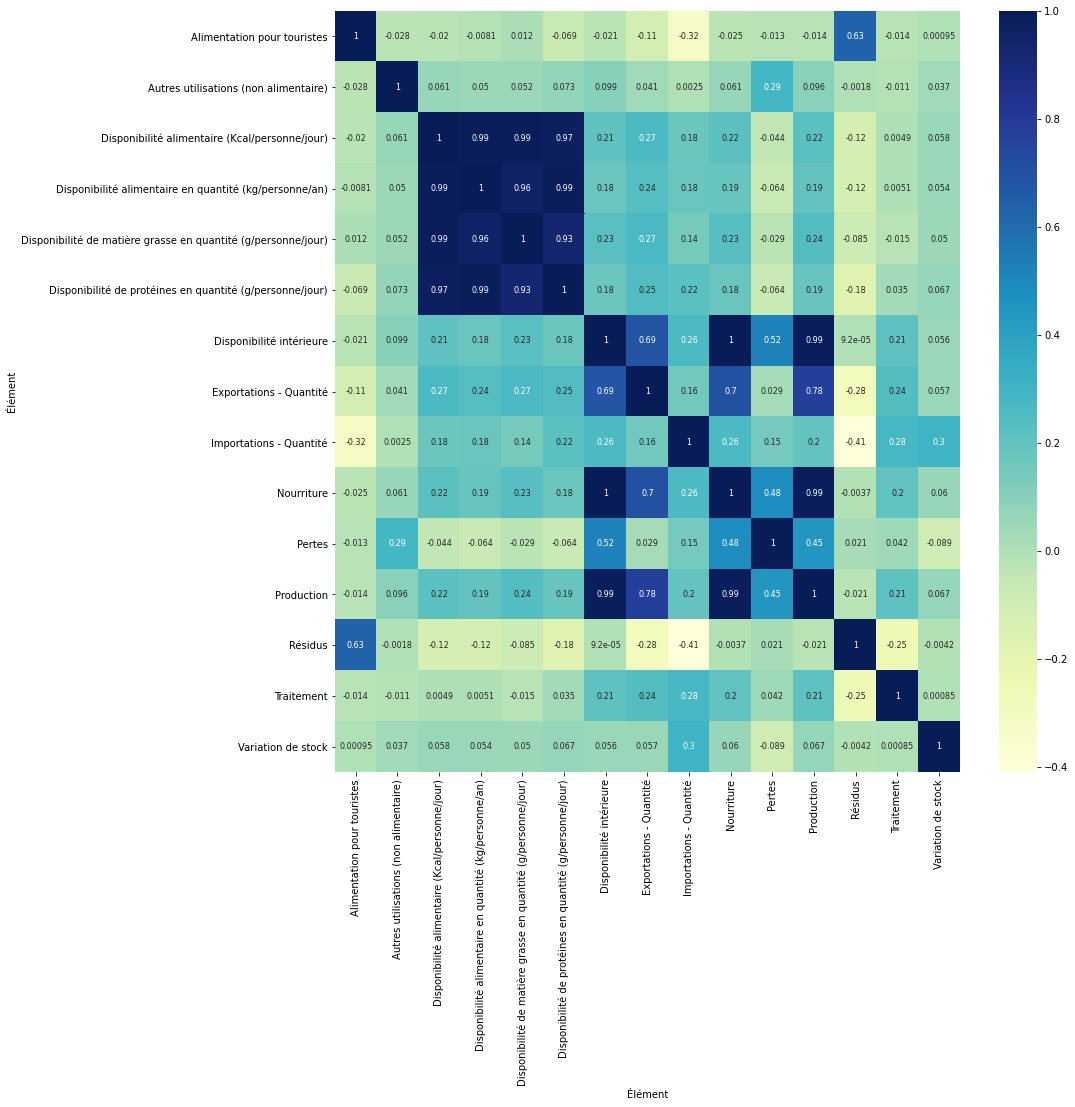

In [29]:
matrice_de_correlation(utilisation)

Je supprime des données très fortement corrélées à la disponibilité alimentaire en kg, mais qui n'apporte rien à l'analyse.

In [30]:
utilisation.drop(labels=["Disponibilité alimentaire (Kcal/personne/jour)", 
                         "Disponibilité de matière grasse en quantité (g/personne/jour)",
                         "Disponibilité de protéines en quantité (g/personne/jour)"],axis=1,inplace=True)

In [31]:
donnee_macro

Code Domaine            Domaine  Code zone (FAO)         Zone  \
0               MK  Indicateurs macro                2  Afghanistan   
1               MK  Indicateurs macro                2  Afghanistan   
2               MK  Indicateurs macro                2  Afghanistan   
3               MK  Indicateurs macro                2  Afghanistan   
4               MK  Indicateurs macro                2  Afghanistan   
...            ...                ...              ...          ...   
41945           MK  Indicateurs macro              181     Zimbabwe   
41946           MK  Indicateurs macro              181     Zimbabwe   
41947           MK  Indicateurs macro              181     Zimbabwe   
41948           MK  Indicateurs macro              181     Zimbabwe   
41949           MK  Indicateurs macro              181     Zimbabwe   

       Code Élément                                     Élément  Code Produit  \
0              6110                                 Valeur US $         22008   
1              6119                    Valeur US $ par habitant         22008   
2              6185  Valeur US $ par habitant, aux prix du 2015         22008   
3              6184               Valeur US $, aux prix du 2015         22008   
4              6129                     Croissance annuelle US$         22008   
...             ...                                         ...           ...   
41945         61290        Croissance annuelle US$ par habitant         22011   
41946          6110                                 Valeur US $         22011   
41947          6119                    Valeur US $ par habitant         22011   
41948          6129                     Croissance annuelle US$         22011   
41949         61290        Croissance annuelle US$ par habitant         22011   

                      Produit  Code année  Année     Unité        Valeur  \
0      Produit Intérieur Brut        2015   2015  millions  18713.048410   
1      Produit Intérieur Brut        2015   2015       US$    543.768940   
2      Produit Intérieur Brut        2015   2015       US$    544.000000   
3      Produit Intérieur Brut        2015   2015  millions  18713.048410   
4      Produit Intérieur Brut        2015   2015         %     -4.284522   
...                       ...         ...    ...       ...           ...   
41945    Revenu national brut        2019   2019         %     -6.432653   
41946    Revenu national brut        2020   2020  millions  21430.886292   
41947    Revenu national brut        2020   2020       US$   1441.902434   
41948    Revenu national brut        2020   2020         %     -0.553229   
41949    Revenu national brut        2020   2020         %     -2.008211   

      Symbole         Description du Symbole  Note  
0           X  Sources internationales sûres   NaN  
1           X  Sources internationales sûres   NaN  
2           X  Sources internationales sûres   NaN  
3           X  Sources internationales sûres   NaN  
4          Fc                Donnée calculée   NaN  
...       ...                            ...   ...  
41945      Fc                Donnée calculée   NaN  
41946       X  Sources internationales sûres   NaN  
41947       X  Sources internationales sûres   NaN  
41948      Fc                Donnée calculée   NaN  
41949      Fc                Donnée calculée   NaN  

[41950 rows x 15 columns]

In [32]:
donnee_macro[(donnee_macro["Zone"] == "Afghanistan") & (donnee_macro["Année"] == 2017)]

Code Domaine            Domaine  Code zone (FAO)         Zone  \
16            MK  Indicateurs macro                2  Afghanistan   
17            MK  Indicateurs macro                2  Afghanistan   
18            MK  Indicateurs macro                2  Afghanistan   
19            MK  Indicateurs macro                2  Afghanistan   
20            MK  Indicateurs macro                2  Afghanistan   
21            MK  Indicateurs macro                2  Afghanistan   
22            MK  Indicateurs macro                2  Afghanistan   
23            MK  Indicateurs macro                2  Afghanistan   
60            MK  Indicateurs macro                2  Afghanistan   
61            MK  Indicateurs macro                2  Afghanistan   
62            MK  Indicateurs macro                2  Afghanistan   
63            MK  Indicateurs macro                2  Afghanistan   
64            MK  Indicateurs macro                2  Afghanistan   
65            MK  Indicateurs macro                2  Afghanistan   
96            MK  Indicateurs macro                2  Afghanistan   
97            MK  Indicateurs macro                2  Afghanistan   
98            MK  Indicateurs macro                2  Afghanistan   
99            MK  Indicateurs macro                2  Afghanistan   
100           MK  Indicateurs macro                2  Afghanistan   
101           MK  Indicateurs macro                2  Afghanistan   
132           MK  Indicateurs macro                2  Afghanistan   
133           MK  Indicateurs macro                2  Afghanistan   
134           MK  Indicateurs macro                2  Afghanistan   
135           MK  Indicateurs macro                2  Afghanistan   
136           MK  Indicateurs macro                2  Afghanistan   
137           MK  Indicateurs macro                2  Afghanistan   
164           MK  Indicateurs macro                2  Afghanistan   
165           MK  Indicateurs macro                2  Afghanistan   
166           MK  Indicateurs macro                2  Afghanistan   
167           MK  Indicateurs macro                2  Afghanistan   

     Code Élément                                            Élément  \
16           6110                                        Valeur US $   
17           6119                           Valeur US $ par habitant   
18           6185         Valeur US $ par habitant, aux prix du 2015   
19           6184                      Valeur US $, aux prix du 2015   
20           6129                            Croissance annuelle US$   
21          61290               Croissance annuelle US$ par habitant   
22           6182         Croissance annuelle US $, aux prix de 2015   
23          61820  Croissance annuelle US $ par habitant, aux pri...   
60           6110                                        Valeur US $   
61           6184                      Valeur US $, aux prix du 2015   
62           6103                                   Part du PIB US $   
63           6187                  Part du PIB US$, aux prix de 2015   
64           6129                            Croissance annuelle US$   
65           6182         Croissance annuelle US $, aux prix de 2015   
96           6110                                        Valeur US $   
97           6184                      Valeur US $, aux prix du 2015   
98           6103                                   Part du PIB US $   
99           6187                  Part du PIB US$, aux prix de 2015   
100          6129                            Croissance annuelle US$   
101          6182         Croissance annuelle US $, aux prix de 2015   
132          6110                                        Valeur US $   
133          6184                      Valeur US $, aux prix du 2015   
134          6103                                   Part du PIB US $   
135          6187                  Part du PIB US$, aux prix de 2015   
136          6129                            Croissance annuelle

In [33]:
donnee_macro.describe(include='all')

Code Domaine            Domaine  Code zone (FAO)         Zone  \
count         41950              41950     41950.000000        41950   
unique            1                  1              NaN          211   
top              MK  Indicateurs macro              NaN  Ouzbékistan   
freq          41950              41950              NaN          277   
mean            NaN                NaN       130.997735          NaN   
std             NaN                NaN        77.658204          NaN   
min             NaN                NaN         1.000000          NaN   
25%             NaN                NaN        63.000000          NaN   
50%             NaN                NaN       129.000000          NaN   
75%             NaN                NaN       195.000000          NaN   
max             NaN                NaN       351.000000          NaN   

        Code Élément      Élément  Code Produit                 Produit  \
count   41950.000000        41950  41950.000000                   41950   
unique           NaN           10           NaN                      11   
top              NaN  Valeur US $           NaN  Produit Intérieur Brut   
freq             NaN         7841           NaN                   10128   
mean    11153.563123          NaN  22028.058141                     NaN   
std     15874.896481          NaN     27.409640                     NaN   
min      6103.000000          NaN  22008.000000                     NaN   
25%      6110.000000          NaN  22010.000000                     NaN   
50%      6129.000000          NaN  22015.000000                     NaN   
75%      6184.000000          NaN  22071.000000                     NaN   
max     61820.000000          NaN  22078.000000                     NaN   

          Code année         Année  Unité        Valeur Symbole  \
count   41950.000000  41950.000000  41950  4.195000e+04   41950   
unique           NaN           NaN      3           NaN       3   
top              NaN           NaN      %           NaN      Fc   
freq             NaN           NaN  24529           NaN   26807   
mean     2017.446985   2017.446985    NaN  5.621105e+04     NaN   
std         1.691629      1.691629    NaN  6.200198e+05     NaN   
min      2015.000000   2015.000000    NaN -8.488022e+01     NaN   
25%      2016.000000   2016.000000    NaN  2.764184e+00     NaN   
50%      2017.000000   2017.000000    NaN  1.669004e+01     NaN   
75%      2019.000000   2019.000000    NaN  3.293397e+03     NaN   
max      2020.000000   2020.000000    NaN  2.170865e+07     NaN   

       Description du Symbole  Note  
count                   41950   0.0  
unique                      3   NaN  
top           Donnée calculée   NaN  
freq                    26807   NaN  
mean                      NaN   NaN  
std                       NaN   NaN  
min                       NaN   NaN  
25%                       NaN   NaN  
50%                       NaN   NaN  
75%                       NaN   NaN  
max                       NaN   NaN

Je vais faire une colonne "indicateur" pour stocker les noms de chacun des indicateurs macros en complétant sont nom avec deux autres colonnes. Ensuite, je garde juste 4 colonnes pour simplifier le tout, zone, année, indicateur et valeur.

In [34]:
donnee_macro["Indicateur"] = donnee_macro["Produit"] + " " + donnee_macro["Élément"] + " " + donnee_macro["Unité"]
donnee_macro = donnee_macro[["Zone","Année","Indicateur","Valeur"]]
donnee_macro["Indicateur"].unique()

array(['Produit Intérieur Brut Valeur US $ millions',
       'Produit Intérieur Brut Valeur US $ par habitant US$',
       'Produit Intérieur Brut Valeur US $ par habitant, aux prix du 2015 US$',
       'Produit Intérieur Brut Valeur US $, aux prix du 2015 millions',
       'Produit Intérieur Brut Croissance annuelle US$ %',
       'Produit Intérieur Brut Croissance annuelle US$ par habitant %',
       'Produit Intérieur Brut Croissance annuelle US $, aux prix de 2015 %',
       'Produit Intérieur Brut Croissance annuelle US $ par habitant, aux prix de 2015 %',
       'Formation brute de capital fixe Valeur US $ millions',
       'Formation brute de capital fixe Valeur US $, aux prix du 2015 millions',
       'Formation brute de capital fixe Part du PIB US $ %',
       'Formation brute de capital fixe Part du PIB US$, aux prix de 2015 %',
       'Formation brute de capital fixe Croissance annuelle US$ %',
       'Formation brute de capital fixe Croissance annuelle US $, aux prix de 201

Tous les indicateurs ne me paraissent pas intéressants, je vais donc en garder que certains.

In [35]:
liste_a_garder = ['Produit Intérieur Brut Valeur US $ millions', 'Produit Intérieur Brut Valeur US $ par habitant US$',
                 'Produit Intérieur Brut Croissance annuelle US$ %','Produit Intérieur Brut Croissance annuelle US$ par habitant %',
                 'Formation brute de capital fixe Valeur US $ millions','Formation brute de capital fixe Part du PIB US $ %',
                 'Formation brute de capital fixe Croissance annuelle US$ %', 'Valeur ajoutée (agriculture, sylviculture et pêche) Valeur US $ millions',
                  'Valeur ajoutée (agriculture, sylviculture et pêche) Part du PIB US $ %', 'Valeur ajoutée (agriculture, sylviculture et pêche) Croissance annuelle US$ %',
                  'Revenu national brut Valeur US $ millions','Revenu national brut Valeur US $ par habitant US$',
                  'Revenu national brut Croissance annuelle US$ %','Revenu national brut Croissance annuelle US$ par habitant %',
                  'Valeur ajoutée (Fabrication de produits alimentaires et boissons) Valeur US $ millions',
                  'Valeur ajoutée (Fabrication de produits alimentaires et boissons) Croissance annuelle US$ %',
                  'Production brute (Agriculture, Sylviculture et Pêche) Valeur US $ millions',
                  'Production brute (Agriculture, Sylviculture et Pêche) Croissance annuelle US$ %',
                  'Production brute (Agriculture) Valeur US $ millions', 'Production brute (Agriculture) Croissance annuelle US$ %']
donnee_macro = donnee_macro[donnee_macro["Indicateur"].isin(liste_a_garder) == True]
donnee_macro
                  

Zone  Année                                         Indicateur  \
0      Afghanistan   2015        Produit Intérieur Brut Valeur US $ millions   
1      Afghanistan   2015  Produit Intérieur Brut Valeur US $ par habitan...   
4      Afghanistan   2015   Produit Intérieur Brut Croissance annuelle US$ %   
5      Afghanistan   2015  Produit Intérieur Brut Croissance annuelle US$...   
8      Afghanistan   2016        Produit Intérieur Brut Valeur US $ millions   
...            ...    ...                                                ...   
41945     Zimbabwe   2019  Revenu national brut Croissance annuelle US$ p...   
41946     Zimbabwe   2020          Revenu national brut Valeur US $ millions   
41947     Zimbabwe   2020  Revenu national brut Valeur US $ par habitant US$   
41948     Zimbabwe   2020     Revenu national brut Croissance annuelle US$ %   
41949     Zimbabwe   2020  Revenu national brut Croissance annuelle US$ p...   

             Valeur  
0      18713.048410  
1        543.768940  
4         -4.284522  
5         -7.184915  
8      18019.558182  
...             ...  
41945     -6.432653  
41946  21430.886292  
41947   1441.902434  
41948     -0.553229  
41949     -2.008211  

[19548 rows x 4 columns]

On pivote pour réorganiser sous forme de colonne et non de ligne.

In [36]:
donnee_macro= donnee_macro[donnee_macro["Année"] == 2020].pivot(index='Zone',columns='Indicateur',values='Valeur')
donnee_macro.reset_index(inplace=True)
donnee_macro

Indicateur                       Zone  \
0                         Afghanistan   
1                      Afrique du Sud   
2                             Albanie   
3                             Algérie   
4                           Allemagne   
..                                ...   
206                         Îles Cook   
207                     Îles Marshall   
208                      Îles Salomon   
209           Îles Turques-et-Caïques   
210         Îles Vierges britanniques   

Indicateur  Formation brute de capital fixe Croissance annuelle US$ %  \
0                                                    7.968139           
1                                                  -24.314173           
2                                                    0.020336           
3                                                  -10.189564           
4                                                    1.102946           
..                                                        ...           
206                                                -15.601689           
207                                                -59.680069           
208                                                -35.797296           
209                                                -22.930077           
210                                                  3.703906           

Indicateur  Formation brute de capital fixe Part du PIB US $ %  \
0                                                   11.949956    
1                                                   15.757576    
2                                                   23.027034    
3                                                   40.273987    
4                                                   21.977871    
..                                                        ...    
206                                                 10.732231    
207                                                 18.467021    
208                                                  7.567969    
209                                                 16.367982    
210                                                 23.895780    

Indicateur  Formation brute de capital fixe Valeur US $ millions  \
0                                                 2365.286230      
1                                                47610.134739      
2                                                 3433.243185      
3                                                59480.125701      
4                                               845359.899763      
..                                                        ...      
206                                                 30.414580      
207                                                 45.144932      
208                                                116.991433      
209                                                151.335579      
210                                                356.553068      

Indicateur  Production brute (Agriculture) Croissance annuelle US$ %  \
0                                                         NaN          
1                                                         NaN          
2                                                         NaN          
3                                                         NaN          
4                                                         NaN          
..                                                        ...          
206                                                       NaN          
207                                                       NaN          
208                                                       NaN          
209                                                       NaN          
210                                                       NaN          

Indicateur  Production brute (Agriculture) Valeur US $ millions  \
0                                                         NaN     
1                    

In [37]:
donnee_macro.loc[donnee_macro[['Zone']].duplicated(keep=False),:]

Empty DataFrame
Columns: [Zone, Formation brute de capital fixe Croissance annuelle US$ %, Formation brute de capital fixe Part du PIB US $ %, Formation brute de capital fixe Valeur US $ millions, Production brute (Agriculture) Croissance annuelle US$ %, Production brute (Agriculture) Valeur US $ millions, Production brute (Agriculture, Sylviculture et Pêche) Croissance annuelle US$ %, Production brute (Agriculture, Sylviculture et Pêche) Valeur US $ millions, Produit Intérieur Brut Croissance annuelle US$ %, Produit Intérieur Brut Croissance annuelle US$ par habitant %, Produit Intérieur Brut Valeur US $ millions, Produit Intérieur Brut Valeur US $ par habitant US$, Revenu national brut Croissance annuelle US$ %, Revenu national brut Croissance annuelle US$ par habitant %, Revenu national brut Valeur US $ millions, Revenu national brut Valeur US $ par habitant US$, Valeur ajoutée (agriculture, sylviculture et pêche) Croissance annuelle US$ %, Valeur ajoutée (agriculture, sylviculture et pêche) Part du PIB US $ %, Valeur ajoutée (agriculture, sylviculture et pêche) Valeur US $ millions]
Index: []

In [38]:
donnee_macro.describe()

Indicateur  Formation brute de capital fixe Croissance annuelle US$ %  \
count                                              210.000000           
mean                                                -6.036460           
std                                                 18.269763           
min                                                -59.680069           
25%                                                -15.130697           
50%                                                 -6.140066           
75%                                                  0.623280           
max                                                 90.163479           

Indicateur  Formation brute de capital fixe Part du PIB US $ %  \
count                                              210.000000    
mean                                                22.974182    
std                                                  8.520752    
min                                                  5.027860    
25%                                                 17.859001    
50%                                                 22.287336    
75%                                                 26.865934    
max                                                 57.800893    

Indicateur  Formation brute de capital fixe Valeur US $ millions  \
count                                            2.100000e+02      
mean                                             1.354305e+05      
std                                              6.976295e+05      
min                                              1.433422e+01      
25%                                              1.182441e+03      
50%                                              5.653500e+03      
75%                                              4.220493e+04      
max                                              6.382113e+06      

Indicateur  Production brute (Agriculture) Croissance annuelle US$ %  \
count                                               10.000000          
mean                                                 2.013597          
std                                                  6.812364          
min                                                 -9.232872          
25%                                                 -0.940643          
50%                                                  0.530873          
75%                                                  4.019217          
max                                                 14.131482          

Indicateur  Production brute (Agriculture) Valeur US $ millions  \
count                                               10.000000     
mean                                             27982.445838     
std                                              42872.268958     
min                                                144.125581     
25%                                               2629.459300     
50%                                              11224.201207     
75%                                              23608.762437     
max                                             133921.227453     

Indicateur  Production brute (Agriculture, Sylviculture et Pêche) Croissance annuelle US$ %  \
count                                               19.000000                                 
mean                                                -3.517838                                 
std                                                 10.879047                                 
min                                                -37.516970                                 
25%                                                 -8.987374                                 
50%                                                 -0.070534                                 
75%                                                  3.353532                                 
max                                                  7.555881                                 

Indicateur  Production br

In [39]:
donnee_macro.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211 entries, 0 to 210
Data columns (total 19 columns):
 #   Column                                                                           Non-Null Count  Dtype  
---  ------                                                                           --------------  -----  
 0   Zone                                                                             211 non-null    object 
 1   Formation brute de capital fixe Croissance annuelle US$ %                        210 non-null    float64
 2   Formation brute de capital fixe Part du PIB US $ %                               210 non-null    float64
 3   Formation brute de capital fixe Valeur US $ millions                             210 non-null    float64
 4   Production brute (Agriculture) Croissance annuelle US$ %                         10 non-null     float64
 5   Production brute (Agriculture) Valeur US $ millions                              10 non-null     float64
 6   Production

Pour ne pas fausser certains calculs, je vais retirer les 4 colonnes n'ayant pas suffisamment de valeur remplies (moins de 20) et ayant un intérêt limité.

In [40]:
donnee_macro.drop(labels=['Production brute (Agriculture) Croissance annuelle US$ %',
                          'Production brute (Agriculture) Valeur US $ millions',
                         'Production brute (Agriculture, Sylviculture et Pêche) Croissance annuelle US$ %',
                         'Production brute (Agriculture, Sylviculture et Pêche) Valeur US $ millions'], axis=1, inplace=True)
donnee_macro.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211 entries, 0 to 210
Data columns (total 15 columns):
 #   Column                                                                         Non-Null Count  Dtype  
---  ------                                                                         --------------  -----  
 0   Zone                                                                           211 non-null    object 
 1   Formation brute de capital fixe Croissance annuelle US$ %                      210 non-null    float64
 2   Formation brute de capital fixe Part du PIB US $ %                             210 non-null    float64
 3   Formation brute de capital fixe Valeur US $ millions                           210 non-null    float64
 4   Produit Intérieur Brut Croissance annuelle US$ %                               211 non-null    float64
 5   Produit Intérieur Brut Croissance annuelle US$ par habitant %                  211 non-null    float64
 6   Produit Intérieur Brut Val

In [41]:
donnee_macro[donnee_macro.isna().any(axis=1)]

Indicateur                                        Zone  \
41                                Chine - RAS de Macao   
114                                             Monaco   
156         République populaire démocratique de Corée   

Indicateur  Formation brute de capital fixe Croissance annuelle US$ %  \
41                                                  -13.82597           
114                                                  -9.70493           
156                                                       NaN           

Indicateur  Formation brute de capital fixe Part du PIB US $ %  \
41                                                  27.003364    
114                                                 22.964748    
156                                                       NaN    

Indicateur  Formation brute de capital fixe Valeur US $ millions  \
41                                                6570.733904      
114                                               1565.316162      
156                                                       NaN      

Indicateur  Produit Intérieur Brut Croissance annuelle US$ %  \
41                                                -55.881606   
114                                                -7.689286   
156                                                -2.964101   

Indicateur  Produit Intérieur Brut Croissance annuelle US$ par habitant %  \
41                                                 -56.485628               
114                                                 -8.343238               
156                                                 -3.388154               

Indicateur  Produit Intérieur Brut Valeur US $ millions  \
41                                         24333.019574   
114                                         6816.169500   
156                                        15847.371620   

Indicateur  Produit Intérieur Brut Valeur US $ par habitant US$  \
41                                               37473.753262     
114                                             173695.772381     
156                                                617.887235     

Indicateur  Revenu national brut Croissance annuelle US$ %  \
41                                              -55.881606   
114                                              -7.689286   
156                                              -2.897702   

Indicateur  Revenu national brut Croissance annuelle US$ par habitant %  \
41                                                 -56.485628             
114                                                 -8.343238             
156                                                 -3.322046             

Indicateur  Revenu national brut Valeur US $ millions  \
41                                       21541.974921   
114                                       6816.169500   
156                                      16002.689149   

Indicateur  Revenu national brut Valeur US $ par habitant US$  \
41                                               33175.440906   
114                                             173695.772381   
156                                                623.943048   

Indicateur  Valeur ajoutée (agriculture, sylviculture et pêche) Croissance annuelle US$ %  \
41                                                        NaN                               
114                                                       NaN                               
156                                                  2.205076                               

Indicateur  Valeur ajoutée (agriculture, sylviculture et pêche) Part du PIB US $ %  \
41                                                        NaN                        
114                                                       NaN                        
156                                                 22.367666                        

Indicateur  Valeur ajoutée (agriculture, sylviculture et pêche) Valeur US $ millions  
41                 

In [42]:
donnee_macro.dropna(inplace=True)

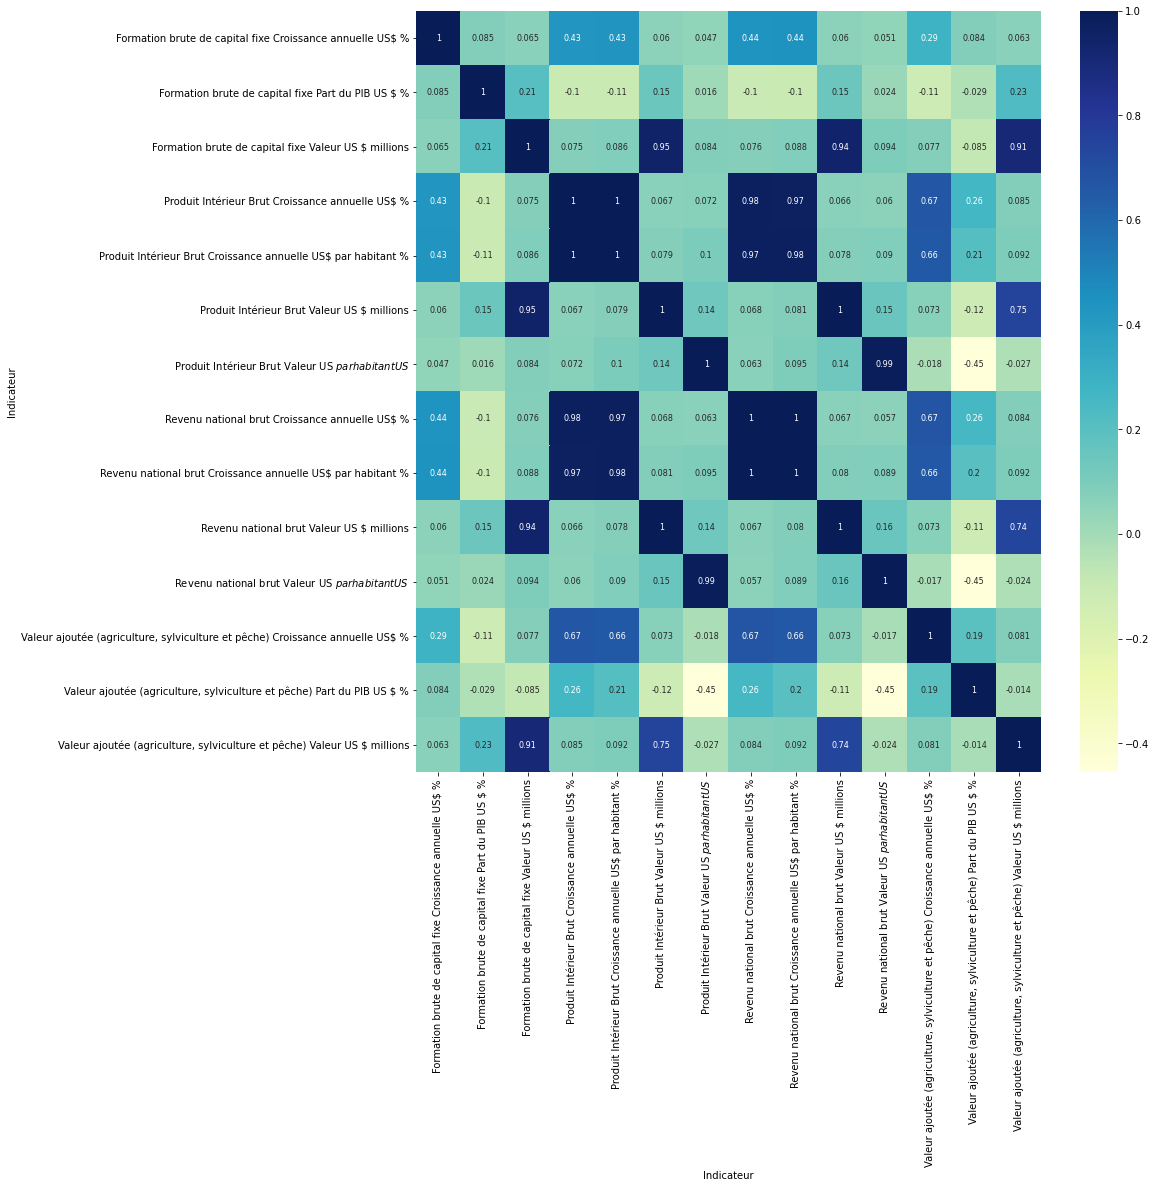

In [43]:
matrice_de_correlation(donnee_macro)

## <a name="C3">Création du dataframe final</a>

Je vais faire des jointures de type "outer" avec indicateur pour voir les lignes qui posent problème

In [44]:
df = pd.merge(utilisation, donnee_macro, on="Zone", how='outer', indicator=True)
df[df['_merge'] != 'both']

Zone  Alimentation pour touristes  \
32                         Chine - RAS de Macao                         -3.0   
33                    Chine, Taiwan Province de                          0.0   
131  République populaire démocratique de Corée                          0.0   
172                                     Andorre                          NaN   
173                                    Anguilla                          NaN   
174                                       Aruba                          NaN   
175                                     Bahreïn                          NaN   
176                                    Bermudes                          NaN   
177                                     Bhoutan                          NaN   
178                           Brunéi Darussalam                          NaN   
179                                     Burundi                          NaN   
180                                       Chine                          NaN   
181                                     Comores                          NaN   
182                                     Curaçao                          NaN   
183                                   Groenland                          NaN   
184                          Guinée équatoriale                          NaN   
185                                       Libye                          NaN   
186                               Liechtenstein                          NaN   
187               Micronésie (États fédérés de)                          NaN   
188                                  Montserrat                          NaN   
189                                       Nauru                          NaN   
190                                      Palaos                          NaN   
191                                   Palestine                          NaN   
192                   Papouasie-Nouvelle-Guinée                          NaN   
193                                  Porto Rico                          NaN   
194                                       Qatar                          NaN   
195                   République arabe syrienne                          NaN   
196            République démocratique du Congo                          NaN   
197                                 Saint-Marin                          NaN   
198                                  Seychelles                          NaN   
199                                   Singapour                          NaN   
200          Sint Maarten (partie néerlandaise)                          NaN   
201                                     Somalie                          NaN   
202                               Soudan du Sud                          NaN   
203                                       Tonga                          NaN   
204                                      Tuvalu                          NaN   
205                                    Érythrée                          NaN   
206                               Îles Caïmanes                          NaN   
207                                   Îles Cook                          NaN   
208                               Îles Marshall                          NaN   
209                     Îles Turques-et-Caïques                          NaN   
210                   Îles Vierges britanniques                          NaN   

     Autres utilisations (non alimentaire)  \
32                                     0.0   
33                                     0.0   
131                                    0.0   
172                                    NaN   
173                                    NaN   
174                                    NaN   
175                                    NaN   
176                                    NaN   
177                                    NaN   
178                                    NaN   
179                                    NaN   
180                                    NaN   
181 

In [45]:
df[df['Zone'].str.contains("chine" ,case=False, na=False)]

Zone  Alimentation pour touristes  \
31    Chine - RAS de Hong-Kong                        -18.0   
32        Chine - RAS de Macao                         -3.0   
33   Chine, Taiwan Province de                          0.0   
34         Chine, continentale                          0.0   
180                      Chine                          NaN   

     Autres utilisations (non alimentaire)  \
31                                    32.0   
32                                     0.0   
33                                     0.0   
34                                     0.0   
180                                    NaN   

     Disponibilité alimentaire en quantité (kg/personne/an)  \
31                                               53.51        
32                                               34.47        
33                                               33.17        
34                                               12.33        
180                                                NaN        

     Disponibilité intérieure  Exportations - Quantité  \
31                      280.0                    663.0   
32                       19.0                      0.0   
33                      785.0                      8.0   
34                    18161.0                    576.0   
180                       NaN                      NaN   

     Importations - Quantité  Nourriture  Pertes  Production  ...  \
31                     907.0       391.0     0.0        24.0  ...   
32                      23.0        21.0     0.0         3.0  ...   
33                     161.0       785.0     0.0       652.0  ...   
34                     452.0     17518.0   643.0     18236.0  ...   
180                      NaN         NaN     NaN         NaN  ...   

     Produit Intérieur Brut Valeur US $ millions  \
31                                  3.494447e+05   
32                                           NaN   
33                                           NaN   
34                                  1.472280e+07   
180                                 1.509658e+07   

     Produit Intérieur Brut Valeur US $ par habitant US$  \
31                                        46611.391040     
32                                                 NaN     
33                                                 NaN     
34                                        10228.970558     
180                                       10429.630529     

     Revenu national brut Croissance annuelle US$ %  \
31                                        -4.028417   
32                                              NaN   
33                                              NaN   
34                                         2.650534   
180                                        2.281093   

     Revenu national brut Croissance annuelle US$ par habitant %  \
31                                           -4.807085             
32                                                 NaN             
33                                                 NaN             
34                                            2.255423             
180                                           1.884693             

     Revenu national brut Valeur US $ millions  \
31                                3.685779e+05   
32                                         NaN   
33                                         NaN   
34                                1.462375e+07   
180                               1.501387e+07   

     Revenu national brut Valeur US $ par habitant US$  \
31                                        49163.511417   
32                                                 NaN   
33                                                 NaN   
34                                        10160.153620   
180                                       10372.491039   

     Valeur ajoutée (agriculture, sylviculture et pêche) Croissance annuelle US$ %  \
31                                            6.446491                       

In [46]:
df = df[df['_merge'] == 'both']
df = df.drop('_merge', axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 169 entries, 0 to 171
Data columns (total 27 columns):
 #   Column                                                                         Non-Null Count  Dtype  
---  ------                                                                         --------------  -----  
 0   Zone                                                                           169 non-null    object 
 1   Alimentation pour touristes                                                    169 non-null    float64
 2   Autres utilisations (non alimentaire)                                          169 non-null    float64
 3   Disponibilité alimentaire en quantité (kg/personne/an)                         169 non-null    float64
 4   Disponibilité intérieure                                                       169 non-null    float64
 5   Exportations - Quantité                                                        169 non-null    float64
 6   Importations - Quantité   

In [47]:
df= pd.merge(df, population, on="Zone", how="outer",indicator=True)
df[df['_merge'] != 'both']

Zone  Alimentation pour touristes  \
169                      Andorre                          NaN   
170                     Anguilla                          NaN   
171  Antilles néerlandaises (ex)                          NaN   
172                        Aruba                          NaN   
173                      Bahreïn                          NaN   
..                           ...                          ...   
233                Îles Marshall                          NaN   
234      Îles Turques-et-Caïques                          NaN   
235     Îles Vierges américaines                          NaN   
236    Îles Vierges britanniques                          NaN   
237        Îles Wallis-et-Futuna                          NaN   

     Autres utilisations (non alimentaire)  \
169                                    NaN   
170                                    NaN   
171                                    NaN   
172                                    NaN   
173                                    NaN   
..                                     ...   
233                                    NaN   
234                                    NaN   
235                                    NaN   
236                                    NaN   
237                                    NaN   

     Disponibilité alimentaire en quantité (kg/personne/an)  \
169                                                NaN        
170                                                NaN        
171                                                NaN        
172                                                NaN        
173                                                NaN        
..                                                 ...        
233                                                NaN        
234                                                NaN        
235                                                NaN        
236                                                NaN        
237                                                NaN        

     Disponibilité intérieure  Exportations - Quantité  \
169                       NaN                      NaN   
170                       NaN                      NaN   
171                       NaN                      NaN   
172                       NaN                      NaN   
173                       NaN                      NaN   
..                        ...                      ...   
233                       NaN                      NaN   
234                       NaN                      NaN   
235                       NaN                      NaN   
236                       NaN                      NaN   
237                       NaN                      NaN   

     Importations - Quantité  Nourriture  Pertes  Production  ...  \
169                      NaN         NaN     NaN         NaN  ...   
170                      NaN         NaN     NaN         NaN  ...   
171                      NaN         NaN     NaN         NaN  ...   
172                      NaN         NaN     NaN         NaN  ...   
173                      NaN         NaN     NaN         NaN  ...   
..                       ...         ...     ...         ...  ...   
233                      NaN         NaN     NaN         NaN  ...   
234                      NaN         NaN     NaN         NaN  ...   
235                      NaN         NaN     NaN         NaN  ...   
236                      NaN         NaN     NaN         NaN  ...   
237                      NaN         NaN     NaN         NaN  ...   

     Revenu national brut Croissance annuelle US$ %  \
169                                             NaN   
170                                             NaN   
171                                             NaN   
172                                             NaN   
173                                             NaN   
..                                              ...   
233                       

In [48]:
pd.set_option('display.max_rows', None)
df[df['_merge'] != 'both']

Zone  \
169                                       Andorre   
170                                      Anguilla   
171                   Antilles néerlandaises (ex)   
172                                         Aruba   
173                                       Bahreïn   
174                                      Bermudes   
175                                       Bhoutan   
176               Bonaire, Saint-Eustache et Saba   
177                             Brunéi Darussalam   
178                                       Burundi   
179                          Chine - RAS de Macao   
180                     Chine, Taiwan Province de   
181                                       Comores   
182                                       Curaçao   
183                                     Gibraltar   
184                                     Groenland   
185                                    Guadeloupe   
186                                          Guam   
187                            Guinée équatoriale   
188                              Guyane française   
189                                         Libye   
190                                 Liechtenstein   
191                                    Martinique   
192                                       Mayotte   
193                 Micronésie (États fédérés de)   
194                                        Monaco   
195                                    Montserrat   
196                                         Nauru   
197                                         Nioué   
198                                        Palaos   
199                                     Palestine   
200                     Papouasie-Nouvelle-Guinée   
201                                    Porto Rico   
202                                         Qatar   
203                     République arabe syrienne   
204              République démocratique du Congo   
205    République populaire démocratique de Corée   
206                                       Réunion   
207                             Sahara occidental   
208                              Saint-Barthélemy   
209                                   Saint-Marin   
210               Saint-Martin (partie française)   
211                      Saint-Pierre-et-Miquelon   
212                                   Saint-Siège   
213  Sainte-Hélène, Ascension et Tristan da Cunha   
214                             Samoa américaines   
215                          Serbie-et-Monténégro   
216                                    Seychelles   
217                                     Singapour   
218           Sint Maarten  (partie néerlandaise)   
219                                       Somalie   
220                                   Soudan (ex)   
221                                 Soudan du Sud   
222                                      Tokélaou   
223                                         Tonga   
224                                        Tuvalu   
225                                      Érythrée   
226                                    Île de Man   
227                          Îles Anglo-Normandes   
228                                 Îles Caïmanes   
229                                     Îles Cook   
230                      Îles Falkland (Malvinas)   
231                                    Îles Féroé   
232                        Îles Mariannes du Nord   
233                                 Îles Marshall   
234                       Îles Turques-et-Caïques   
235                      Îles Vierges américaines   
236                     Îles Vierges britanniques   
237                         Îles Wallis-et-Futuna   

     Alimentation pour touristes  Autres utilisations (non alimentaire)  \
169                          NaN                                    NaN   
170                          NaN                                    NaN   
171                          NaN                                    NaN   
172                          NaN  

In [49]:
df = df[df['_merge'] == 'both']
df = df.drop('_merge', axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 169 entries, 0 to 168
Data columns (total 29 columns):
 #   Column                                                                         Non-Null Count  Dtype  
---  ------                                                                         --------------  -----  
 0   Zone                                                                           169 non-null    object 
 1   Alimentation pour touristes                                                    169 non-null    float64
 2   Autres utilisations (non alimentaire)                                          169 non-null    float64
 3   Disponibilité alimentaire en quantité (kg/personne/an)                         169 non-null    float64
 4   Disponibilité intérieure                                                       169 non-null    float64
 5   Exportations - Quantité                                                        169 non-null    float64
 6   Importations - Quantité   

In [50]:
df= pd.merge(df, df_provisoire, on="Zone", how="outer",indicator=True)
df[df['_merge'] != 'both']

Zone  Alimentation pour touristes  \
169                                     Burundi                          NaN   
170                                     Bahreïn                          NaN   
171                           Brunéi Darussalam                          NaN   
172                                     Bhoutan                          NaN   
173                                       Chine                          NaN   
174            République démocratique du Congo                          NaN   
175                                   Îles Cook                          NaN   
176                                     Comores                          NaN   
177                                    Érythrée                          NaN   
178                                  Îles Féroé                          NaN   
179               Micronésie (États fédérés de)                          NaN   
180                          Guinée équatoriale                          NaN   
181                                       Libye                          NaN   
182                        Chine - RAS de Macao                          NaN   
183                               Îles Marshall                          NaN   
184                                       Nioué                          NaN   
185                                       Nauru                          NaN   
186                   Papouasie-Nouvelle-Guinée                          NaN   
187                                  Porto Rico                          NaN   
188  République populaire démocratique de Corée                          NaN   
189                                   Palestine                          NaN   
190                                       Qatar                          NaN   
191                                   Singapour                          NaN   
192                                     Somalie                          NaN   
193                               Soudan du Sud                          NaN   
194                                  Seychelles                          NaN   
195                   République arabe syrienne                          NaN   
196                                    Tokélaou                          NaN   
197                                       Tonga                          NaN   
198                                      Tuvalu                          NaN   
199                   Chine, Taiwan Province de                          NaN   

     Autres utilisations (non alimentaire)  \
169                                    NaN   
170                                    NaN   
171                                    NaN   
172                                    NaN   
173                                    NaN   
174                                    NaN   
175                                    NaN   
176                                    NaN   
177                                    NaN   
178                                    NaN   
179                                    NaN   
180                                    NaN   
181                                    NaN   
182                                    NaN   
183                                    NaN   
184                                    NaN   
185                                    NaN   
186                                    NaN   
187                                    NaN   
188                                    NaN   
189                                    NaN   
190                                    NaN   
191                                    NaN   
192                                    NaN   
193                                    NaN   
194                                    NaN   
195                                    NaN   
196                                    NaN   
197                                    NaN   
198                                    NaN   
199                                    NaN   

     Disp

Il y a deux lignes chine continental et chine qui sous-entend chine continental, donc une sorte de doublon , mais une information est a récupérer avant, la distance avec la France.

In [51]:
print(df.loc[df["Zone"] == "Chine, continentale", "Distance avec la France"])
print(df.loc[df["Zone"] == "Chine", "Distance avec la France"])
#on recupere et remplace la valeur dans distance avec la france
df.loc[df["Zone"] == "Chine, continentale", "Distance avec la France"] = df.loc[df["Zone"] == "Chine", "Distance avec la France"].values
print(df.loc[df["Zone"] == "Chine, continentale", "Distance avec la France"])


32    0.0
Name: Distance avec la France, dtype: float64
173    17631.844
Name: Distance avec la France, dtype: float64
32    17631.844
Name: Distance avec la France, dtype: float64


In [52]:
df = df[df['_merge'] == 'both']
df = df.drop('_merge', axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 169 entries, 0 to 168
Data columns (total 31 columns):
 #   Column                                                                         Non-Null Count  Dtype  
---  ------                                                                         --------------  -----  
 0   Zone                                                                           169 non-null    object 
 1   Alimentation pour touristes                                                    169 non-null    float64
 2   Autres utilisations (non alimentaire)                                          169 non-null    float64
 3   Disponibilité alimentaire en quantité (kg/personne/an)                         169 non-null    float64
 4   Disponibilité intérieure                                                       169 non-null    float64
 5   Exportations - Quantité                                                        169 non-null    float64
 6   Importations - Quantité   

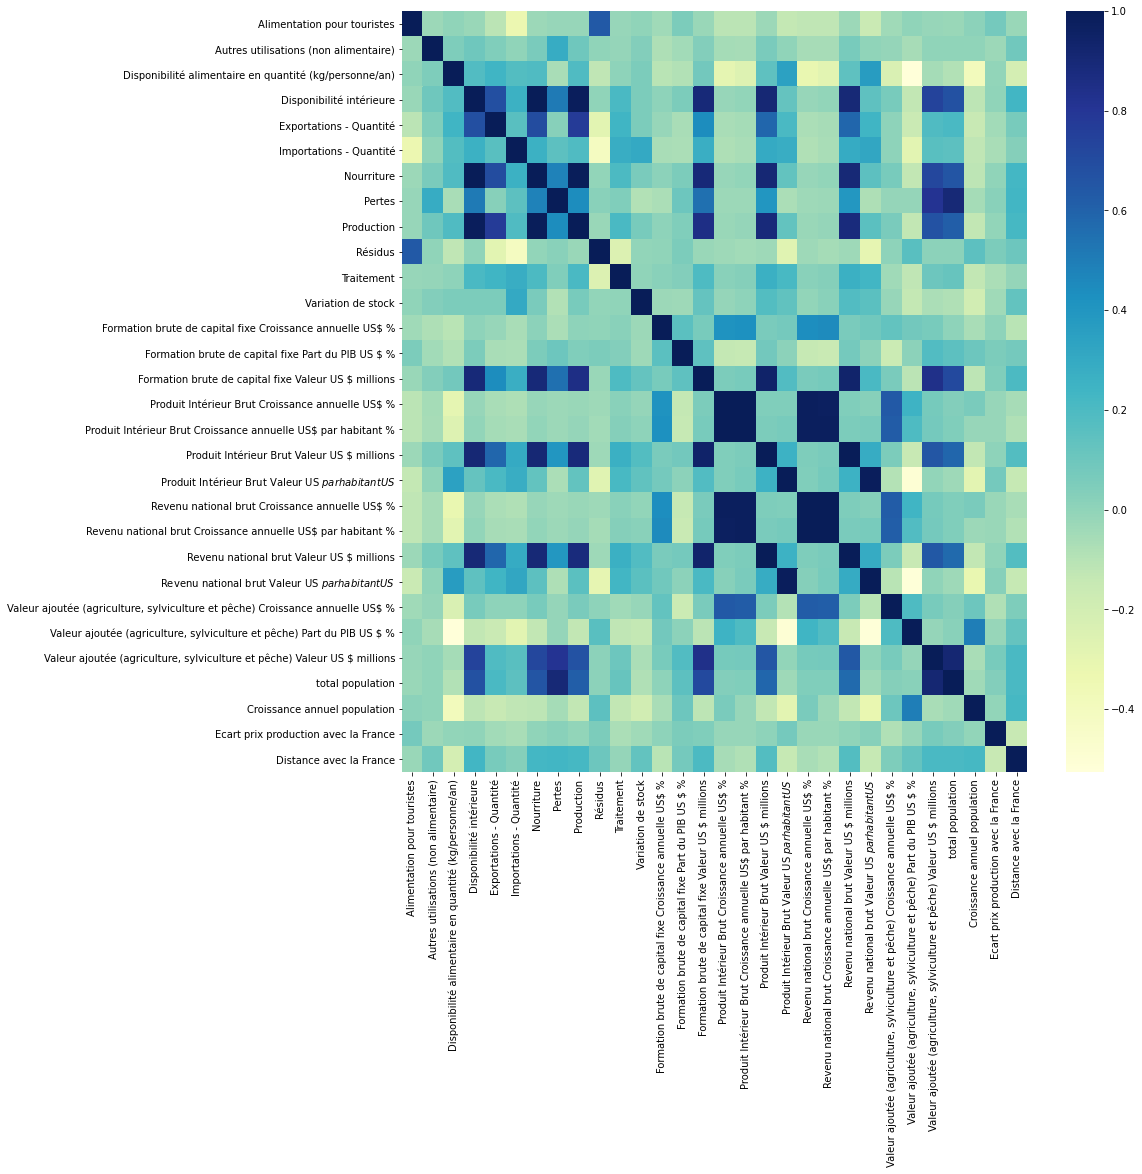

In [53]:
matrice_de_correlation(df, False)

In [54]:
df.describe()

Alimentation pour touristes  Autres utilisations (non alimentaire)  \
count                   169.000000                              169.00000   
mean                      0.118343                                8.87574   
std                       1.610296                               65.57168   
min                     -18.000000                                0.00000   
25%                       0.000000                                0.00000   
50%                       0.000000                                0.00000   
75%                       0.000000                                0.00000   
max                       5.000000                              783.00000   

       Disponibilité alimentaire en quantité (kg/personne/an)  \
count                                         169.000000        
mean                                           20.162367        
std                                            15.867322        
min                                             0.130000        
25%                                             6.460000        
50%                                            17.980000        
75%                                            29.330000        
max                                            72.310000        

       Disponibilité intérieure  Exportations - Quantité  \
count                169.000000               169.000000   
mean                 686.650888               105.544379   
std                 2193.784166               461.936671   
min                    0.000000                 0.000000   
25%                   29.000000                 0.000000   
50%                   98.000000                 0.000000   
75%                  357.000000                12.000000   
max                18266.000000              4223.000000   

       Importations - Quantité    Nourriture      Pertes    Production  \
count               169.000000    169.000000  169.000000    169.000000   
mean                 88.970414    655.923077   17.272189    716.769231   
std                 187.199741   2142.982301   78.689243   2495.312718   
min                   0.000000      0.000000    0.000000      0.000000   
25%                   3.000000     28.000000    0.000000     11.000000   
50%                  16.000000     98.000000    0.000000     67.000000   
75%                  79.000000    348.000000    2.000000    361.000000   
max                1069.000000  18100.000000  695.000000  21914.000000   

          Résidus  ...  \
count  169.000000  ...   
mean    -2.751479  ...   
std     13.384773  ...   
min   -125.000000  ...   
25%      0.000000  ...   
50%      0.000000  ...   
75%      0.000000  ...   
max      0.000000  ...   

       Revenu national brut Croissance annuelle US$ par habitant %  \
count                                         169.000000             
mean                                           -5.312356             
std                                            10.166257             
min                                           -32.132082             
25%                                           -10.902593             
50%                                            -4.956950             
75%                                             0.288659             
max                                            55.676658             

       Revenu national brut Valeur US $ millions  \
count                               1.690000e+02   
mean                                4.953956e+05   
std                                 2.063248e+06   
min                                 3.375524e+02   
25%                                 1.187069e+04   
50%                                 4.692081e+04   
75%                                 2.554224e+05   
max                                 2.128664e+07   

       Revenu national brut Valeur US $ par habitant US$  \
count                                         169.000000   
mean                                        13237.835250   
std 

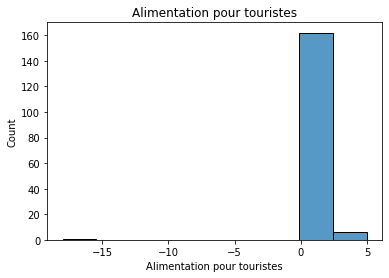

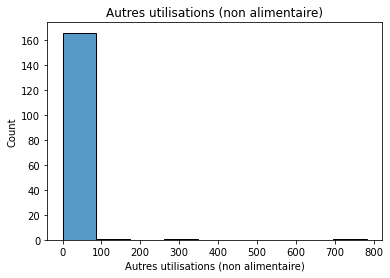

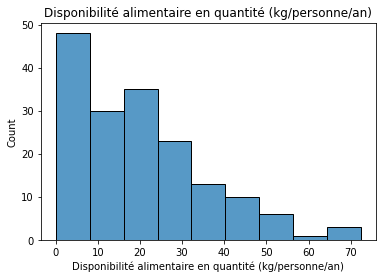

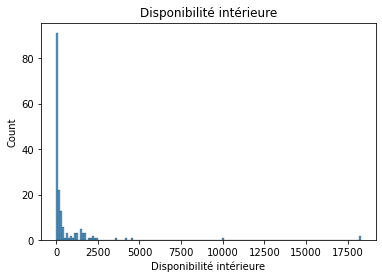

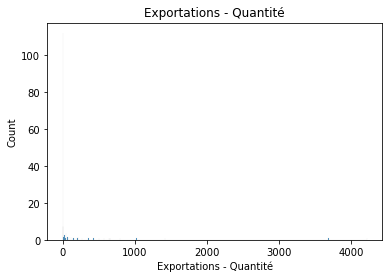

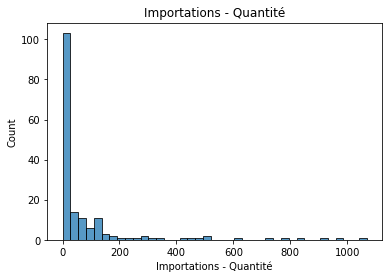

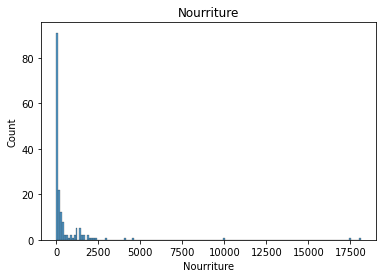

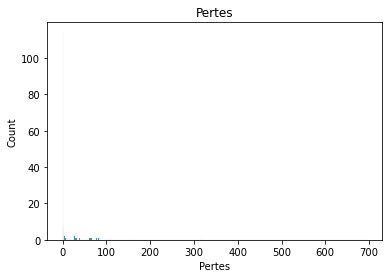

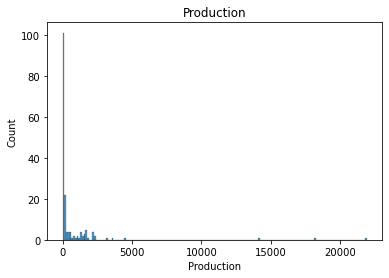

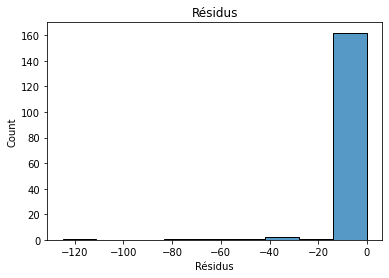

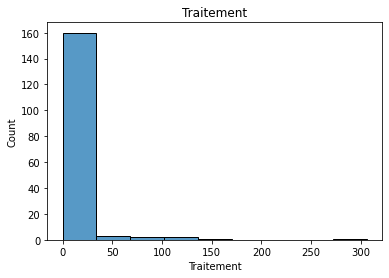

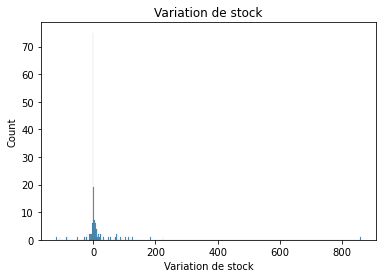

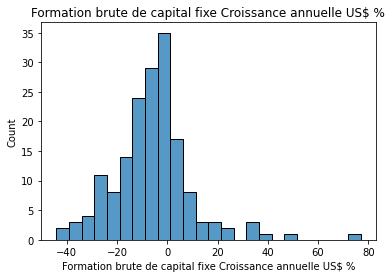

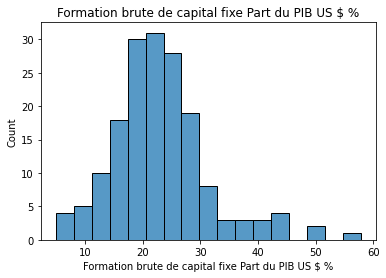

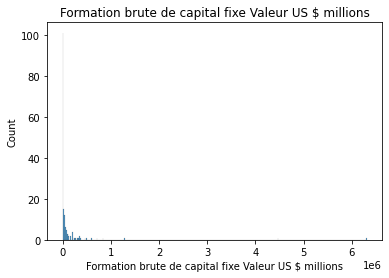

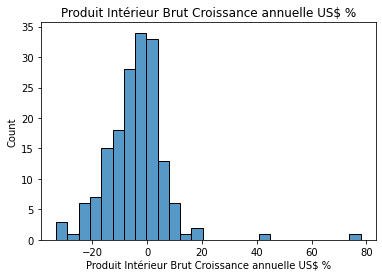

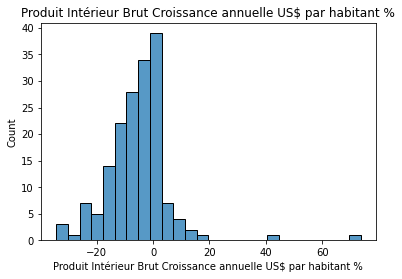

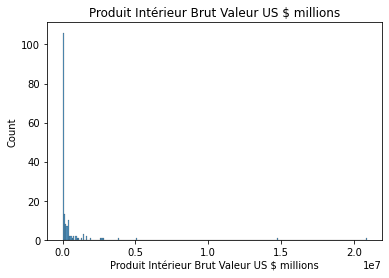

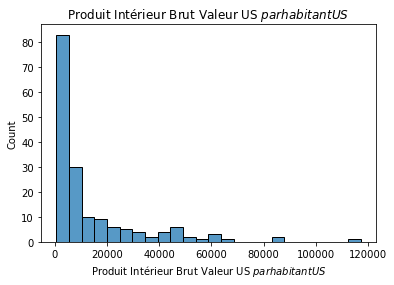

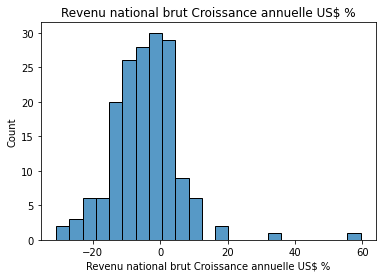

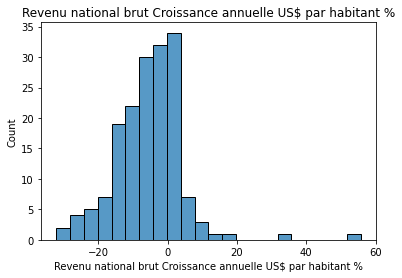

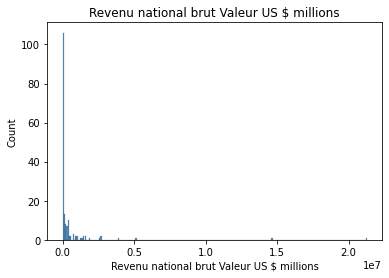

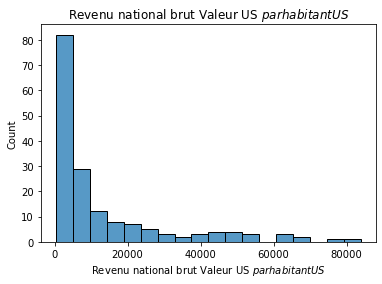

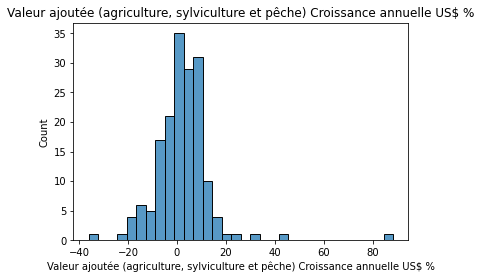

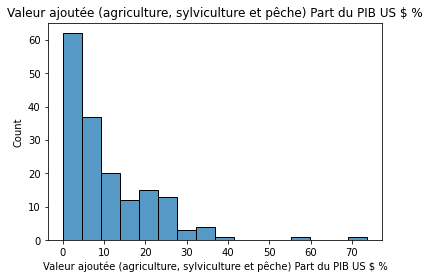

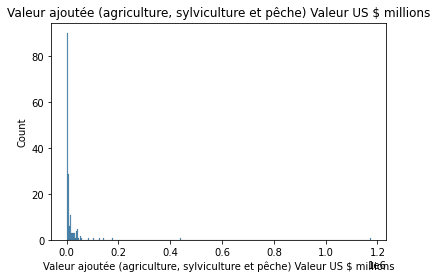

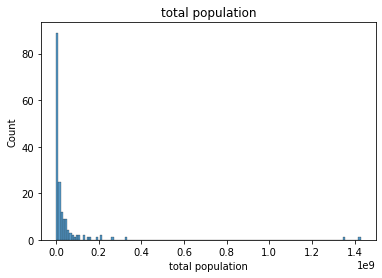

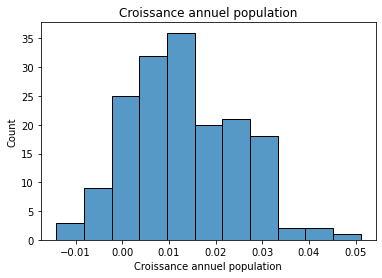

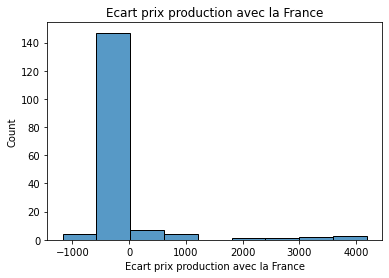

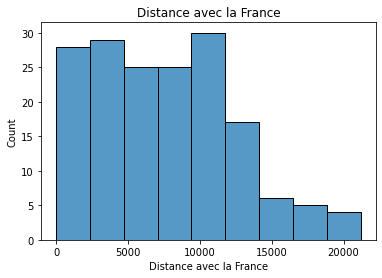

In [55]:
for name, val in df.iteritems():
    if name != "Zone":
        sns.histplot(val).set_title(name)
        plt.show()

Ici, je vais faire une recherche des outliers avec la méthode du Z-score.

In [56]:
for name, values in df.iteritems():
    if name != "Zone":
        outliers = pd.DataFrame()
        ecart_type=2
        mean = np.mean(values)
        std =np.std(values)
        
        for index, i in enumerate(values):
            z_score = (i - mean)/std
            if np.abs(z_score) > ecart_type:
                outliers = outliers.append({'z_score' : z_score, 'valeur' : round(i,2), "Pays" : df.loc[index]['Zone'] }, ignore_index = True)
                
        print("Outliers pour :",name, ",moyenne ", round(mean,2))
        display(outliers)




Outliers pour : Alimentation pour touristes ,moyenne  0.12


Pays  valeur    z_score
0  Chine - RAS de Hong-Kong   -18.0 -11.284995
1                  Maldives     5.0   3.040536
2    République dominicaine     5.0   3.040536

Outliers pour : Autres utilisations (non alimentaire) ,moyenne  8.88


Pays  valeur    z_score
0  Malaisie   320.0   4.758897
1     Pérou   783.0  11.840855

Outliers pour : Disponibilité alimentaire en quantité (kg/personne/an) ,moyenne  20.16


Pays  valeur   z_score
0               Antigua-et-Barbuda   54.10  2.145194
1         Chine - RAS de Hong-Kong   53.51  2.107900
2                           Israël   67.39  2.985254
3             Saint-Kitts-et-Nevis   55.77  2.250755
4  Saint-Vincent-et-les Grenadines   72.31  3.296246
5                     Sainte-Lucie   56.69  2.308908
6                            Samoa   64.77  2.819644
7                Trinité-et-Tobago   54.54  2.173007
8            États-Unis d'Amérique   55.68  2.245066

Outliers pour : Disponibilité intérieure ,moyenne  686.65


Pays   valeur   z_score
0                 Brésil   9982.0  4.249722
1    Chine, continentale  18161.0  7.989063
2  États-Unis d'Amérique  18266.0  8.037067

Outliers pour : Exportations - Quantité ,moyenne  105.54


Pays  valeur   z_score
0                 Brésil  4223.0  8.939952
1               Pays-Bas  1418.0  2.849646
2  États-Unis d'Amérique  3692.0  7.787028

Outliers pour : Importations - Quantité ,moyenne  88.97


Pays  valeur   z_score
0                                     Afrique du Sud   514.0  2.277208
1                                          Allemagne   842.0  4.034554
2                                    Arabie saoudite   722.0  3.391622
3                           Chine - RAS de Hong-Kong   907.0  4.382808
4                                             France   506.0  2.234346
5                                               Iraq   470.0  2.041466
6                                              Japon  1069.0  5.250766
7                                            Mexique   972.0  4.731063
8                                           Pays-Bas   608.0  2.780837
9  Royaume-Uni de Grande-Bretagne et d'Irlande du...   779.0  3.697015

Outliers pour : Nourriture ,moyenne  655.92


Pays   valeur   z_score
0                 Brésil   9982.0  4.364848
1    Chine, continentale  17518.0  7.891893
2  États-Unis d'Amérique  18100.0  8.164284

Outliers pour : Pertes ,moyenne  17.27


Pays  valeur   z_score
0  Chine, continentale   643.0  7.975516
1                 Inde   695.0  8.638307
2                Pérou   316.0  3.807580

Outliers pour : Production ,moyenne  716.77


Pays   valeur   z_score
0                 Brésil  14201.0  5.419883
1    Chine, continentale  18236.0  7.041720
2  États-Unis d'Amérique  21914.0  8.520064

Outliers pour : Résidus ,moyenne  -2.75


Pays  valeur   z_score
0                 Allemagne   -38.0 -2.641305
1  Chine - RAS de Hong-Kong  -125.0 -9.160545
2                  Pays-Bas   -78.0 -5.638657
3                   Pologne   -59.0 -4.214915
4                     Suède   -37.0 -2.566371
5                 Thaïlande   -48.0 -3.390643

Outliers pour : Traitement ,moyenne  7.15


Pays  valeur   z_score
0                                          Allemagne   167.0  5.205519
1                                             France    89.0  2.665386
2                                          Indonésie   306.0  9.732167
3                                           Pays-Bas   104.0  3.153873
4  Royaume-Uni de Grande-Bretagne et d'Irlande du...   102.0  3.088742
5                              États-Unis d'Amérique    77.0  2.274596

Outliers pour : Variation de stock ,moyenne  13.5


Pays  valeur    z_score
0   France   183.0   2.255352
1    Japon   859.0  11.250303
2  Pologne   225.0   2.814210

Outliers pour : Formation brute de capital fixe Croissance annuelle US$ % ,moyenne  -5.6


Pays  valeur   z_score
0                          Gambie   39.21  2.840849
1                   Guinée-Bissau   49.20  3.474506
2  Iran (République islamique d')   76.88  5.229735
3                           Liban   35.26  2.590699
4               Macédoine du Nord   36.26  2.654004
5                          Malawi  -39.55 -2.152102
6       République centrafricaine   34.85  2.564659
7                           Yémen  -44.22 -2.448656

Outliers pour : Formation brute de capital fixe Part du PIB US $ % ,moyenne  23.19


Pays  valeur   z_score
0                      Algérie   40.27  2.035112
1           Antigua-et-Barbuda   43.57  2.427874
2                   Cabo Verde   50.80  3.288651
3          Chine, continentale   42.88  2.345865
4                     Maldives   40.62  2.076760
5                   Mauritanie   45.14  2.614400
6                   Mozambique   57.80  4.122940
7  République-Unie de Tanzanie   44.33  2.518325
8                       Soudan    5.03 -2.163452
9                 Turkménistan   49.55  3.140251

Outliers pour : Formation brute de capital fixe Valeur US $ millions ,moyenne  129302.71


Pays      valeur    z_score
0    Chine, continentale  6313533.97  10.209954
1  États-Unis d'Amérique  4478942.00   7.181106

Outliers pour : Produit Intérieur Brut Croissance annuelle US$ % ,moyenne  -4.21


Pays  valeur   z_score
0                                  Angola  -30.32 -2.245646
1          Iran (République islamique d')   43.72  4.122592
2                                    Iraq  -29.07 -2.138130
3                                Maldives  -33.26 -2.498378
4                                  Soudan   77.84  7.057719
5  Venezuela (République bolivarienne du)  -29.16 -2.145647

Outliers pour : Produit Intérieur Brut Croissance annuelle US$ par habitant % ,moyenne  -5.31


Pays  valeur   z_score
0                                  Angola  -32.53 -2.392378
1          Iran (République islamique d')   41.87  4.146236
2                                    Iraq  -30.68 -2.230007
3                                   Liban   19.18  2.151956
4                                Maldives  -34.44 -2.560720
5                                  Soudan   73.64  6.938255
6  Venezuela (République bolivarienne du)  -28.96 -2.078733

Outliers pour : Produit Intérieur Brut Valeur US $ millions ,moyenne  495641.93


Pays       valeur    z_score
0    Chine, continentale  14722800.53   6.988512
1                  Japon   5057758.96   2.240954
2  États-Unis d'Amérique  20893746.00  10.019738

Outliers pour : Produit Intérieur Brut Valeur US $ par habitant US$ ,moyenne  13702.66


Pays     valeur   z_score
0              Australie   55822.71  2.194644
1               Danemark   61476.60  2.489237
2                Irlande   86250.99  3.780094
3                Islande   63644.02  2.602169
4             Luxembourg  117181.65  5.391720
5                Norvège   66870.73  2.770295
6               Pays-Bas   53333.66  2.064953
7                 Suisse   86918.65  3.814882
8                  Suède   53574.55  2.077505
9  États-Unis d'Amérique   63122.59  2.575000

Outliers pour : Revenu national brut Croissance annuelle US$ % ,moyenne  -4.22


Pays  valeur   z_score
0                          Angola  -29.91 -2.484548
1                         Bahamas  -25.25 -2.033993
2  Iran (République islamique d')   35.68  3.858441
3                           Liban   18.24  2.172416
4                        Maldives  -30.88 -2.578299
5                          Soudan   59.44  6.156881
6                          Égypte   16.98  2.050247

Outliers pour : Revenu national brut Croissance annuelle US$ par habitant % ,moyenne  -5.31


Pays  valeur   z_score
0                          Angola  -32.13 -2.645952
1                         Bahamas  -25.97 -2.037855
2  Iran (République islamique d')   33.93  3.871922
3                           Liban   18.77  2.375609
4                        Maldives  -32.11 -2.643576
5                          Soudan   55.68  6.016989

Outliers pour : Revenu national brut Valeur US $ millions ,moyenne  495395.62


Pays       valeur    z_score
0    Chine, continentale  14623750.67   6.867978
1                  Japon   5156421.00   2.265785
2  États-Unis d'Amérique  21286637.00  10.106894

Outliers pour : Revenu national brut Valeur US $ par habitant US$ ,moyenne  13237.84


Pays    valeur   z_score
0                  Australie  54250.89  2.310899
1   Chine - RAS de Hong-Kong  49163.51  2.024248
2                   Danemark  63551.96  2.834972
3                   Finlande  49517.25  2.044180
4                    Irlande  65632.87  2.952222
5                    Islande  65230.13  2.929529
6                 Luxembourg  74956.01  3.477538
7                    Norvège  69854.54  3.190094
8                   Pays-Bas  52406.16  2.206957
9                     Suisse  83803.30  3.976043
10                     Suède  55191.38  2.363891
11     États-Unis d'Amérique  64309.57  2.877660

Outliers pour : Valeur ajoutée (agriculture, sylviculture et pêche) Croissance annuelle US$ % ,moyenne  2.32


Pays  valeur   z_score
0                                 Bahamas  -36.10 -3.345377
1          Iran (République islamique d')   42.38  3.487067
2                    Sao Tomé-et-Principe   25.96  2.058268
3                                  Soudan   88.35  7.489607
4  Venezuela (République bolivarienne du)   30.87  2.485446

Outliers pour : Valeur ajoutée (agriculture, sylviculture et pêche) Part du PIB US $ % ,moyenne  10.87


Pays  valeur   z_score
0  Guinée-Bissau   33.60  2.086913
1        Libéria   73.69  5.767539
2           Mali   35.27  2.240234
3          Niger   38.38  2.525901
4   Sierra Leone   55.83  4.127593
5       Éthiopie   35.56  2.266695
6   Îles Salomon   32.68  2.001716

Outliers pour : Valeur ajoutée (agriculture, sylviculture et pêche) Valeur US $ millions ,moyenne  21615.02


Pays      valeur    z_score
0  Chine, continentale  1175288.15  11.791541
1                 Inde   437071.66   4.246328

Outliers pour : total population ,moyenne  43776028.28


Pays        valeur   z_score
0  Chine, continentale  1.427648e+09  8.922586
1                 Inde  1.352642e+09  8.438984

Outliers pour : Croissance annuel population ,moyenne  0.01


Pays  valeur   z_score
0  Bosnie-Herzégovine   -0.01 -2.203760
1            Lettonie   -0.01 -2.118249
2            Lituanie   -0.01 -2.335366
3            Maldives    0.04  2.651410
4               Niger    0.04  2.244393
5                Oman    0.05  3.246849
6             Ouganda    0.04  2.012036

Outliers pour : Ecart prix production avec la France ,moyenne  135.19


Pays  valeur   z_score
0     Arménie  2180.7  2.958760
1  Cabo Verde  3625.9  5.049192
2       Fidji  4189.6  5.864564
3     Grenade  3690.4  5.142489
4  Luxembourg  3022.1  4.175816
5    Viet Nam  2594.9  3.557886
6       Yémen  3136.1  4.340713

Outliers pour : Distance avec la France ,moyenne  7296.62


Pays    valeur   z_score
0                        Australie  18250.64  2.179747
1  Bolivie (État plurinational de)  17606.23  2.051515
2              Chine, continentale  17631.84  2.056611
3                            Japon  17590.02  2.048288
4                         Mongolie  19032.12  2.335254
5               Nouvelle-Calédonie  19215.12  2.371668
6                 Nouvelle-Zélande  21173.18  2.761303
7              République de Corée  17348.10  2.000149
8                          Vanuatu  19085.99  2.345974

Le seul outlier qui me parait problématique est la valeur négative du tourisme pour Hong kong, je supprime la ligne.

In [57]:
df.drop(df[df["Zone"] == "Chine - RAS de Hong-Kong"].index, inplace = True)


In [58]:
df = df.set_index('Zone')
df

Alimentation pour touristes  \
Zone                                                                              
Afghanistan                                                                 0.0   
Afrique du Sud                                                              0.0   
Albanie                                                                     0.0   
Algérie                                                                     0.0   
Allemagne                                                                   0.0   
Angola                                                                      0.0   
Antigua-et-Barbuda                                                          2.0   
Arabie saoudite                                                             0.0   
Argentine                                                                   0.0   
Arménie                                                                     0.0   
Australie                                                                   0.0   
Autriche                                                                    0.0   
Azerbaïdjan                                                                 0.0   
Bahamas                                                                     0.0   
Bangladesh                                                                  0.0   
Barbade                                                                     3.0   
Belgique                                                                    0.0   
Belize                                                                      1.0   
Bolivie (État plurinational de)                                             0.0   
Bosnie-Herzégovine                                                          0.0   
Botswana                                                                   -0.0   
Brésil                                                                      0.0   
Bulgarie                                                                    0.0   
Burkina Faso                                                                0.0   
Bélarus                                                                     0.0   
Bénin                                                                       0.0   
Cabo Verde                                                                  0.0   
Cambodge                                                                    0.0   
Cameroun                                                                    0.0   
Canada                                                                      0.0   
Chili                                                                       0.0   
Chine, continentale                                                         0.0   
Chypre                                                                      2.0   
Colombie                                                                    0.0   
Congo                                                                       0.0   
Costa Rica                                                                  3.0   
Croatie                                                                     0.0   
Cuba                                                                        3.0   
Côte d'Ivoire                                                               0.0   
Danemark                                                                    0.0   
Djibouti                                                                    0.0   
Dominique                                                                   2.0   
El Salvador                                                                 0.0   
Espagne                                                                     0.0   
Estonie                                                                     0.0   
Eswatini                                                                    0.0   
Fidji                                                               

## <a name="C4">ACP</a>

J'ai plusieurs objectifs, conserver une variance élevée et avoir le moins de composantes principales. J'ai fait plusieurs choses, démarrer avec n_components=0.95 pour voir ce que cela donne avec 95% de variances, dans mon cas plus de 15 composantes principales dont certaines avait très peu de sens, flèche très dispersé et très courte dans le cercle de corrélation. J'ai ensuite fait la méthode du coude avec un éboulis des valeurs, mais la variance pour 3 composantes suggérées est trop faible à mon goût, j'ai donc choisi d'augmenter le nombre de composantes à 10, ce qui permet d'atteindre 83% de variances et des cercles de corrélations ayant du sens sur tous les plans factoriels. Avec toutes les données importantes visibles.

In [59]:
#on prépare un jeux de donnée sans les noms de pays
donnee_pca = df#.drop('Zone', axis=1)
#je garde les noms de pays
names =df.index
#on garde les noms de colones
features = donnee_pca.columns

X = donnee_pca.values

#centrage et réduction des données
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

#calcul de l'acp 
pca = decomposition.PCA(n_components=10)
pca.fit(X_scaled)

# Projection des individus
X_projected = pca.transform(X_scaled)
liste_colone = []
for i in range(pca.n_components_):
    liste_colone.append('pca'+str(i+1))

df_pca = pd.DataFrame(X_projected, columns = liste_colone)
df_pca.index = df.index

In [60]:
print("Nombre de composante principale", pca.n_components_)
print("Variance expliqué par composante",pca.explained_variance_ratio_)
print("Variance expliqué",pca.explained_variance_ratio_.sum())

Nombre de composante principale 10
Variance expliqué par composante [0.26368107 0.16535327 0.11067637 0.05478151 0.05115636 0.04463877
 0.04102879 0.03598919 0.03317204 0.0303888 ]
Variance expliqué 0.8308661650092533


Eboulis des valeurs propres, la méthode du coude ne donne pas de bon résultat et ne permet pas de garder suffisament de variance.

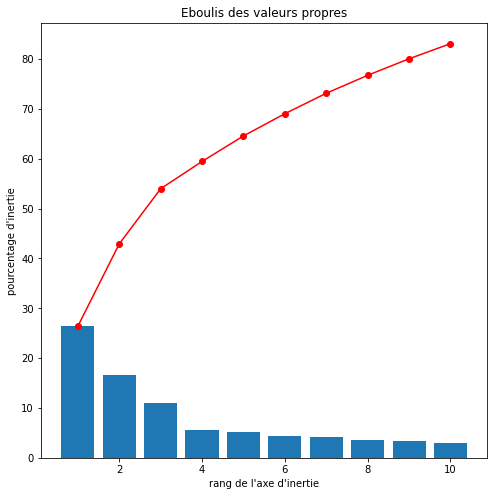

In [61]:
variance = pca.explained_variance_ratio_*100
plt.figure(figsize=(8, 8))
plt.bar(np.arange(len(variance))+1, variance)
plt.plot(np.arange(len(variance))+1, variance.cumsum(),c="red",marker='o')
plt.xlabel("rang de l'axe d'inertie")
plt.ylabel("pourcentage d'inertie")
plt.title("Eboulis des valeurs propres")
plt.show(block=False)

Dans ce bloc de code je vais faire l'affichage du cercle de corrélation, l'affichage des individus sur le plan factoriel et comme tous ces graphiques sont assez illisible, je vais faire un tableau avec les valeurs qui contribuent le plus (vecteur le plus long sur les cercles de corrélation). Cette méthode m'a permis de vérifier que toutes les variables que je considère importantes pour l'analyse étaient bien présente avec suffisamment de poids.

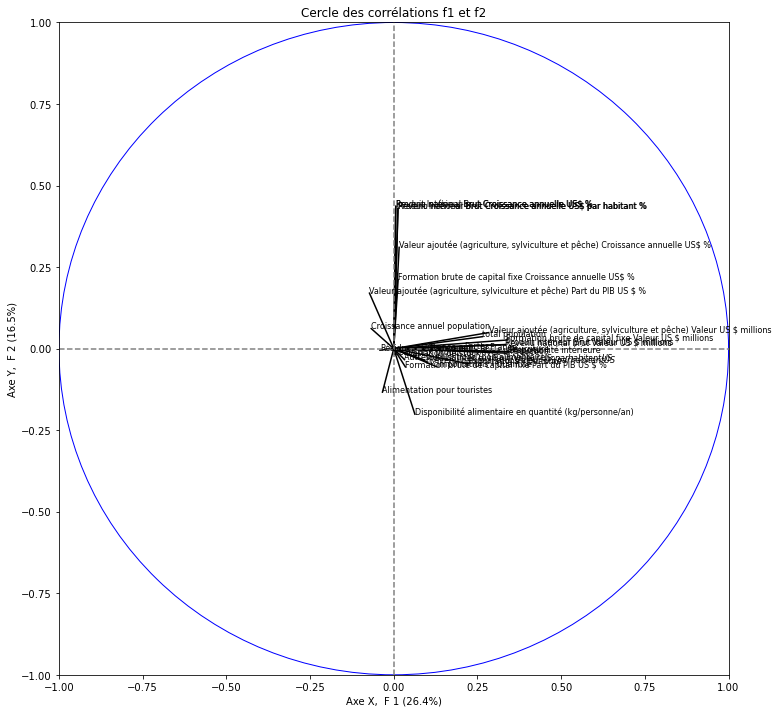

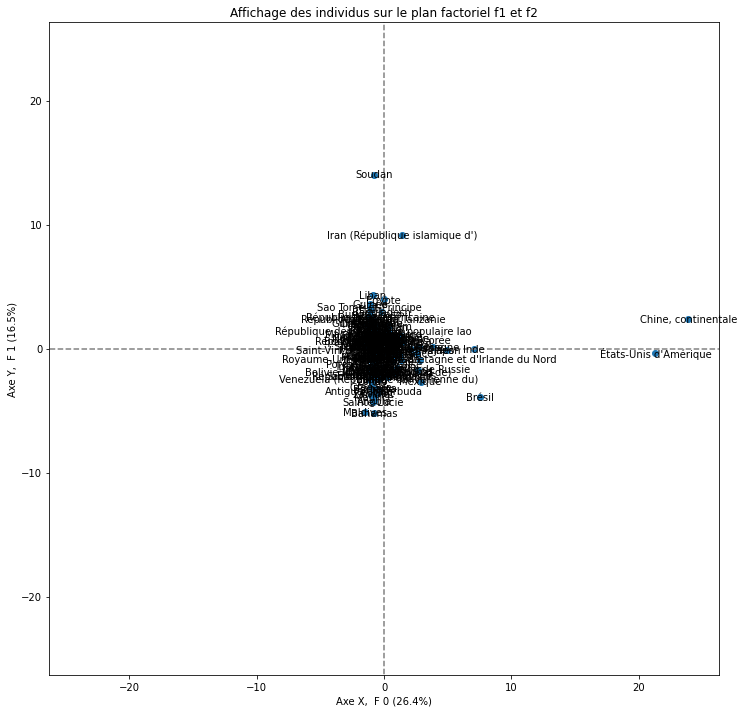

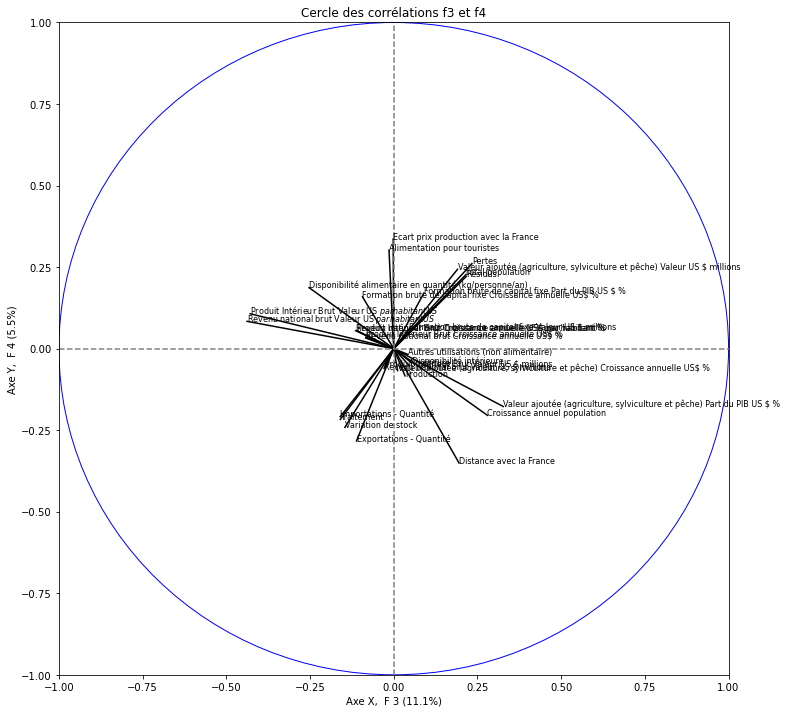

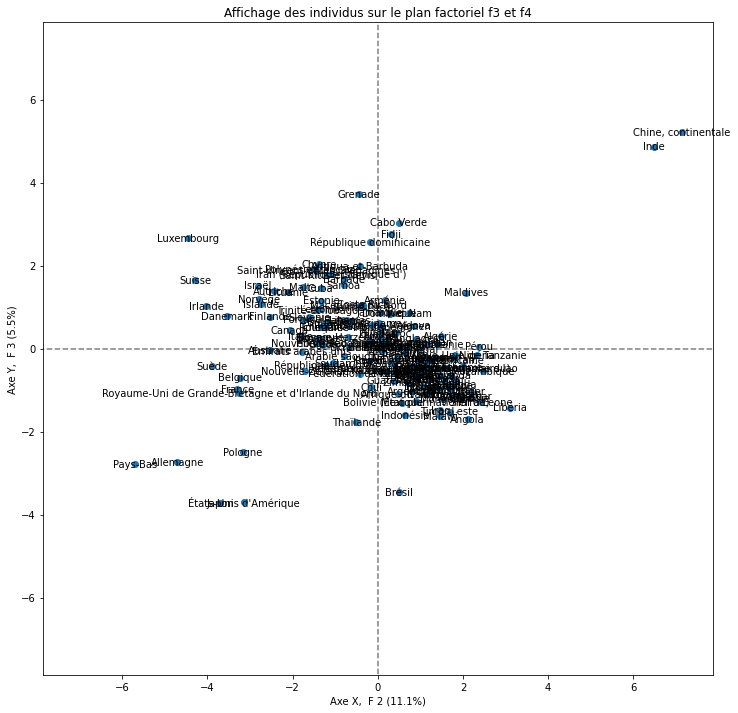

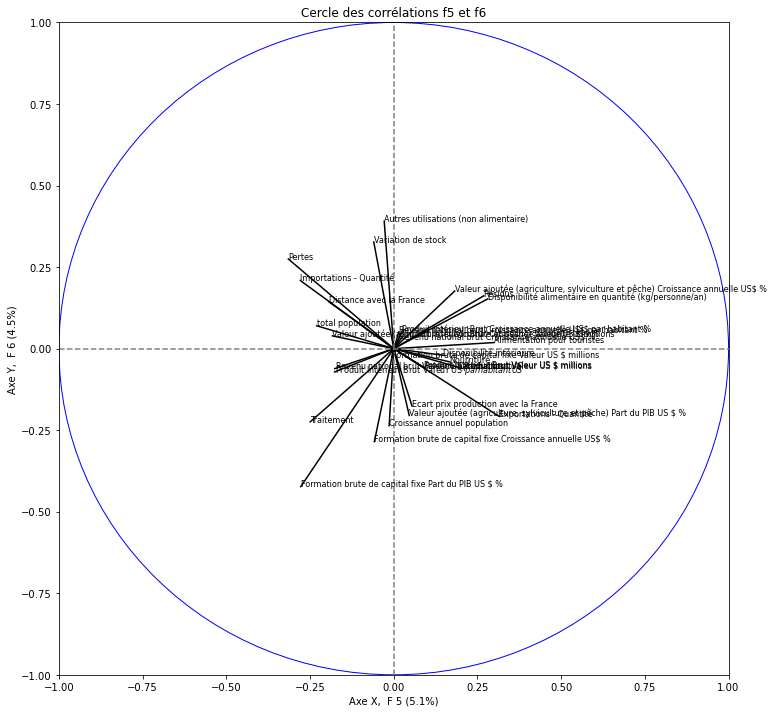

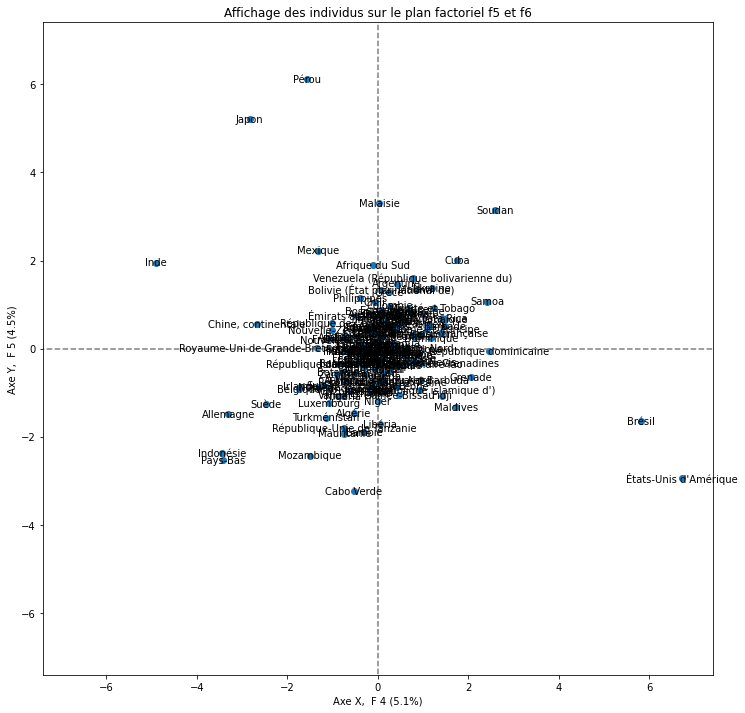

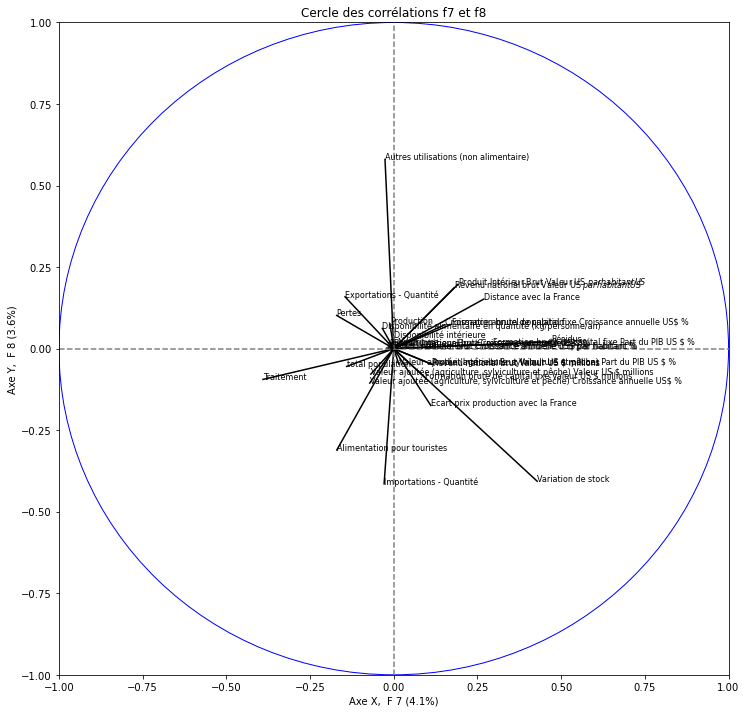

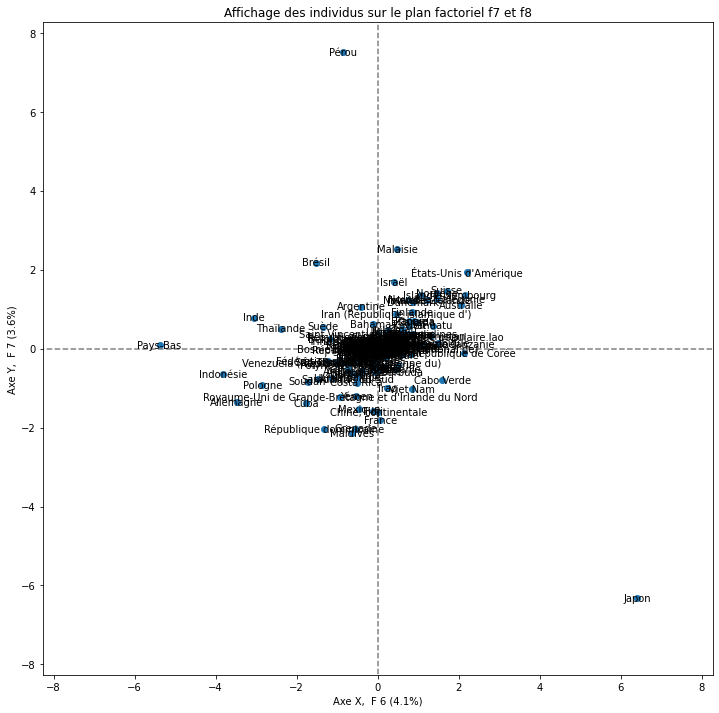

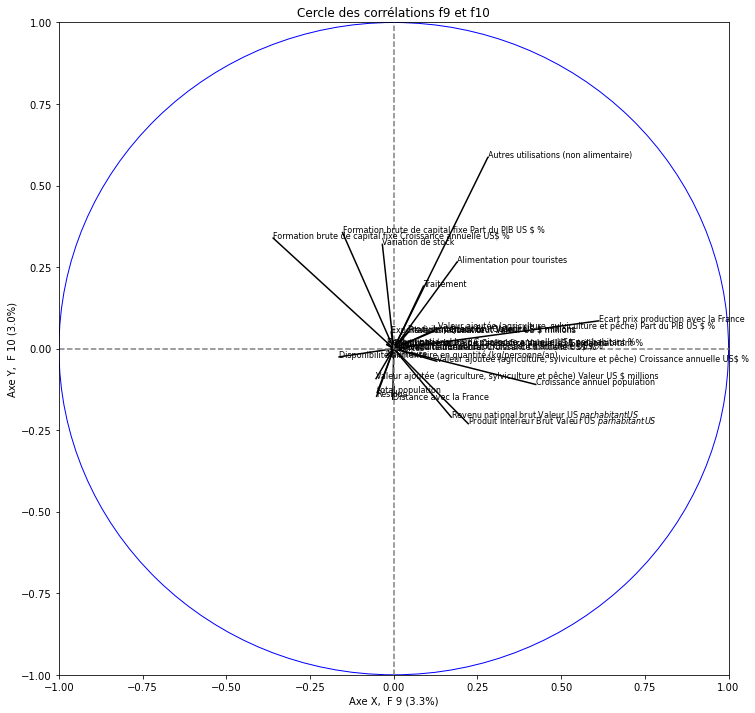

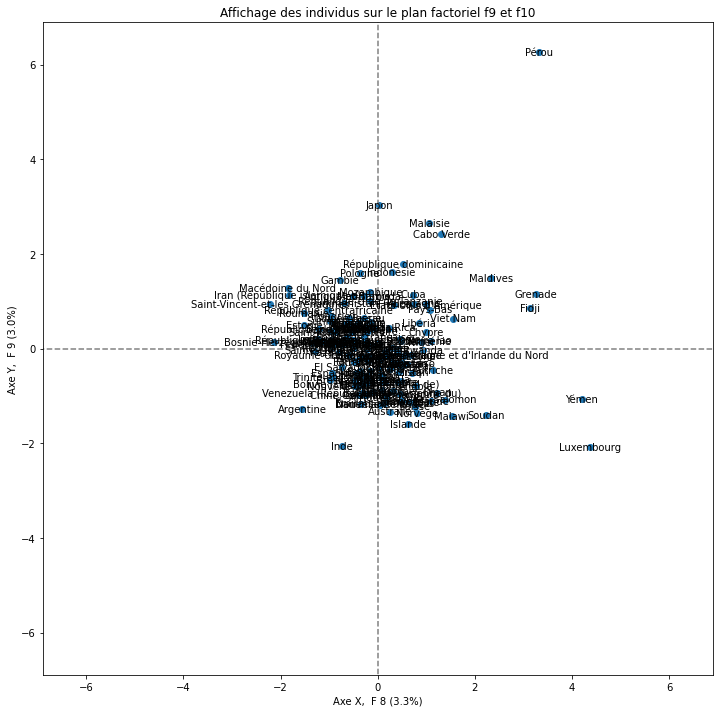

In [62]:
pcs = pca.components_
for j in range (0, pca.n_components_ , 2):
    df_res_pca = pd.DataFrame()
    #affichage des cerclesde corrélations
    plt.figure(figsize=(12, 12))
    for i, (x, y) in enumerate(zip(pcs[j, :], pcs[j+1, :])):
        # Afficher un segment de l'origine au point (x, y)
        plt.plot([0, x], [0, y], color='k')
        # Afficher le nom (data.columns[i]) de la performance
        plt.text(x, y, features[i], fontsize='8')
        df_res_pca = df_res_pca.append({'etiquette' : features[i], "x" : x, "y" : y}, ignore_index = True)
    draw_circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
    plt.gcf().gca().add_artist(draw_circle)
    plt.plot([-1, 1], [0, 0], color='grey', ls='--')
    plt.plot([0, 0], [-1,1], color='grey', ls='--')
    plt.xlim([-1,1])
    plt.ylim([-1, 1])
    plt.title("Cercle des corrélations f{} et f{}".format(j+1, j+2))
    plt.xlabel('Axe X,  F {} ({}%)'.format(j+1, round(100*pca.explained_variance_ratio_[j],1)))
    plt.ylabel('Axe Y,  F {} ({}%)'.format(j+2, round(100*pca.explained_variance_ratio_[j+1],1)))
    plt.show()
    
    #projection des individus sur le plan factoriel
    plt.figure(figsize=(12, 12))
    plt.title("Affichage des individus sur le plan factoriel f{} et f{}".format(j+1, j+2))
    plt.scatter(X_projected[:, j], X_projected[:, j+1])
    plt.xlabel('Axe X,  F {} ({}%)'.format(j, round(100*pca.explained_variance_ratio_[j],1)))
    plt.ylabel('Axe Y,  F {} ({}%)'.format(j+1, round(100*pca.explained_variance_ratio_[j+1],1)))
    for i,(x,y) in enumerate(X_projected[:,[j,j+1]]):
                    plt.text(x, y, names[i], fontsize='10', ha='center',va='center') 
                    
    boundary = np.max(np.abs(X_projected[:, [j,j+1]])) * 1.1
    plt.xlim([-boundary,boundary])
    plt.ylim([-boundary,boundary])
    plt.plot([-30, 100], [0, 0], color='grey', ls='--')
    plt.plot([0, 0], [-30, 30], color='grey', ls='--')
    plt.show()
    
    #affichage des variables contribuant le plus à la variance
    pc1 = pca.components_[j]
    pc2 = pca.components_[j+1]
    df_pf1 = pd.DataFrame(pc1, index=features, columns=['x'])
    df_pf1['y'] = pc2
    df_pf1['Longueur du vecteur'] = pow((pow(pc1,2)+pow(pc2,2)),0.5)

    display(df_pf1.sort_values('Longueur du vecteur', ascending = False).head(8).style.background_gradient(cmap="crest").set_precision(2).set_caption("Les variables contribuant le plus à la variance"))


In [63]:
X_clustered = pd.DataFrame(X_scaled, index=names, columns=features)

## <a name="C5">Classification ascendante hiérarchique</a>

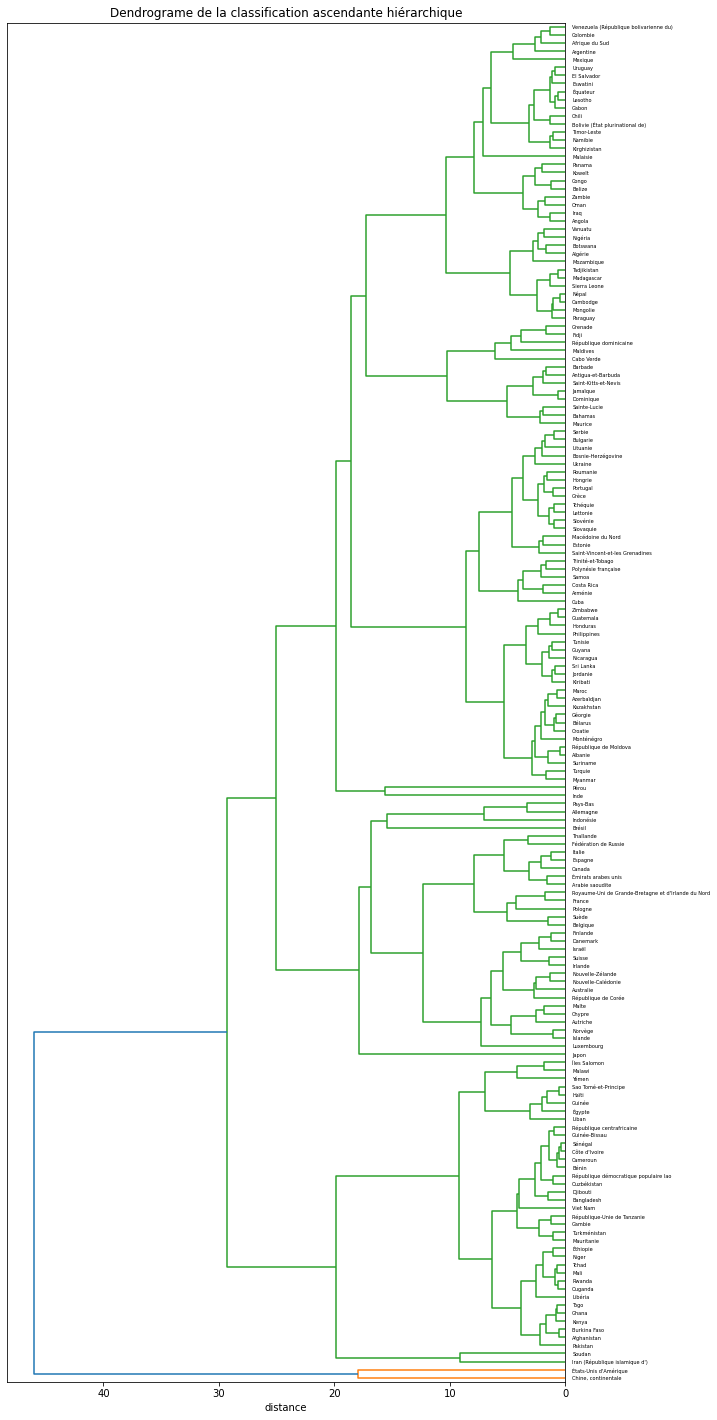

(167, 4)

In [64]:
Z = linkage(X_projected, 'ward')
plot_dendrogram(Z, names)
np.shape(Z)

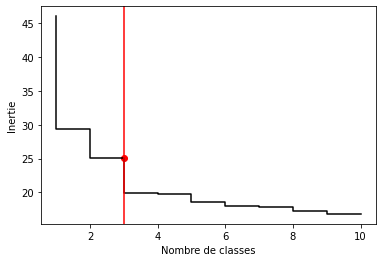

In [66]:
last = Z[-10:, 2]
last_rev = last[::-1]
idxs = np.arange(1, len(last) + 1)
plt.step(idxs, last_rev, c="black")
plt.xlabel("Nombre de classes")
plt.ylabel("Inertie")
nombre = 3 # Ici, on teste le scénario où il y aurait 3 catégories
plt.scatter(idxs[np.where(idxs==nombre)], last_rev[np.where(idxs==nombre)], c="red")
plt.axvline(idxs[np.where(idxs==nombre)], c="red")
plt.show()

Trois clusters, c'est extrêmement insuffisant pour différencier les pays, on a d'un coté chine/usa et de l'autre le reste du monde assez mal séparé, je vais donc utiliser la méthode du coude.

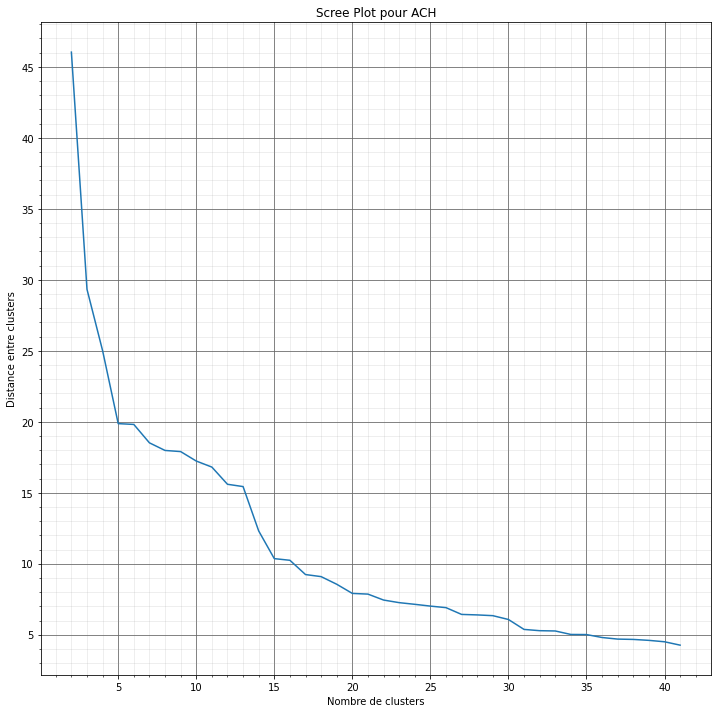

In [68]:
y=[]

for k in range(2,167):
    Hclustering = AgglomerativeClustering(n_clusters=k, linkage='ward', compute_distances=True).fit(X_projected)
    y.append(Hclustering.distances_)

    
# nombre de cluster en ordre descendant
x = np.array([i for i in range(168,1,-1)])

# Y = distance entre clusters
y = np.array(y[0]) 

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
plt.title('Scree Plot pour ACH')
plt.xlabel('Nombre de clusters')
plt.ylabel('Distance entre clusters')
plt.plot(x[-40:],y[-40:])

ax.xaxis.set_major_locator(MultipleLocator(5))
ax.xaxis.set_minor_locator(AutoMinorLocator(1))
ax.yaxis.set_major_locator(MultipleLocator(5))
ax.yaxis.set_minor_locator(AutoMinorLocator(1))
# Show the major grid lines with dark grey lines
plt.grid(b=True, which='major', color='#666666', linestyle='-')

# Show the minor grid lines with very faint and almost transparent grey lines
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)

plt.show()



On va tenter avec 5 clusters, mais la méthode du coude parait difficile à appliquer dans cette situation.

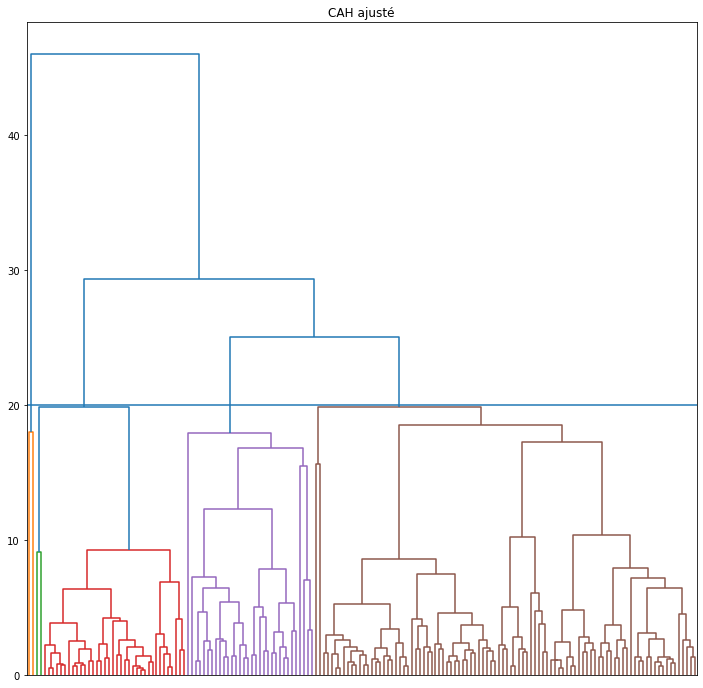

Clusters
Zone                                                        
Afghanistan                                                3
Afrique du Sud                                             5
Albanie                                                    5
Algérie                                                    5
Allemagne                                                  4
Angola                                                     5
Antigua-et-Barbuda                                         5
Arabie saoudite                                            4
Argentine                                                  5
Arménie                                                    5
Australie                                                  4
Autriche                                                   4
Azerbaïdjan                                                5
Bahamas                                                    5
Bangladesh                                                 3
Barbade                                                    5
Belgique                                                   4
Belize                                                     5
Bolivie (État plurinational de)                            5
Bosnie-Herzégovine                                         5
Botswana                                                   5
Brésil                                                     4
Bulgarie                                                   5
Burkina Faso                                               3
Bélarus                                                    5
Bénin                                                      3
Cabo Verde                                                 5
Cambodge                                                   5
Cameroun                                                   3
Canada                                                     4
Chili                                                      5
Chine, continentale                                        1
Chypre                                                     4
Colombie                                                   5
Congo                                                      5
Costa Rica                                                 5
Croatie                                                    5
Cuba                                                       5
Côte d'Ivoire                                              3
Danemark                                                   4
Djibouti                                                   3
Dominique                                                  5
El Salvador                                                5
Espagne                                                    4
Estonie                                                    5
Eswatini                                                   5
Fidji                                                      5
Finlande                                                   4
France                                                     4
Fédération de Russie                                       4
Gabon                                                      5
Gambie                                                     3
Ghana                                                      3
Grenade                                                    5
Grèce                                                      5
Guatemala                                                  5
Guinée                                                     3
Guinée-Bissau                                              3
Guyana                                                     5
Géorgie                                                    5
Haïti                                                      3
Honduras                                                   5
Hongrie                                                    5
Inde                                                       5
Indonésie                 

In [74]:
resultat_cah= fcluster(Z, 5, criterion='maxclust')
resultat_cah = pd.DataFrame(resultat_cah, index=names, columns=['Clusters'])

plt.figure(figsize=(12,12))
plt.title("CAH ajusté") 
plt.axhline(y=20) 
dendrogram(Z,labels=names,no_labels=True,color_threshold=19.85)
plt.show() 
resultat_cah

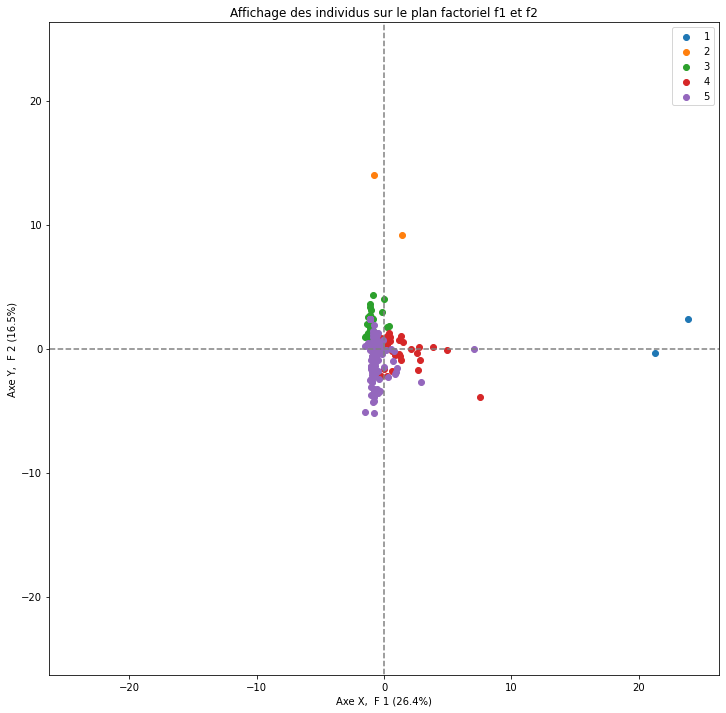

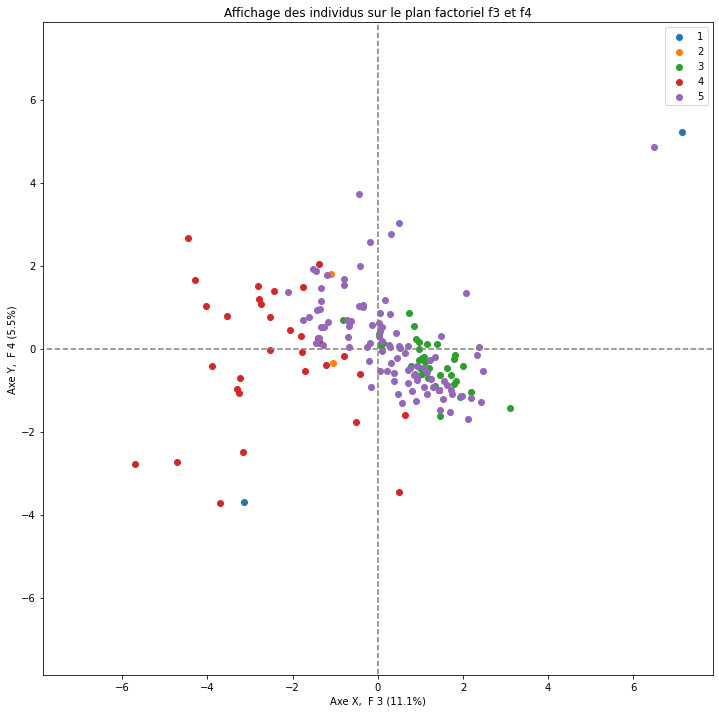

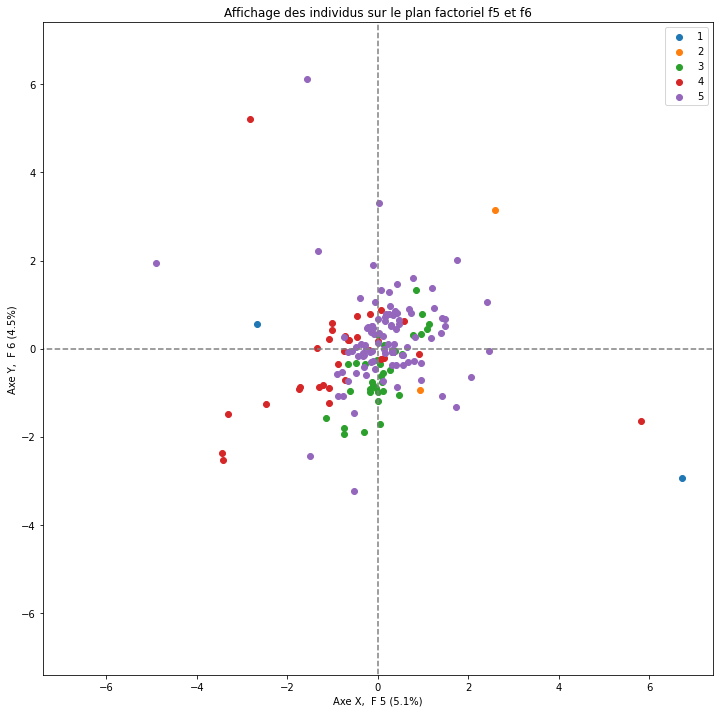

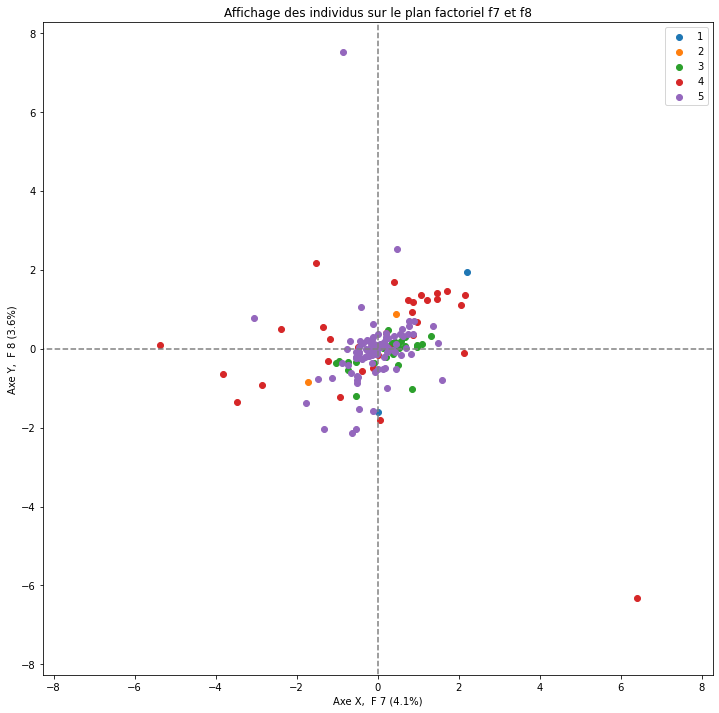

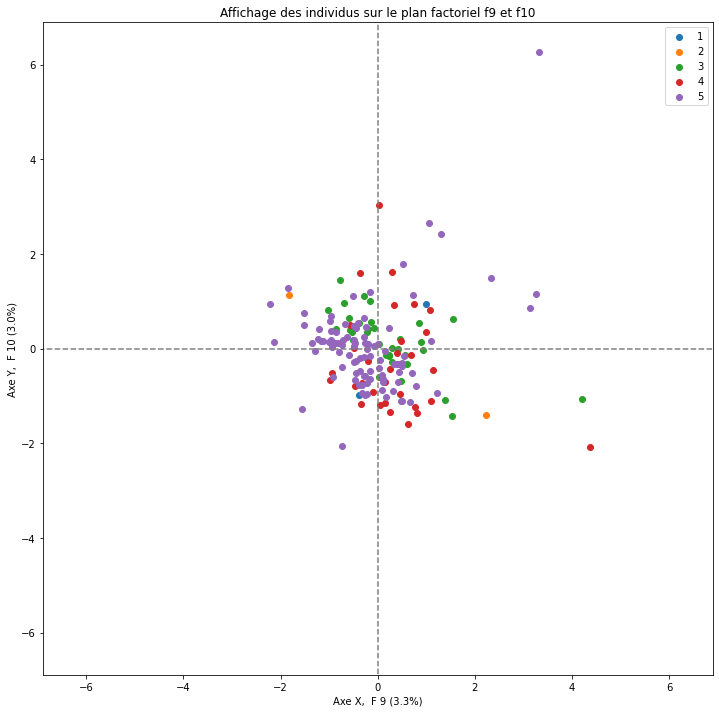

In [75]:
affichage_plan_factoriel(resultat_cah, pca.components_, pca.n_components_)

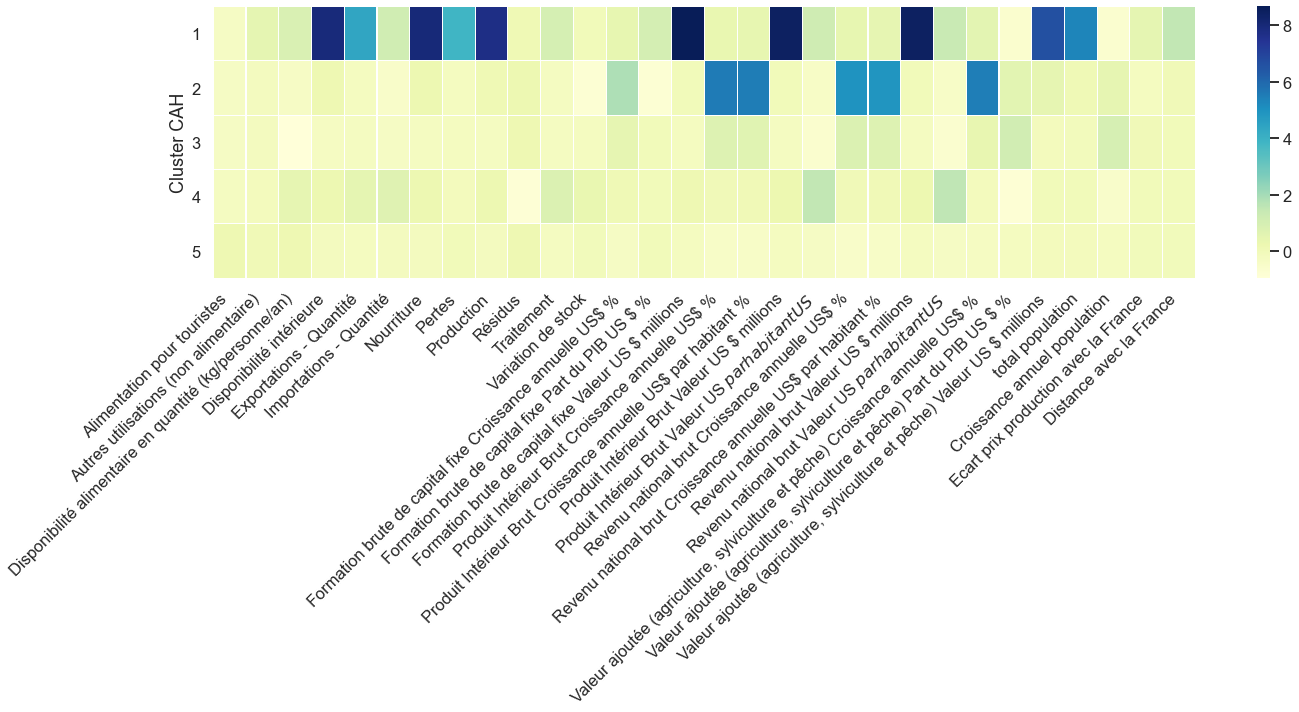

In [76]:
heat_map_cluster(resultat_cah, X_clustered, "CAH")

Sur le cluster 1 et 4 les importations ont l'air plus importantes, on va regarder en détail avec les valeurs moyennes par clusters

In [77]:
resultat_cah = pd.merge(resultat_cah, df,how="inner", left_index=True, right_index=True)
conclusion_cah = resultat_cah.groupby('Clusters').agg("mean")
conclusion_cah

Alimentation pour touristes  Autres utilisations (non alimentaire)  \
Clusters                                                                       
1                              0.0000                              44.500000   
2                              0.0000                               0.000000   
3                              0.0000                               0.000000   
4                              0.0625                               1.781250   
5                              0.3750                              13.770833   

          Disponibilité alimentaire en quantité (kg/personne/an)  \
Clusters                                                           
1                                                 34.005000        
2                                                 14.560000        
3                                                  5.020000        
4                                                 27.476875        
5                                                 22.883542        

          Disponibilité intérieure  Exportations - Quantité  \
Clusters                                                      
1                     18213.500000              2134.000000   
2                      1144.500000                22.500000   
3                       159.944444                 0.277778   
4                      1163.968750               338.625000   
5                       354.614583                20.989583   

          Importations - Quantité    Nourriture      Pertes    Production  \
Clusters                                                                    
1                      287.500000  17809.000000  321.500000  20075.000000   
2                        4.000000   1142.500000    1.500000   1120.500000   
3                       29.722222    155.527778    4.388889    131.166667   
4                      211.312500   1129.000000   10.125000   1332.750000   
5                       59.520833    321.145833   18.656250    326.552083   

           Résidus  ...  \
Clusters            ...   
1        -0.500000  ...   
2         0.000000  ...   
3        -0.027778  ...   
4        -9.718750  ...   
5        -0.281250  ...   

          Revenu national brut Croissance annuelle US$ par habitant %  \
Clusters                                                                
1                                                 -0.131298             
2                                                 44.805312             
3                                                  2.260567             
4                                                 -4.377353             
5                                                 -9.621190             

          Revenu national brut Valeur US $ millions  \
Clusters                                              
1                                      1.795519e+07   
2                                      4.724336e+05   
3                                      5.847535e+04   
4                                      1.049991e+06   
5                                      1.124294e+05   

          Revenu national brut Valeur US $ par habitant US$  \
Clusters                                                      
1                                              37234.860066   
2                                               5940.934386   
3                                               1776.238116   
4                                              40926.256079   
5                                               7584.315524   

          Valeur ajoutée (agriculture, sylviculture et pêche) Croissance annuelle US$ %  \
Clusters                                                                                  
1                                                  8.835185                               
2                                                 65.362356                               
3                                                  7.004945                               
4    

In [78]:
display(conclusion_cah.style.background_gradient(cmap="YlGnBu").set_precision(2).set_caption("Données moyennes par cluster"))


In [79]:
display(resultat_cah[resultat_cah["Clusters"] == 4].sort_values(by='Importations - Quantité',ascending=False).style.background_gradient(cmap="YlGnBu").set_precision(2).set_caption("Données du cluster 4"))


Dans le cluster 4 on a plusieurs candidats intéressants, comme l'Autriche, Chypre, le Luxembourg, etc... Tous les pays de ce cluster sont plutôt riche, certains à proximités ce qui permet de réduire les dépenses de transport, pour certains avec des prix à la production plus élevé qu'en France. 

In [80]:
display(resultat_cah[resultat_cah["Clusters"] == 1].style.background_gradient(cmap="YlGnBu").set_precision(2).set_caption("Données du cluster 4"))


La Chine est un bon candidat, lointaine, mais les prix à la production sont plus fort qu'en France et le volume est présent. Par contre on manque d'information sur les USA

In [81]:
display(resultat_cah[resultat_cah["Clusters"] == 5].sort_values(by='Importations - Quantité',ascending=False).style.background_gradient(cmap="YlGnBu").set_precision(2).set_caption("Données du cluster 5"))

Dans ce dernier cluster, il y a beaucoup de pays importateur, certains avec des prix à la production plus élevé qu'en France, mais ce ne sont pas de très bon candidat, les volumes importés sont plus faibles, les habitants ont un faible pouvoir d'achat et la distance est aussi un handicap

## <a name="C6">K-means</a>

On utilise le score de silhouette pour déterminer le nombre de clusters optimaux.

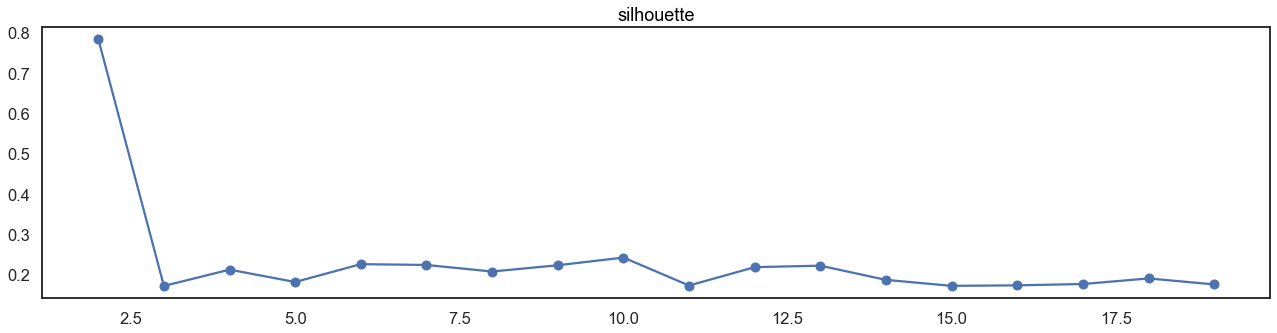

In [164]:
silhouette = []
for num_clusters in range(2,20):
    label = []
    start = time.time()
    km = cluster.KMeans(n_clusters=num_clusters)
    km.fit(X_projected)
    silh = metrics.silhouette_score(X_projected,km.labels_)
    silhouette.append(silh)
plt.plot(range(2,20),silhouette,marker='o')
plt.title("silhouette") 
plt.show() 

On compare avec une seconde méthode. On testera avec 10 clusters

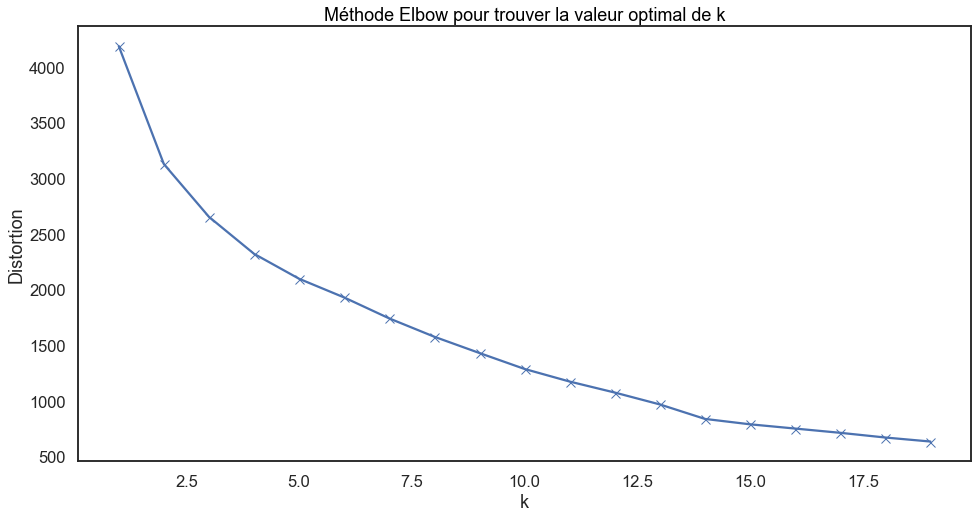

In [165]:
distortions = []
K = range(1,20)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(X_projected)
    distortions.append(kmeanModel.inertia_)

plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('Méthode Elbow pour trouver la valeur optimal de k')
plt.show()

La méthode du coude donne 2 clusters mais ce chiffre est trop bas pour moi, je préfère utilise le score de silhouette

In [166]:

X = X_projected
n_clust = 10

# Clustering par K-means
km = KMeans(n_clusters=n_clust)
km.fit(X)

# Récupération des clusters attribués à chaque individu
clusters = km.labels_
centroids = km.cluster_centers_
clusters_KMeans = km.predict(X)
centroids = km.cluster_centers_

<AxesSubplot:>

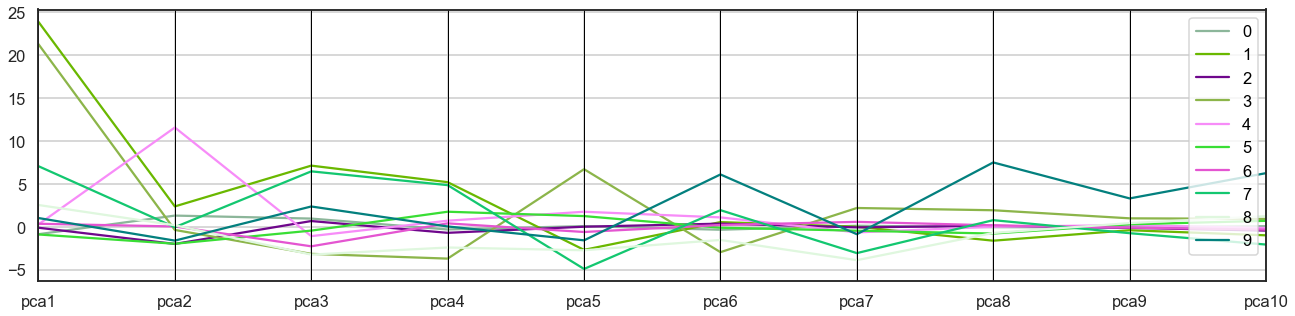

In [167]:
df_centroids = pd.DataFrame(km.cluster_centers_, columns=df_pca.columns)
df_centroids['cluster'] = df_centroids.index
pd.plotting.parallel_coordinates(df_centroids, 'cluster')

In [168]:
resultat_kmeans = pd.DataFrame(clusters, index=names, columns=['Clusters'])
resultat_kmeans

Clusters
Zone                                                        
Afghanistan                                                0
Afrique du Sud                                             2
Albanie                                                    0
Algérie                                                    2
Allemagne                                                  8
Angola                                                     2
Antigua-et-Barbuda                                         5
Arabie saoudite                                            2
Argentine                                                  2
Arménie                                                    5
Australie                                                  6
Autriche                                                   6
Azerbaïdjan                                                2
Bahamas                                                    2
Bangladesh                                                 0
Barbade                                                    5
Belgique                                                   6
Belize                                                     2
Bolivie (État plurinational de)                            2
Bosnie-Herzégovine                                         0
Botswana                                                   2
Brésil                                                     2
Bulgarie                                                   6
Burkina Faso                                               0
Bélarus                                                    2
Bénin                                                      0
Cabo Verde                                                 5
Cambodge                                                   0
Cameroun                                                   0
Canada                                                     6
Chili                                                      2
Chine, continentale                                        1
Chypre                                                     5
Colombie                                                   2
Congo                                                      2
Costa Rica                                                 5
Croatie                                                    6
Cuba                                                       5
Côte d'Ivoire                                              0
Danemark                                                   6
Djibouti                                                   0
Dominique                                                  5
El Salvador                                                2
Espagne                                                    6
Estonie                                                    6
Eswatini                                                   2
Fidji                                                      5
Finlande                                                   6
France                                                     6
Fédération de Russie                                       2
Gabon                                                      2
Gambie                                                     0
Ghana                                                      0
Grenade                                                    5
Grèce                                                      6
Guatemala                                                  0
Guinée                                                     0
Guinée-Bissau                                              0
Guyana                                                     0
Géorgie                                                    2
Haïti                                                      0
Honduras                                                   0
Hongrie                                                    6
Inde                                                       7
Indonésie                 

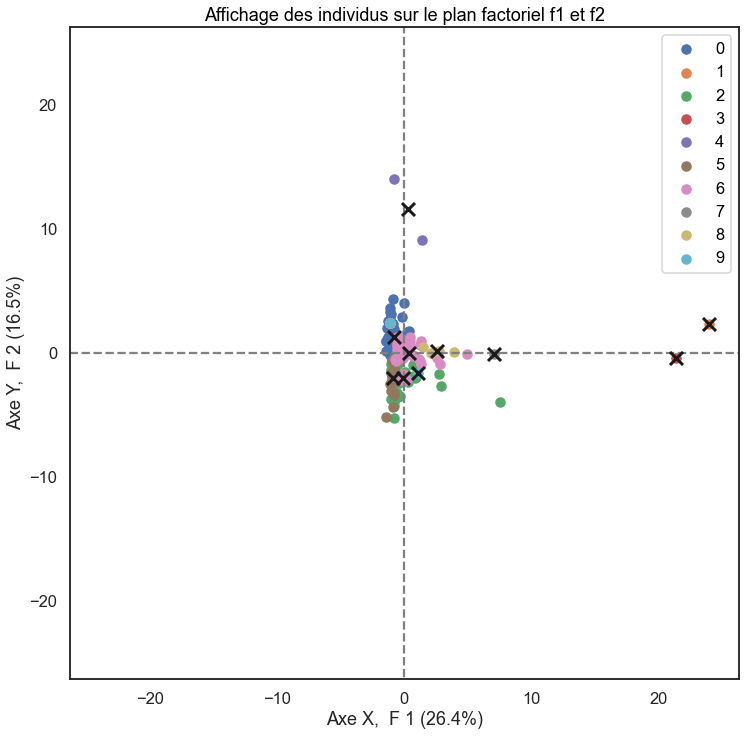

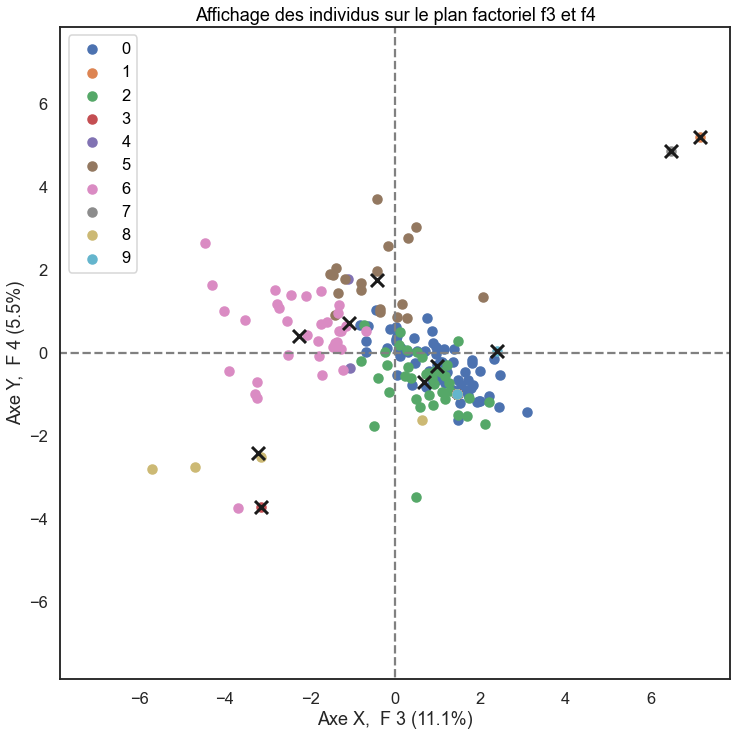

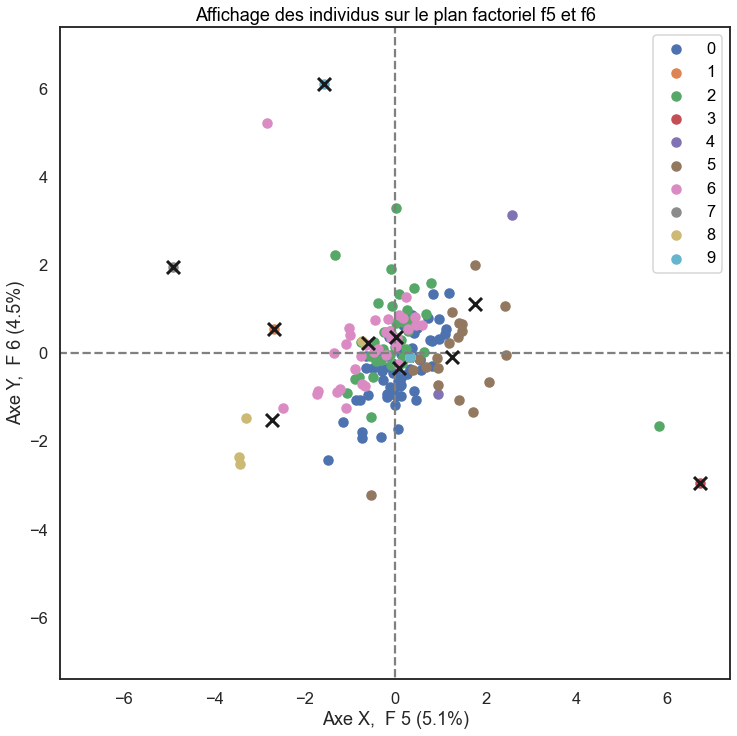

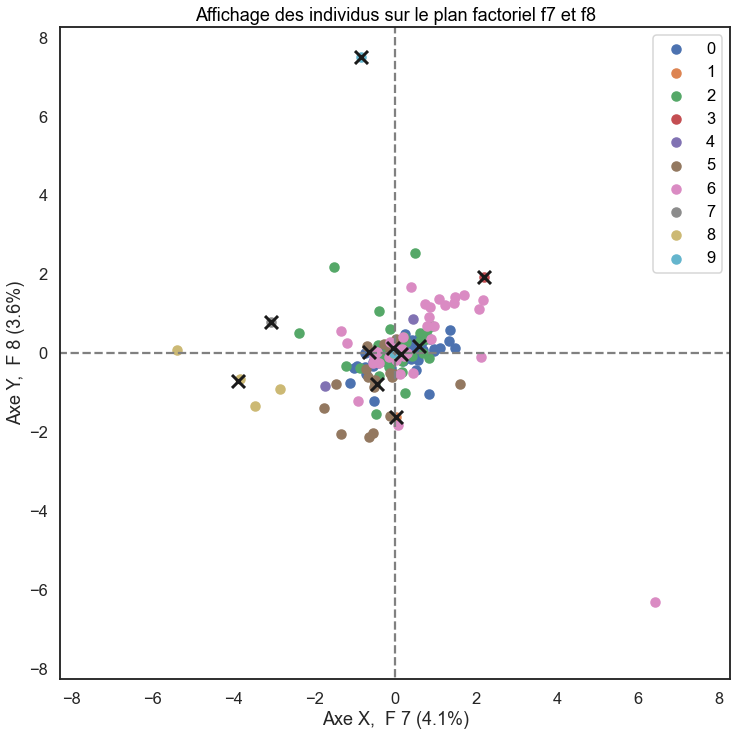

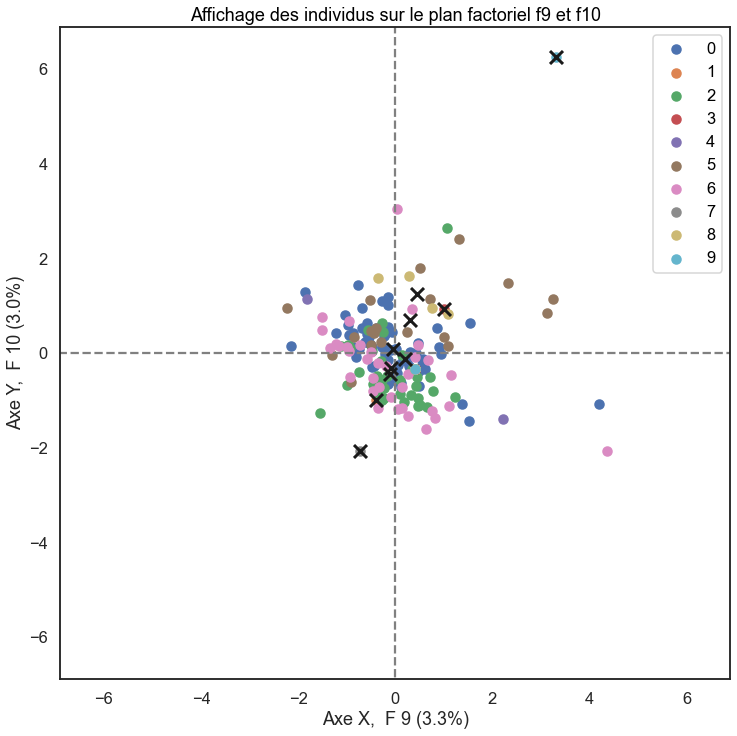

In [169]:
affichage_plan_factoriel(resultat_kmeans, pca.components_, pca.n_components_, centroids)

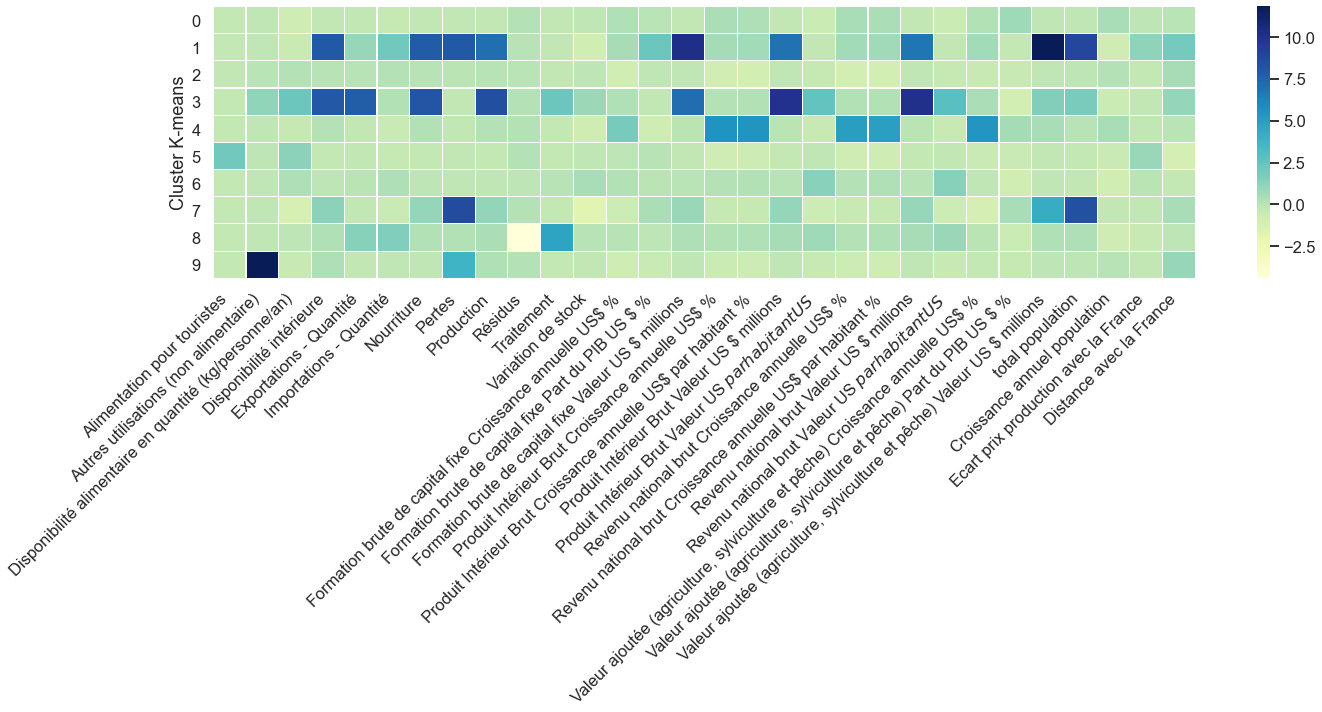

In [170]:
heat_map_cluster(resultat_kmeans, X_clustered, "K-means", "oui")

Cette classification me parait prometeuse on a au moins 3 clusters qui se démarque du coté des importations

In [171]:
resultat_kmeans = pd.merge(resultat_kmeans, df,how="inner", left_index=True, right_index=True)
conclusion_kmeans = resultat_kmeans.groupby('Clusters').agg("mean")
display(conclusion_kmeans.style.background_gradient(cmap="YlGnBu").set_precision(2).set_caption("Données moyennes par cluster"))


In [172]:
for i in range(n_clust):
    titre = "Données du cluster :"+str(i)
    display(resultat_kmeans[resultat_kmeans["Clusters"] == i].sort_values(by='Importations - Quantité',ascending=False).style.background_gradient(cmap="YlGnBu").set_precision(2).set_caption(titre))


## <a name="C7">DBSCAN</a>

In [173]:
# a mettre en boucle
eps_test = np.arange(2.0,10.0,0.2) 
samples_test = np.arange(2,10,1)
df_dbscan = pd.DataFrame()
for i_esp in eps_test:
    for i_sample in samples_test:
        db = DBSCAN(eps=i_esp, min_samples=i_sample).fit(X_projected)
        labels = db.labels_

        n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
        df_dbscan = df_dbscan.append({'samples' : i_sample,
                                      "epsilon" : i_esp,
                                      "silhouette" : metrics.silhouette_score(X_projected, labels),
                                     "cluster" : n_clusters_}, ignore_index = True)
df_dbscan.sort_values(by='silhouette')

cluster  epsilon  samples  silhouette
0        8.0      2.0      2.0   -0.088538
8        5.0      2.2      2.0    0.149408
24       4.0      2.6      2.0    0.179206
16       4.0      2.4      2.0    0.180438
32       4.0      2.8      2.0    0.184584
7        1.0      2.0      9.0    0.209582
40       3.0      3.0      2.0    0.214273
6        1.0      2.0      8.0    0.214327
41       2.0      3.0      3.0    0.225965
5        1.0      2.0      7.0    0.237197
15       1.0      2.2      9.0    0.292378
4        1.0      2.0      6.0    0.294594
2        1.0      2.0      4.0    0.309957
3        1.0      2.0      5.0    0.309957
48       2.0      3.2      2.0    0.313258
1        1.0      2.0      3.0    0.319516
14       1.0      2.2      8.0    0.330081
13       1.0      2.2      7.0    0.348715
12       1.0      2.2      6.0    0.356932
11       1.0      2.2      5.0    0.368774
23       1.0      2.4      9.0    0.370656
22       1.0      2.4      8.0    0.377540
10       1.0      2.2      4.0    0.384231
21       1.0      2.4      7.0    0.392650
9        1.0      2.2      3.0    0.397838
20       1.0      2.4      6.0    0.407731
19       1.0      2.4      5.0    0.407731
31       1.0      2.6      9.0    0.408258
18       1.0      2.4      4.0    0.415356
30       1.0      2.6      8.0    0.421295
17       1.0      2.4      3.0    0.424015
25       1.0      2.6      3.0    0.429884
26       1.0      2.6      4.0    0.429884
28       1.0      2.6      6.0    0.429884
27       1.0      2.6      5.0    0.429884
29       1.0      2.6      7.0    0.429884
33       1.0      2.8      3.0    0.460742
35       1.0      2.8      5.0    0.460742
36       1.0      2.8      6.0    0.460742
37       1.0      2.8      7.0    0.460742
38       1.0      2.8      8.0    0.460742
39       1.0      2.8      9.0    0.460742
34       1.0      2.8      4.0    0.460742
46       1.0      3.0      8.0    0.469509
47       1.0      3.0      9.0    0.469509
45       1.0      3.0      7.0    0.469509
43       1.0      3.0      5.0    0.469509
42       1.0      3.0      4.0    0.469509
44       1.0      3.0      6.0    0.469509
55       1.0      3.2      9.0    0.479450
54       1.0      3.2      8.0    0.479450
56       2.0      3.4      2.0    0.482918
64       2.0      3.6      2.0    0.482918
53       1.0      3.2      7.0    0.488125
52       1.0      3.2      6.0    0.488125
72       2.0      3.8      2.0    0.489445
80       2.0      4.0      2.0    0.490603
88       2.0      4.2      2.0    0.490603
96       2.0      4.4      2.0    0.494190
51       1.0      3.2      5.0    0.496727
50       1.0      3.2      4.0    0.496727
49       1.0      3.2      3.0    0.506632
63       1.0      3.4      9.0    0.529354
61       1.0      3.4      7.0    0.529354
60       1.0      3.4      6.0    0.529354
59       1.0      3.4      5.0    0.529354
58       1.0      3.4      4.0    0.529354
62       1.0      3.4      8.0    0.529354
71       1.0      3.6      9.0    0.541605
70       1.0      3.6      8.0    0.541605
67       1.0      3.6      5.0    0.541605
68       1.0      3.6      6.0    0.541605
66       1.0      3.6      4.0    0.541605
65       1.0      3.6      3.0    0.541605
57       1.0      3.4      3.0    0.541605
69       1.0      3.6      7.0    0.541605
77       1.0      3.8      7.0    0.567406
78       1.0      3.8      8.0    0.567406
79       1.0      3.8      9.0    0.567406
94       1.0      4.2      8.0    0.577201
86       1.0      4.0      8.0    0.577201
87       1.0      4.0      9.0    0.577201
85       1.0      4.0      7.0    0.577201
95       1.0      4.2      9.0    0.577201
76       1.0      3.8      6.0    0.579472
75       1.0      3.8      5.0    0.579472
74       1.0      3.8      4.0    0.579472
73       1.0      3.8      3.0    0.579472
84       1.0      4.0      6.0    0.590279
82       1.0      4.0      4.0    0.590279
81       1.0      4.0      3.0    0.590279
89       1.0      4.2      3.0    0.590279
90    

Le score de silhouete est élevé qu'avec un seul cluster, ce qui ne me satisfait ps du tout. On va essayer une autre méthode

<function matplotlib.pyplot.show(close=None, block=None)>

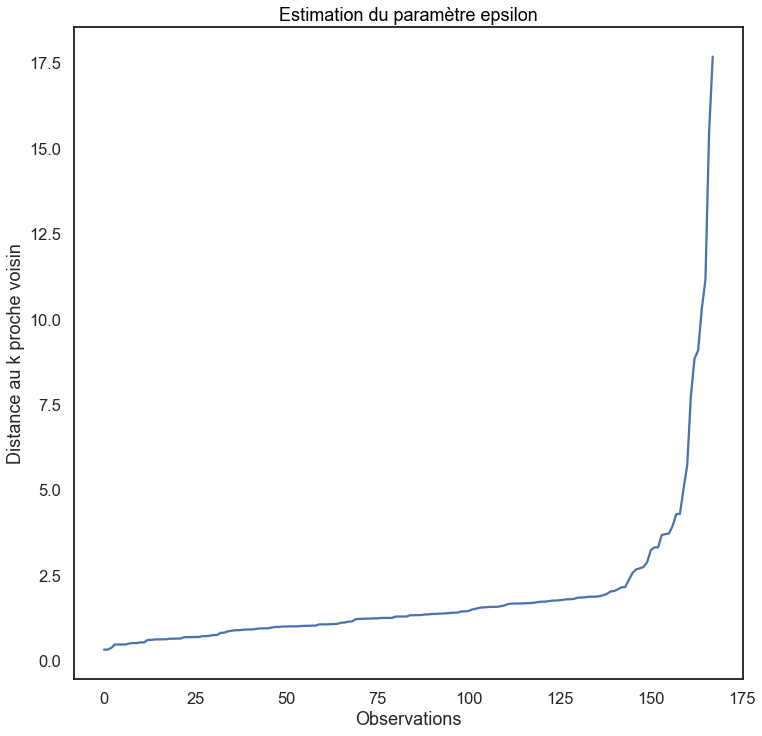

In [174]:
kplusproche = NearestNeighbors(n_neighbors=2)
nbrs = kplusproche.fit(X_projected)
distances, indices = nbrs.kneighbors(X_projected)
distances = np.sort(distances, axis=0)
distances = distances[:,1]

fig = plt.figure(figsize=(12,12))
plt.title('Estimation du paramètre epsilon')
plt.plot(distances)
plt.xlabel("Observations")
plt.ylabel("Distance au k proche voisin")
plt.show

In [175]:
db = DBSCAN(eps=2.5, min_samples=2).fit(X_projected)
labels = db.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print("silhouette score ",metrics.silhouette_score(X_projected, labels))
print("nombre de cluster ", n_clusters_)

silhouette score  0.18043792892748178
nombre de cluster  4


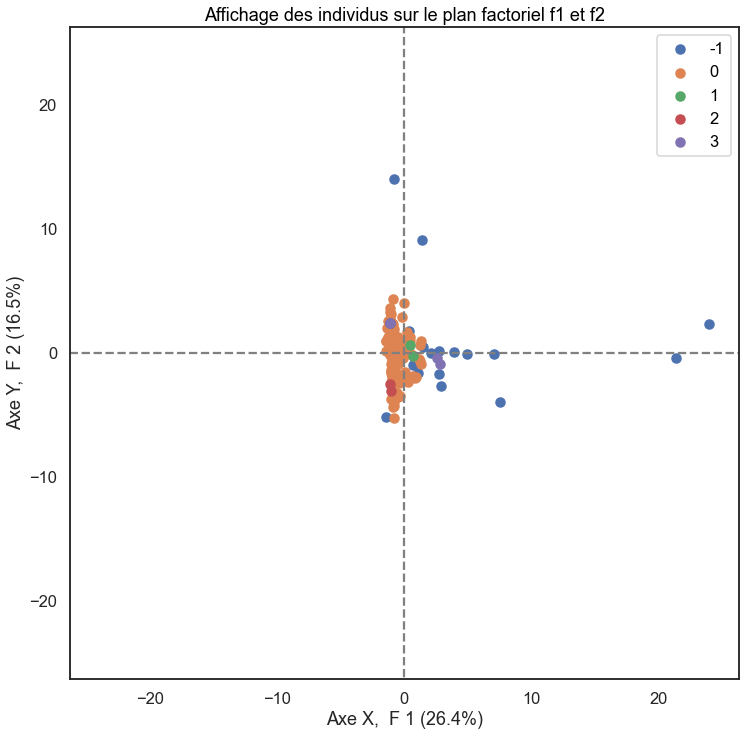

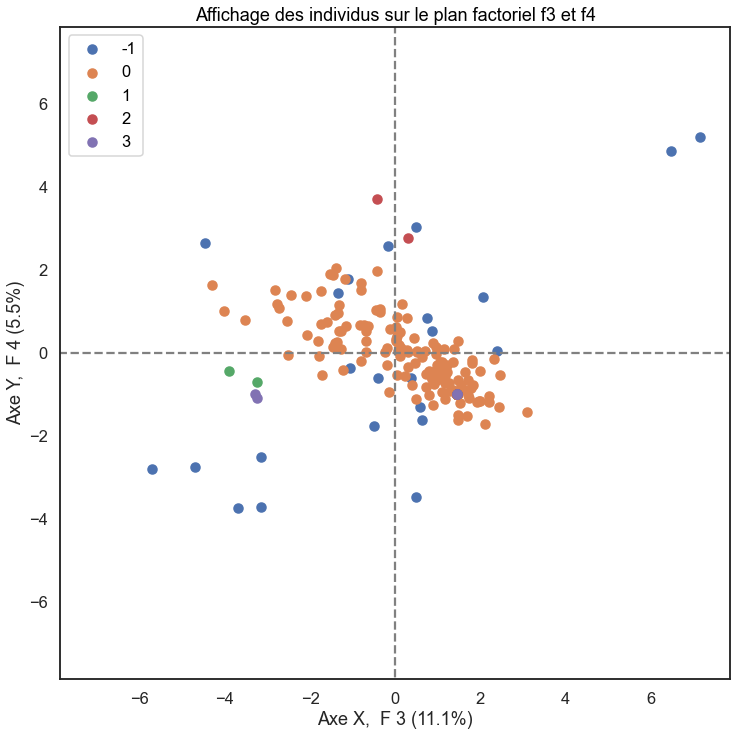

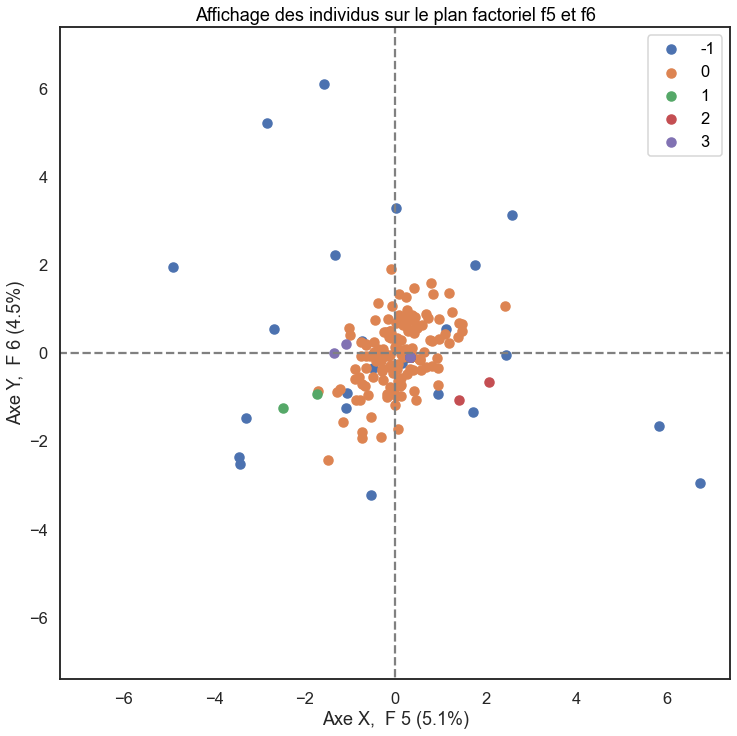

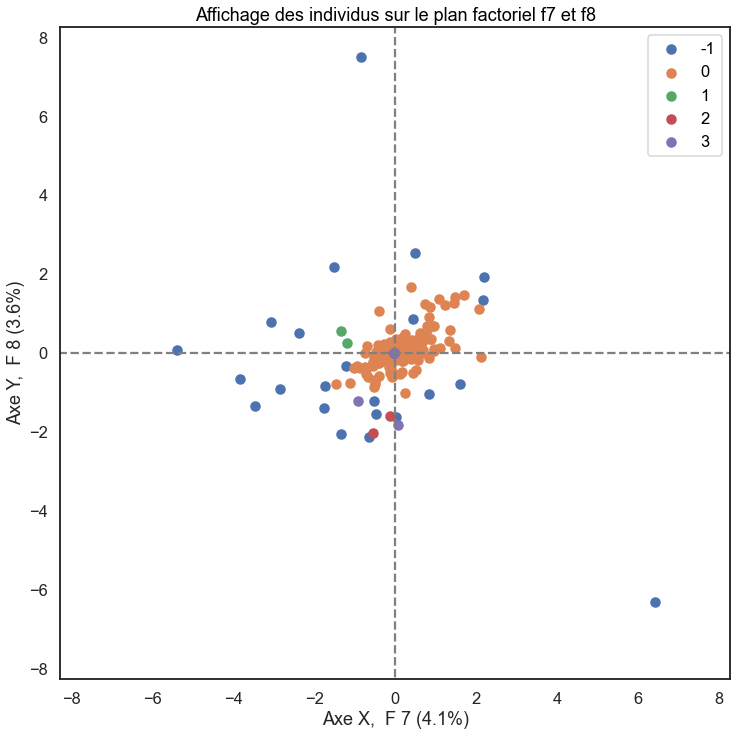

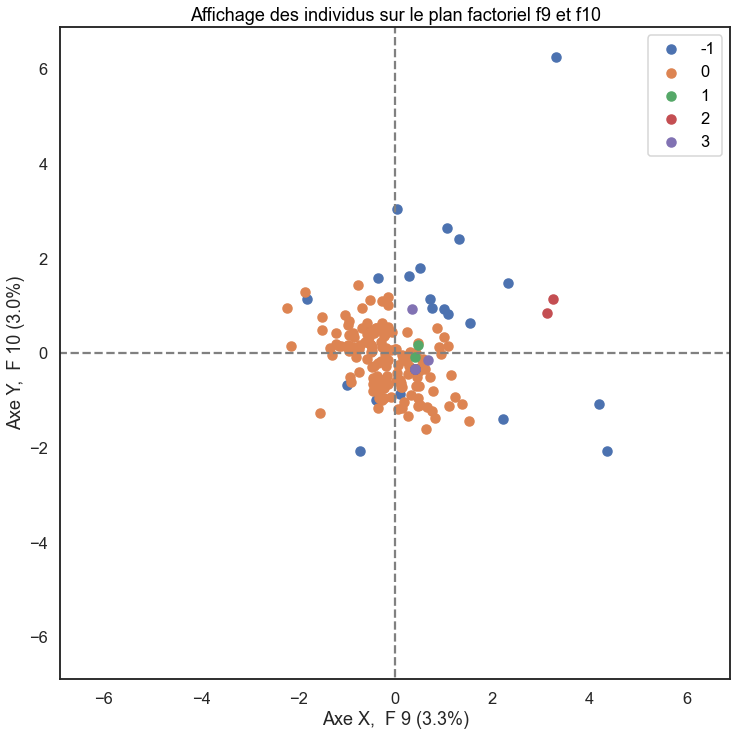

In [176]:
resultat_DBSCAN = pd.DataFrame(labels, index=names, columns=['Clusters'])
affichage_plan_factoriel(resultat_DBSCAN, pca.components_, pca.n_components_)

Le classement est plutôt mauvais on a un gros clusters au centre de chaque plan et des clusters d'outliers autour

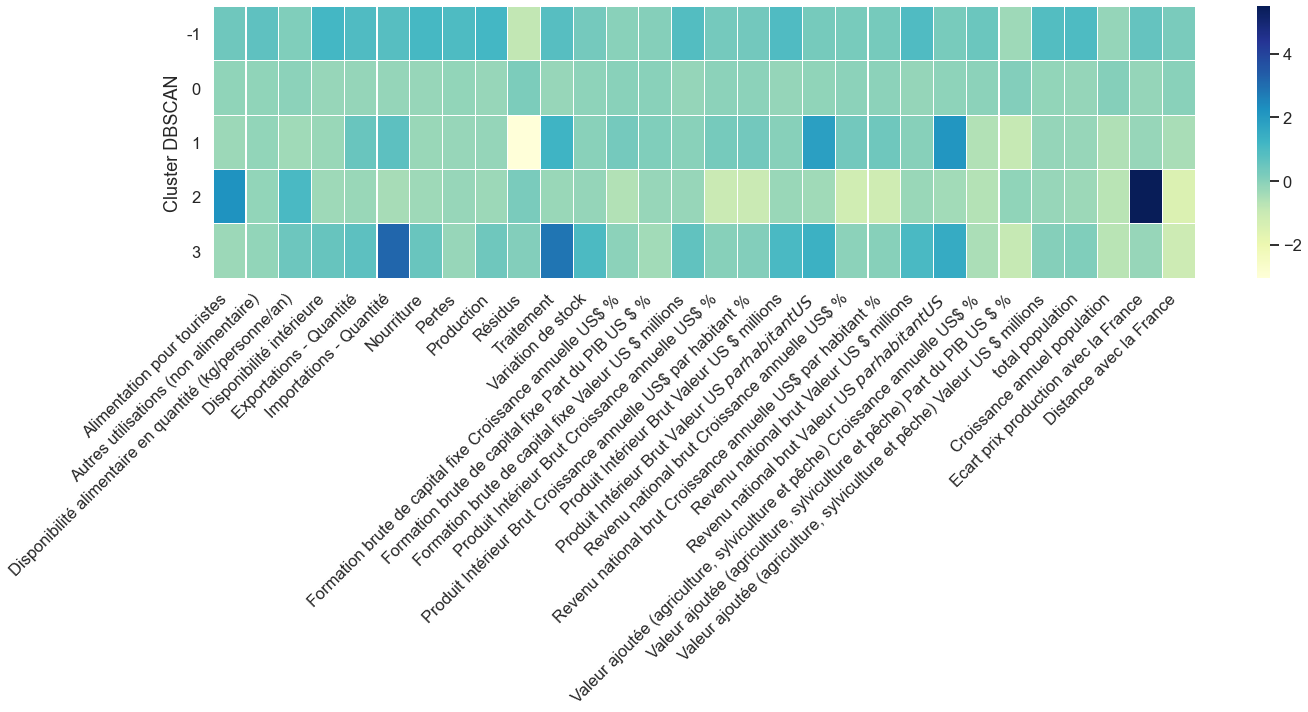

In [177]:
heat_map_cluster(resultat_DBSCAN, X_clustered, "DBSCAN")


In [178]:
resultat_DBSCAN = pd.merge(resultat_DBSCAN, df,how="inner", left_index=True, right_index=True)
conclusion_DBSCAN = resultat_DBSCAN.groupby('Clusters').agg("mean")
display(conclusion_DBSCAN.style.background_gradient(cmap="YlGnBu").set_precision(2).set_caption("Données moyennes par cluster"))


La classification par DBSAN ne m'a pas paru pertinente, avec plusieurs essais et méthodes différentes pour déterminer le nombre de clusters idéal, j'arrive toujours à des résultats sans intérêt, soit d'un cluster géant qui regroupe presque tous les pays ou des clusters plus nombreux, mais non-pertinents.

## <a name="C8">Analyse finale</a>

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 [Text(0, 0, 'Alimentation pour touristes'),
  Text(1, 0, 'Autres utilisations (non alimentaire)'),
  Text(2, 0, 'Disponibilité alimentaire en quantité (kg/personne/an)'),
  Text(3, 0, 'Disponibilité intérieure'),
  Text(4, 0, 'Exportations - Quantité'),
  Text(5, 0, 'Importations - Quantité'),
  Text(6, 0, 'Nourriture'),
  Text(7, 0, 'Pertes'),
  Text(8, 0, 'Production'),
  Text(9, 0, 'Résidus'),
  Text(10, 0, 'Traitement'),
  Text(11, 0, 'Variation de stock'),
  Text(12, 0, 'Formation brute de capital fixe Croissance annuelle US$ %'),
  Text(13, 0, 'Formation brute de capital fixe Part du PIB US $ %'),
  Text(14, 0, 'Formation brute de capital fixe Valeur US $ millions'),
  Text(15, 0, 'Produit Intérieur Brut Croissance annuelle US$ %'),
  Text(16, 0, 'Produit Intérieur Brut Croissance annuelle US$ par habitant %'),
  Text(17, 0, 'Produit Intérieur

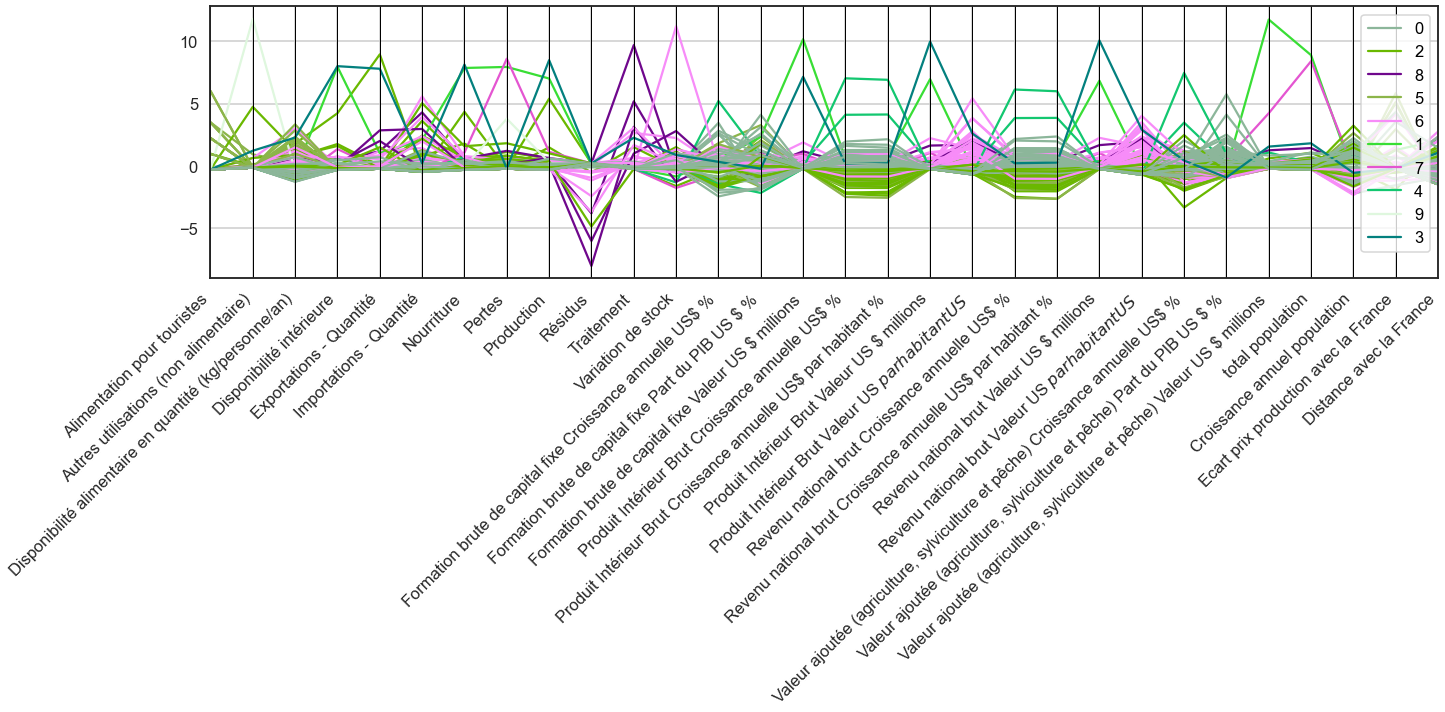

In [179]:
res_kmeans = pd.DataFrame(clusters, index=names, columns=['Clusters'])
paralle_kmeans = pd.merge(res_kmeans, X_clustered,how="inner", left_index=True, right_index=True)

pd.plotting.parallel_coordinates(paralle_kmeans, 'Clusters')
plt.xticks(rotation=45, horizontalalignment='right')

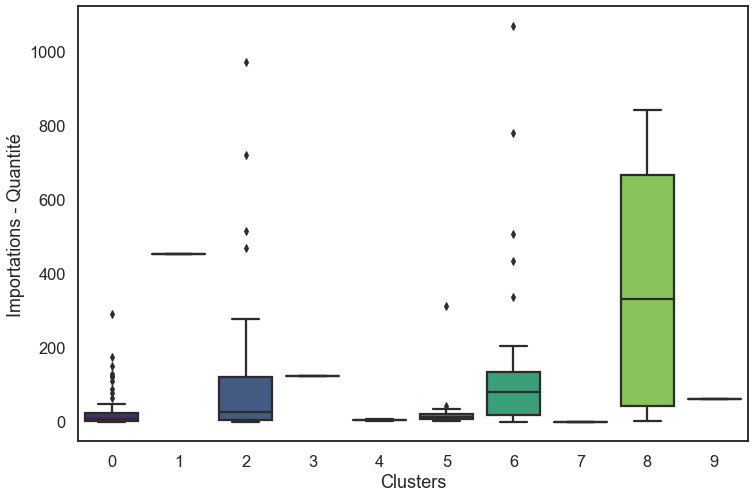

In [180]:
plt.figure(figsize=(12,8))
sns.boxplot(x="Clusters", y="Importations - Quantité", data=resultat_kmeans, palette="viridis")
plt.show()

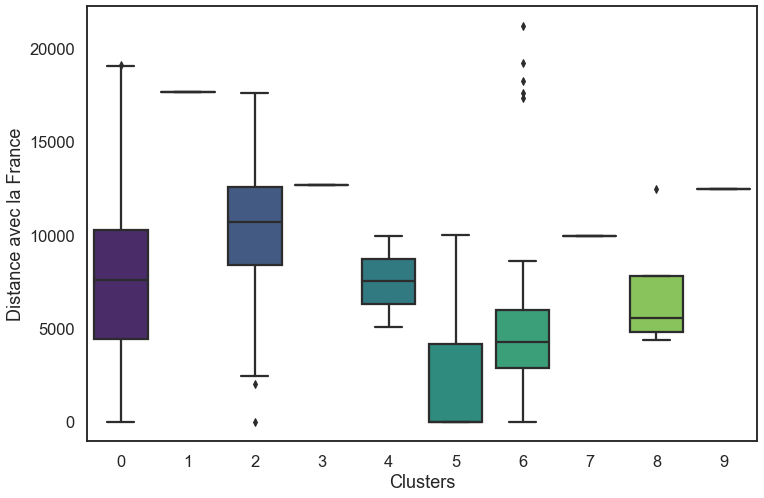

In [181]:
plt.figure(figsize=(12,8))
sns.boxplot(x="Clusters", y="Distance avec la France", data=resultat_kmeans, palette="viridis")
plt.show()

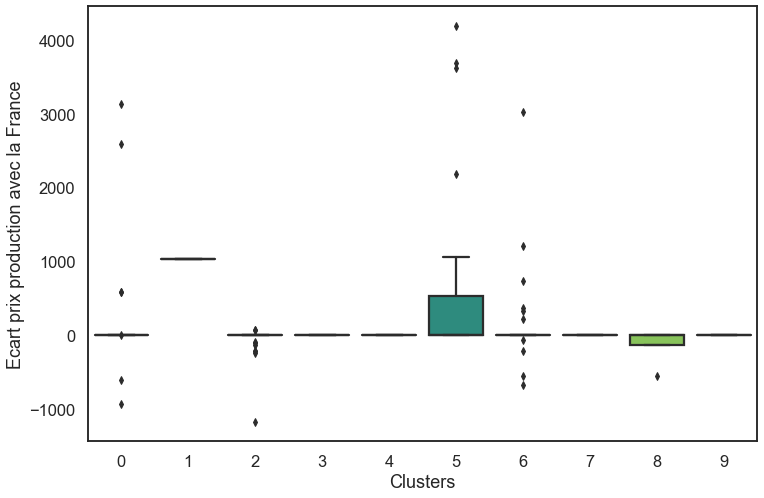

In [182]:
plt.figure(figsize=(12,8))
sns.boxplot(x="Clusters", y="Ecart prix production avec la France", data=resultat_kmeans, palette="viridis")
plt.show()

In [183]:
for i in range(n_clust):
    titre = "Données du cluster :"+str(i)
    display(resultat_kmeans[resultat_kmeans["Clusters"] == i].sort_values(by='Importations - Quantité',ascending=False).style.background_gradient(cmap="YlGnBu").set_precision(2).set_caption(titre))

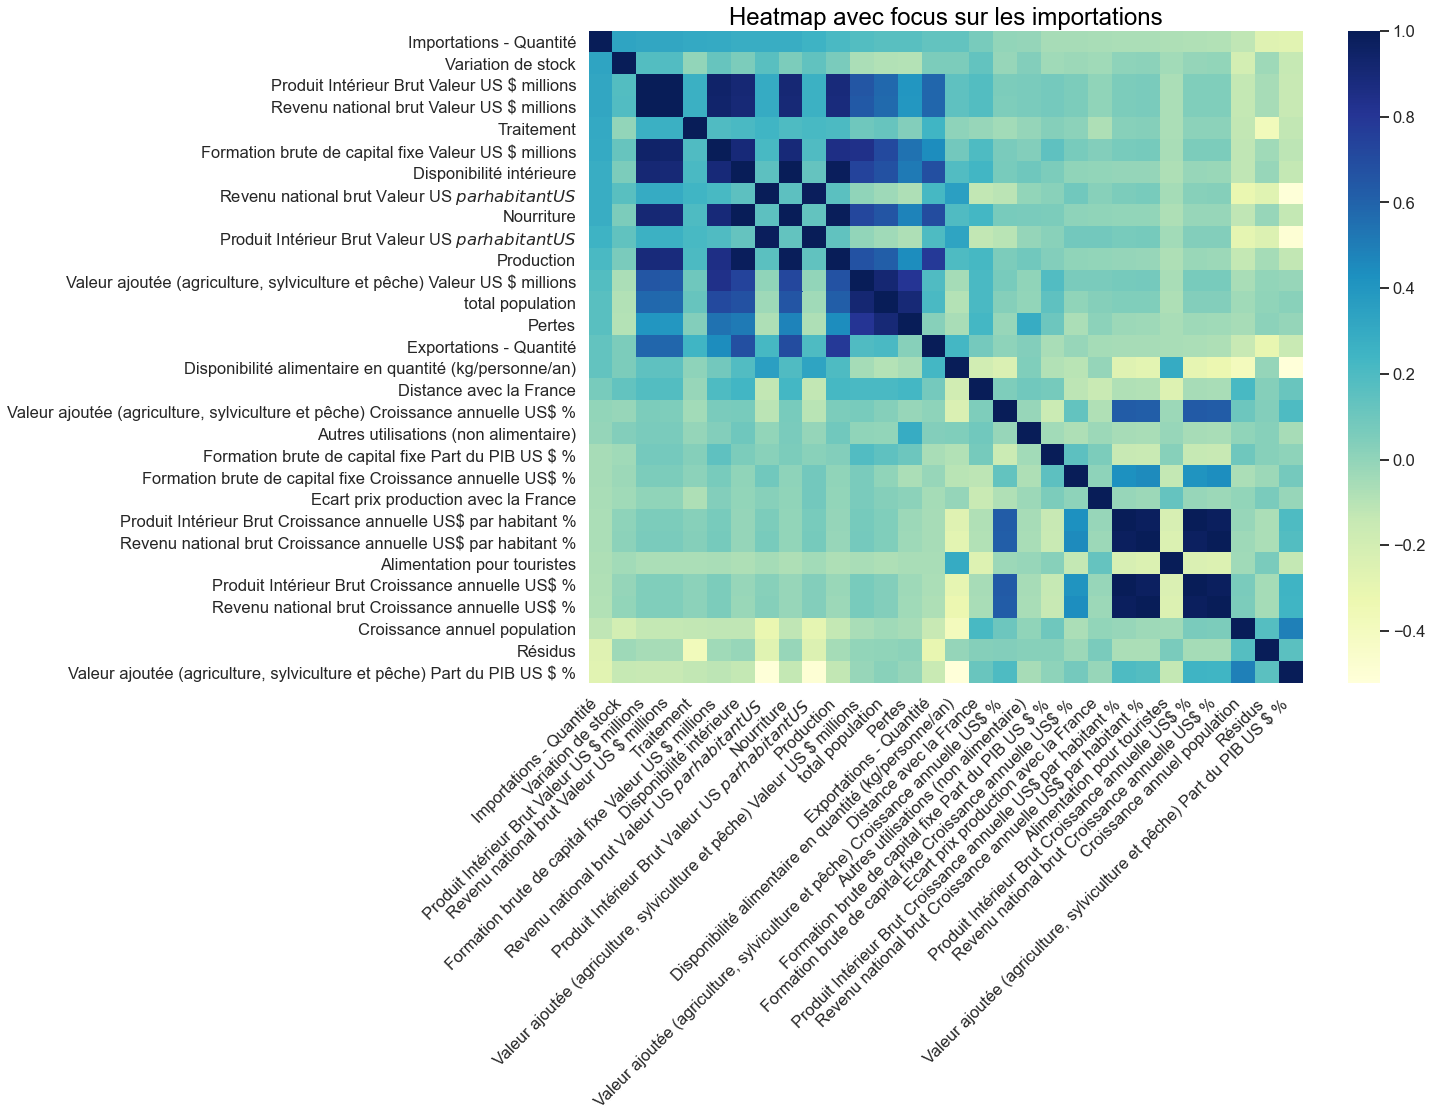

In [184]:
k = 100
corrmat = df.corr()
cols = corrmat.nlargest(k,'Importations - Quantité')['Importations - Quantité'].index 
cm = np.corrcoef(df[cols].values.T) 
variable_intéressante = pd.DataFrame(cm,index = cols.values, columns = cols.values)
plt.subplots(figsize =(16, 12)) 
sns.heatmap(variable_intéressante, cmap ="YlGnBu") 
plt.title("Heatmap avec focus sur les importations", fontsize=24)
plt.xticks(rotation=45, horizontalalignment='right')
plt.show()

In [185]:
resultat_carte = resultat_kmeans.merge(code_iso, how='inner', on='Zone')
resultat_carte

Zone  Clusters  \
0                                          Afghanistan         0   
1                                       Afrique du Sud         2   
2                                              Albanie         0   
3                                              Algérie         2   
4                                            Allemagne         8   
5                                               Angola         2   
6                                   Antigua-et-Barbuda         5   
7                                      Arabie saoudite         2   
8                                            Argentine         2   
9                                              Arménie         5   
10                                           Australie         6   
11                                            Autriche         6   
12                                         Azerbaïdjan         2   
13                                             Bahamas         2   
14                                          Bangladesh         0   
15                                             Barbade         5   
16                                            Belgique         6   
17                                              Belize         2   
18                     Bolivie (État plurinational de)         2   
19                                  Bosnie-Herzégovine         0   
20                                            Botswana         2   
21                                              Brésil         2   
22                                            Bulgarie         6   
23                                        Burkina Faso         0   
24                                             Bélarus         2   
25                                               Bénin         0   
26                                          Cabo Verde         5   
27                                            Cambodge         0   
28                                            Cameroun         0   
29                                              Canada         6   
30                                               Chili         2   
31                                 Chine, continentale         1   
32                                              Chypre         5   
33                                            Colombie         2   
34                                               Congo         2   
35                                          Costa Rica         5   
36                                             Croatie         6   
37                                                Cuba         5   
38                                       Côte d'Ivoire         0   
39                                            Danemark         6   
40                                            Djibouti         0   
41                                           Dominique         5   
42                                         El Salvador         2   
43                                             Espagne         6   
44                                             Estonie         6   
45                                            Eswatini         2   
46                                               Fidji         5   
47                                            Finlande         6   
48                                              France         6   
49                                Fédération de Russie         2   
50                                               Gabon         2   
51                                              Gambie         0   
52                                               Ghana         0   
53                                             Grenade         5   
54                                               Grèce         6   
55                                           Guatemala         0   
56                                              Guinée         0   
57                                       Guinée-Bissau         0   
58                                    

In [186]:
resultat_carte.loc[resultat_carte['Code zone (ISO3)']=='F41','Code zone (ISO3)']='CHN'

In [188]:
import folium
import json

f = open ('world-countries.json', "r")
state_geo = json.loads(f.read())




m = folium.Map(location=[0, 0], zoom_start=2)

folium.Choropleth(
    geo_data=state_geo,
    name="choropleth",
    data=resultat_carte,
    columns=["Code zone (ISO3)", "Clusters"],
    key_on="feature.id",
    fill_color="YlGnBu",
    fill_opacity=0.7,
    nan_fill_color='white',
    line_opacity=0.2,
    legend_name="Clusters obtenus par le K-means",
    reset=True,
    bins=8,
).add_to(m)

folium.LayerControl().add_to(m)

m